In [ ]:
# Cell 1: Environment Setup and Dependencies

!pip install -q \
    psycopg2-binary \
    pgvector \
    sqlalchemy \
    geoalchemy2 \
    sentence-transformers \
    spacy \
    transformers \
    faiss-cpu \
    requests \
    aiohttp \
    pandas \
    numpy \
    tqdm \
    python-dotenv \
    openrouteservice \
    gtfs-realtime-bindings \
    protobuf

!pip install streamlit streamlit-folium folium pandas numpy

# Download spaCy model for named entity recognition
!python -m spacy download en_core_web_lg

import os
import json
import logging
import hashlib
import pickle
import asyncio
import aiohttp
import requests
import numpy as np
import pandas as pd
from datetime import datetime, time, timedelta
from typing import Dict, List, Optional, Tuple, Any
from dataclasses import dataclass, field
from abc import ABC, abstractmethod
from tqdm import tqdm
import warnings

warnings.filterwarnings('ignore')

logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

In [2]:
# Cell 2: Database Setup - SQLite

from sqlalchemy import create_engine, Column, Integer, String, Float, JSON, DateTime, Text, ForeignKey, Boolean
from sqlalchemy.ext.declarative import declarative_base
from sqlalchemy.orm import sessionmaker, relationship
from datetime import datetime
import os
import numpy as np


class DatabaseConfig:
    DB_TYPE = "sqlite"
    DB_URL = "sqlite:///data/trip_planner_v2.db"
    EMBEDDING_DIM = 768

config = DatabaseConfig()

Base = declarative_base()


# Database Models

class POI(Base):
    __tablename__ = 'pois'

    id = Column(Integer, primary_key=True, autoincrement=True)
    source = Column(String(50), nullable=False)
    source_id = Column(String(100), nullable=False)
    name = Column(String(500), nullable=False)
    name_normalized = Column(String(500))
    description = Column(Text)
    lat = Column(Float, nullable=False)
    lon = Column(Float, nullable=False)
    category = Column(JSON)
    tags = Column(JSON)
    city = Column(String(200))
    country = Column(String(100))
    timezone = Column(String(50))
    popularity_score = Column(Float, default=0.0)
    rating = Column(Float)
    review_count = Column(Integer, default=0)
    price_level = Column(Integer)
    wheelchair_accessible = Column(Boolean)
    wikidata_id = Column(String(20))
    created_at = Column(DateTime, default=datetime.utcnow)
    updated_at = Column(DateTime, default=datetime.utcnow, onupdate=datetime.utcnow)

    hours = relationship("POIHours", back_populates="poi", cascade="all, delete-orphan")
    embedding = relationship("POIEmbedding", back_populates="poi", uselist=False, cascade="all, delete-orphan")
    popularity_history = relationship("POIPopularity", back_populates="poi", cascade="all, delete-orphan")


class POIHours(Base):
    __tablename__ = 'poi_hours'

    id = Column(Integer, primary_key=True, autoincrement=True)
    poi_id = Column(Integer, ForeignKey('pois.id', ondelete='CASCADE'), nullable=False)
    raw_hours = Column(String(500))
    parsed_hours = Column(JSON)
    season = Column(String(50))
    valid_from = Column(DateTime)
    valid_to = Column(DateTime)

    poi = relationship("POI", back_populates="hours")


class POIEmbedding(Base):
    __tablename__ = 'poi_embeddings'

    id = Column(Integer, primary_key=True, autoincrement=True)
    poi_id = Column(Integer, ForeignKey('pois.id', ondelete='CASCADE'), nullable=False, unique=True)
    embedding = Column(JSON)
    model_name = Column(String(100), default='multilingual-e5-base')
    created_at = Column(DateTime, default=datetime.utcnow)

    poi = relationship("POI", back_populates="embedding")


class POIPopularity(Base):
    __tablename__ = 'poi_popularity'

    id = Column(Integer, primary_key=True, autoincrement=True)
    poi_id = Column(Integer, ForeignKey('pois.id', ondelete='CASCADE'), nullable=False)
    timestamp = Column(DateTime, nullable=False)
    period_type = Column(String(20))
    visit_count = Column(Integer, default=0)
    avg_duration_minutes = Column(Float)
    popularity_index = Column(Float)

    poi = relationship("POI", back_populates="popularity_history")


class RouteCache(Base):
    __tablename__ = 'route_cache'

    id = Column(Integer, primary_key=True, autoincrement=True)
    origin_lat = Column(Float, nullable=False)
    origin_lon = Column(Float, nullable=False)
    dest_lat = Column(Float, nullable=False)
    dest_lon = Column(Float, nullable=False)
    mode = Column(String(20), nullable=False)
    distance_km = Column(Float)
    duration_minutes = Column(Float)
    route_geometry = Column(Text)
    created_at = Column(DateTime, default=datetime.utcnow)
    expires_at = Column(DateTime)


# Database Manager

class DatabaseManager:
    def __init__(self, db_url: str = None):
        self.db_url = db_url or config.DB_URL
        self.engine = create_engine(self.db_url, echo=False)
        self.Session = sessionmaker(bind=self.engine)

    def init_db(self):
        os.makedirs("data", exist_ok=True)
        Base.metadata.create_all(self.engine)

    def get_session(self):
        return self.Session()

    @staticmethod
    def haversine_distance(lat1, lon1, lat2, lon2):
        R = 6371
        lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
        dlat, dlon = lat2 - lat1, lon2 - lon1
        a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
        return R * 2 * np.arcsin(np.sqrt(a))


# Initialize database

os.makedirs("data", exist_ok=True)
db_manager = DatabaseManager()
db_manager.init_db()

print("SQLite Database Ready")
print(f"Location: {config.DB_URL}")
print(f"Embedding dim: {config.EMBEDDING_DIM}")

SQLite Database Ready
Location: sqlite:///data/trip_planner_v2.db
Embedding dim: 768


In [3]:
# Cell 3: Multi-Source Data Fetchers

import hashlib
import time as time_module
from typing import Dict, List, Optional, Tuple
import requests
import pandas as pd
from tqdm import tqdm
import random


class BaseDataFetcher:
    """Base class for all data fetchers"""

    def __init__(self):
        self.session = requests.Session()
        self.session.headers.update({
            'User-Agent': 'TripPlannerRAG/2.0 (Educational Project; Contact: your@email.com)'
        })

    def normalize_name(self, name: str) -> str:
        if not name:
            return ""
        import re
        normalized = name.lower()
        normalized = re.sub(r'[^\w\s]', '', normalized)
        normalized = re.sub(r'\s+', ' ', normalized).strip()
        return normalized


class OSMDataFetcher(BaseDataFetcher):
    """Fetches POIs from OpenStreetMap with rate limiting"""

    OVERPASS_ENDPOINTS = [
        "https://overpass-api.de/api/interpreter",
        "https://overpass.kumi.systems/api/interpreter",
        "https://maps.mail.ru/osm/tools/overpass/api/interpreter",
    ]

    POI_QUERIES = {
        'tourism': ['hotel', 'attraction', 'museum', 'viewpoint', 'zoo', 'theme_park'],
        'amenity': ['restaurant', 'cafe', 'bar', 'pub', 'fast_food', 'theatre', 'cinema', 'library'],
        'leisure': ['park', 'garden', 'playground', 'stadium', 'swimming_pool'],
        'shop': ['mall', 'supermarket'],
        'historic': ['monument', 'memorial', 'castle', 'ruins'],
    }

    def __init__(self):
        super().__init__()
        self.current_endpoint_idx = 0
        self.min_delay = 5
        self.last_request_time = 0

    def _get_endpoint(self) -> str:
        endpoint = self.OVERPASS_ENDPOINTS[self.current_endpoint_idx]
        self.current_endpoint_idx = (self.current_endpoint_idx + 1) % len(self.OVERPASS_ENDPOINTS)
        return endpoint

    def _wait_for_rate_limit(self):
        elapsed = time_module.time() - self.last_request_time
        if elapsed < self.min_delay:
            wait_time = self.min_delay - elapsed + random.uniform(0.5, 2.0)
            print(f"      Rate limit: waiting {wait_time:.1f}s...")
            time_module.sleep(wait_time)
        self.last_request_time = time_module.time()

    def fetch_pois(self, bbox: Tuple[float, float, float, float],
                   city: str = None, country: str = None) -> List[Dict]:

        min_lat, min_lon, max_lat, max_lon = bbox
        all_pois = []

        print(f"      Building combined query...")

        query_parts = []
        for main_cat, sub_cats in self.POI_QUERIES.items():
            for sub_cat in sub_cats:
                query_parts.append(f'node["{main_cat}"="{sub_cat}"]({min_lat},{min_lon},{max_lat},{max_lon});')
                query_parts.append(f'way["{main_cat}"="{sub_cat}"]({min_lat},{min_lon},{max_lat},{max_lon});')

        overpass_query = f"""
        [out:json][timeout:120];
        (
            {chr(10).join(query_parts)}
        );
        out center meta;
        """

        max_retries = 5

        for attempt in range(max_retries):
            self._wait_for_rate_limit()
            endpoint = self._get_endpoint()

            try:
                print(f"      Attempt {attempt + 1}/{max_retries} via {endpoint.split('/')[2]}...")

                response = self.session.post(
                    endpoint,
                    data={'data': overpass_query},
                    timeout=180
                )

                if response.status_code == 429:
                    wait_time = 30 + (attempt * 15) + random.uniform(5, 15)
                    print(f"      Rate limited. Waiting {wait_time:.0f}s...")
                    time_module.sleep(wait_time)
                    continue

                if response.status_code == 504:
                    print(f"      Timeout. Trying different endpoint...")
                    continue

                response.raise_for_status()
                data = response.json()

                for element in data.get('elements', []):
                    poi = self._parse_osm_element(element, city, country)
                    if poi:
                        all_pois.append(poi)

                print(f"      Fetched {len(all_pois)} POIs from OSM")
                break

            except requests.exceptions.Timeout:
                print(f"      Request timeout. Retrying...")
                continue
            except requests.exceptions.RequestException as e:
                print(f"      Request failed: {str(e)[:50]}. Retrying...")
                time_module.sleep(10)
                continue
            except Exception as e:
                print(f"      Error: {str(e)[:50]}")
                break

        return all_pois

    def _parse_osm_element(self, element: Dict, city: str, country: str) -> Optional[Dict]:
        tags = element.get('tags', {})

        name = tags.get('name') or tags.get('name:en')
        if not name:
            return None

        if element['type'] == 'node':
            lat, lon = element.get('lat'), element.get('lon')
        elif 'center' in element:
            lat, lon = element['center'].get('lat'), element['center'].get('lon')
        else:
            return None

        if not lat or not lon:
            return None

        categories = []
        for main_cat in self.POI_QUERIES.keys():
            if main_cat in tags:
                categories.append(main_cat)
                categories.append(tags[main_cat])

        if not categories:
            categories = ['other']

        return {
            'source': 'osm',
            'source_id': f"osm_{element['type']}_{element['id']}",
            'name': name,
            'name_normalized': self.normalize_name(name),
            'description': tags.get('description', ''),
            'lat': lat,
            'lon': lon,
            'category': list(set(categories)),
            'tags': tags,
            'city': city,
            'country': country,
            'wikidata_id': tags.get('wikidata'),
            'wheelchair_accessible': tags.get('wheelchair') == 'yes',
            'opening_hours': tags.get('opening_hours'),
            'cuisine': tags.get('cuisine'),
            'phone': tags.get('phone'),
            'website': tags.get('website'),
        }


class AirportDataFetcher(BaseDataFetcher):
    """Fetches airport data from OurAirports dataset"""

    AIRPORTS_URL = "https://davidmegginson.github.io/ourairports-data/airports.csv"

    def __init__(self):
        super().__init__()
        self._airports_cache = None

    def _load_airports(self) -> pd.DataFrame:
        if self._airports_cache is None:
            print("      Loading airports data...")
            self._airports_cache = pd.read_csv(self.AIRPORTS_URL)
        return self._airports_cache

    def fetch_pois(self, bbox: Tuple[float, float, float, float],
                   city: str = None, country: str = None) -> List[Dict]:

        min_lat, min_lon, max_lat, max_lon = bbox

        try:
            df = self._load_airports()

            mask = (
                (df['latitude_deg'] >= min_lat) &
                (df['latitude_deg'] <= max_lat) &
                (df['longitude_deg'] >= min_lon) &
                (df['longitude_deg'] <= max_lon) &
                (df['type'].isin(['large_airport', 'medium_airport', 'small_airport']))
            )

            filtered = df[mask]

            pois = []
            for _, row in filtered.iterrows():
                poi = {
                    'source': 'ourairports',
                    'source_id': f"airport_{row.get('id')}",
                    'name': row.get('name', ''),
                    'name_normalized': self.normalize_name(row.get('name', '')),
                    'description': f"Airport - IATA: {row.get('iata_code', 'N/A')}",
                    'lat': float(row['latitude_deg']),
                    'lon': float(row['longitude_deg']),
                    'category': ['airport', 'transportation'],
                    'tags': {
                        'iata_code': row.get('iata_code'),
                        'type': row.get('type'),
                    },
                    'city': city or row.get('municipality'),
                    'country': country or row.get('iso_country'),
                }
                if poi['name']:
                    pois.append(poi)

            print(f"      Fetched {len(pois)} airports")
            return pois

        except Exception as e:
            print(f"      Airport fetch failed: {e}")
            return []


class WikidataEnricher:
    """Enriches POIs with descriptions from Wikidata"""

    WIKIDATA_URL = "https://www.wikidata.org/w/api.php"

    def __init__(self):
        self.session = requests.Session()
        self.session.headers.update({
            'User-Agent': 'TripPlannerRAG/2.0 (Educational Project)'
        })

    def enrich_batch(self, pois: List[Dict], batch_size: int = 50) -> List[Dict]:
        pois_with_wd = [(i, poi) for i, poi in enumerate(pois) if poi.get('wikidata_id')]

        if not pois_with_wd:
            return pois

        print(f"      Enriching {len(pois_with_wd)} POIs with Wikidata descriptions...")

        for batch_start in range(0, len(pois_with_wd), batch_size):
            batch = pois_with_wd[batch_start:batch_start + batch_size]
            qids = [poi['wikidata_id'] for _, poi in batch]

            try:
                params = {
                    'action': 'wbgetentities',
                    'ids': '|'.join(qids),
                    'props': 'labels|descriptions',
                    'languages': 'en',
                    'format': 'json'
                }

                response = self.session.get(self.WIKIDATA_URL, params=params, timeout=30)
                response.raise_for_status()
                data = response.json()

                for idx, poi in batch:
                    qid = poi['wikidata_id']
                    entity = data.get('entities', {}).get(qid, {})

                    descriptions = entity.get('descriptions', {})
                    if 'en' in descriptions:
                        pois[idx]['description'] = descriptions['en']['value']

                time_module.sleep(0.5)

            except Exception as e:
                print(f"      Wikidata batch failed: {str(e)[:30]}")
                continue

        return pois


class UnifiedDataFetcher:
    """Combined interface for all data sources"""

    def __init__(self):
        self.osm_fetcher = OSMDataFetcher()
        self.airport_fetcher = AirportDataFetcher()
        self.wikidata_enricher = WikidataEnricher()

    def fetch_all_sources(self, bbox: Tuple[float, float, float, float],
                          city: str, country: str,
                          sources: List[str] = None) -> List[Dict]:

        if sources is None:
            sources = ['osm', 'airports']

        all_pois = []

        if 'osm' in sources:
            print(f"      Fetching from OpenStreetMap...")
            pois = self.osm_fetcher.fetch_pois(bbox, city=city, country=country)
            all_pois.extend(pois)

        if 'airports' in sources:
            print(f"      Fetching airports...")
            pois = self.airport_fetcher.fetch_pois(bbox, city=city, country=country)
            all_pois.extend(pois)

        if all_pois:
            all_pois = self.wikidata_enricher.enrich_batch(all_pois)

        print(f"      Total POIs: {len(all_pois)}")
        return all_pois


unified_fetcher = UnifiedDataFetcher()

print("Data fetchers initialized")
print("   - OSM with rate limiting and endpoint rotation")
print("   - OurAirports")
print("   - Wikidata enrichment")

Data fetchers initialized
   - OSM with rate limiting and endpoint rotation
   - OurAirports
   - Wikidata enrichment


In [4]:
# Cell 4: Embedding System with Multilingual-E5-base

from sentence_transformers import SentenceTransformer, CrossEncoder
import torch


class EmbeddingSystem:
    """
    Embedding system using Multilingual-E5-base (768 dimensions)
    with cross-encoder reranking for improved search results.
    """

    def __init__(self,
                 embedding_model: str = "intfloat/multilingual-e5-base",
                 reranker_model: str = "cross-encoder/ms-marco-MiniLM-L-6-v2"):

        logger.info(f"Loading embedding model: {embedding_model}")
        self.embedding_model = SentenceTransformer(embedding_model)
        self.embedding_dim = self.embedding_model.get_sentence_embedding_dimension()

        logger.info(f"Loading reranker model: {reranker_model}")
        self.reranker = CrossEncoder(reranker_model)

        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        logger.info(f"Using device: {self.device}")

        print(f"Embedding system initialized")
        print(f"   Model: {embedding_model}")
        print(f"   Dimensions: {self.embedding_dim}")
        print(f"   Reranker: {reranker_model}")
        print(f"   Device: {self.device}")

    def generate_poi_text(self, poi: Dict) -> str:
        """Generate text representation for POI embedding using E5 format."""
        parts = []

        if poi.get('name'):
            parts.append(poi['name'])

        if poi.get('category'):
            cats = poi['category'] if isinstance(poi['category'], list) else [poi['category']]
            parts.append(f"Type: {', '.join(cats[:3])}")

        if poi.get('description'):
            desc = poi['description'][:300]
            parts.append(desc)

        if poi.get('city') and poi.get('country'):
            parts.append(f"Located in {poi['city']}, {poi['country']}")
        elif poi.get('city'):
            parts.append(f"Located in {poi['city']}")

        if poi.get('cuisine'):
            parts.append(f"Cuisine: {poi['cuisine']}")

        if poi.get('rating'):
            parts.append(f"Rating: {poi['rating']}/5")

        text = " | ".join(parts)
        return f"passage: {text}"

    def generate_query_text(self, query: str, city: str = None) -> str:
        """Generate query text for semantic search using E5 format."""
        if city:
            query = f"{query} in {city}"
        return f"query: {query}"

    def embed_pois(self, pois: List[Dict], batch_size: int = 32,
                   show_progress: bool = True) -> np.ndarray:
        """Generate embeddings for a list of POIs."""
        texts = [self.generate_poi_text(poi) for poi in pois]

        embeddings = self.embedding_model.encode(
            texts,
            batch_size=batch_size,
            show_progress_bar=show_progress,
            convert_to_numpy=True,
            normalize_embeddings=True
        )

        return embeddings

    def embed_query(self, query: str, city: str = None) -> np.ndarray:
        """Generate embedding for a search query."""
        text = self.generate_query_text(query, city)

        embedding = self.embedding_model.encode(
            text,
            convert_to_numpy=True,
            normalize_embeddings=True
        )

        return embedding

    def rerank(self, query: str, candidates: List[Dict],
               top_k: int = 20) -> List[Tuple[Dict, float]]:
        """Rerank candidates using cross-encoder and return top results."""
        if not candidates:
            return []

        pairs = []
        for poi in candidates:
            doc_text = f"{poi.get('name', '')} - {poi.get('description', '')[:200]}"
            pairs.append([query, doc_text])

        scores = self.reranker.predict(pairs)

        scored_candidates = list(zip(candidates, scores))
        scored_candidates.sort(key=lambda x: x[1], reverse=True)

        return scored_candidates[:top_k]


embedding_system = EmbeddingSystem()

modules.json:   0%|          | 0.00/387 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/57.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/694 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.11G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/418 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.1M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/280 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/200 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/794 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/132 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

Embedding system initialized
   Model: intfloat/multilingual-e5-base
   Dimensions: 768
   Reranker: cross-encoder/ms-marco-MiniLM-L-6-v2
   Device: cuda


In [5]:
# Cell 5: Deduplication

class SimpleDeduplicator:
    """Deduplication using string matching and coordinate proximity"""

    def __init__(self):
        self.location_threshold_km = 0.1

    def deduplicate_pois(self, pois: List[Dict]) -> List[Dict]:
        """Remove exact and near-duplicate POIs based on name and location."""
        if not pois:
            return []

        seen = {}
        for poi in pois:
            name_key = poi.get('name', '').lower().strip()
            lat_key = round(poi.get('lat', 0), 4)
            lon_key = round(poi.get('lon', 0), 4)
            key = f"{name_key}_{lat_key}_{lon_key}"

            if key not in seen:
                seen[key] = poi

        removed = len(pois) - len(seen)
        print(f"      Removed {removed} duplicates ({len(seen)} remaining)")

        return list(seen.values())


deduplicator = SimpleDeduplicator()
print("Deduplicator ready")

Deduplicator ready


In [6]:
# Cell 6: OSRM Routing Integration

import hashlib
from urllib.parse import urlencode


class OSRMRouter:
    """
    Routing using OSRM (Open Source Routing Machine).
    Supports walking, driving, and cycling routes with caching.
    """

    OSRM_SERVERS = {
        'car': 'https://router.project-osrm.org/route/v1/driving',
        'walk': 'https://router.project-osrm.org/route/v1/foot',
        'bike': 'https://router.project-osrm.org/route/v1/bike',
    }

    def __init__(self, db_manager: DatabaseManager = None,
                 use_cache: bool = True,
                 cache_ttl_hours: int = 24):

        self.db_manager = db_manager
        self.use_cache = use_cache and db_manager is not None
        self.cache_ttl = timedelta(hours=cache_ttl_hours)
        self.session = requests.Session()

        self.speed_estimates = {
            'walk': 4.5,
            'car': 35,
            'bike': 15,
            'transit': 20,
        }

        print("OSRM Router initialized")
        print(f"   Caching: {'Enabled' if self.use_cache else 'Disabled'}")

    def _get_cache_key(self, origin: Tuple[float, float],
                       dest: Tuple[float, float], mode: str) -> str:
        key_str = f"{origin[0]:.5f},{origin[1]:.5f}_{dest[0]:.5f},{dest[1]:.5f}_{mode}"
        return hashlib.md5(key_str.encode()).hexdigest()

    def _check_cache(self, origin: Tuple[float, float],
                     dest: Tuple[float, float], mode: str) -> Optional[Dict]:
        if not self.use_cache:
            return None

        session = self.db_manager.get_session()
        try:
            cache_entry = session.query(RouteCache).filter(
                RouteCache.origin_lat == round(origin[0], 5),
                RouteCache.origin_lon == round(origin[1], 5),
                RouteCache.dest_lat == round(dest[0], 5),
                RouteCache.dest_lon == round(dest[1], 5),
                RouteCache.mode == mode,
                RouteCache.expires_at > datetime.utcnow()
            ).first()

            if cache_entry:
                return {
                    'distance_km': cache_entry.distance_km,
                    'duration_minutes': cache_entry.duration_minutes,
                    'geometry': cache_entry.route_geometry,
                    'cached': True
                }
        finally:
            session.close()

        return None

    def _save_to_cache(self, origin: Tuple[float, float],
                       dest: Tuple[float, float], mode: str, route: Dict):
        if not self.use_cache:
            return

        session = self.db_manager.get_session()
        try:
            cache_entry = RouteCache(
                origin_lat=round(origin[0], 5),
                origin_lon=round(origin[1], 5),
                dest_lat=round(dest[0], 5),
                dest_lon=round(dest[1], 5),
                mode=mode,
                distance_km=route['distance_km'],
                duration_minutes=route['duration_minutes'],
                route_geometry=route.get('geometry'),
                expires_at=datetime.utcnow() + self.cache_ttl
            )
            session.add(cache_entry)
            session.commit()
        except Exception as e:
            session.rollback()
            logger.warning(f"Failed to cache route: {e}")
        finally:
            session.close()

    def get_route(self, origin: Tuple[float, float],
                  dest: Tuple[float, float],
                  mode: str = 'walk') -> Dict:
        """Get route between two points. Returns distance, duration, and geometry."""

        cached = self._check_cache(origin, dest, mode)
        if cached:
            return cached

        osrm_mode = 'walk' if mode in ['walk', 'transit'] else mode

        try:
            base_url = self.OSRM_SERVERS.get(osrm_mode, self.OSRM_SERVERS['walk'])
            coords = f"{origin[1]},{origin[0]};{dest[1]},{dest[0]}"
            url = f"{base_url}/{coords}"

            params = {
                'overview': 'simplified',
                'geometries': 'polyline',
                'steps': 'false'
            }

            response = self.session.get(url, params=params, timeout=10)
            response.raise_for_status()
            data = response.json()

            if data.get('code') == 'Ok' and data.get('routes'):
                route = data['routes'][0]
                result = {
                    'distance_km': route['distance'] / 1000,
                    'duration_minutes': route['duration'] / 60,
                    'geometry': route.get('geometry'),
                    'source': 'osrm'
                }

                if mode == 'transit':
                    result['duration_minutes'] *= 1.3

                self._save_to_cache(origin, dest, mode, result)

                return result

        except Exception as e:
            logger.warning(f"OSRM routing failed: {e}, using fallback")

        return self._fallback_route(origin, dest, mode)

    def _fallback_route(self, origin: Tuple[float, float],
                        dest: Tuple[float, float], mode: str) -> Dict:
        """Fallback routing using haversine distance estimate."""
        distance = DatabaseManager.haversine_distance(
            origin[0], origin[1], dest[0], dest[1]
        )

        road_distance = distance * 1.4

        speed = self.speed_estimates.get(mode, 4.5)
        duration = (road_distance / speed) * 60

        return {
            'distance_km': road_distance,
            'duration_minutes': duration,
            'geometry': None,
            'source': 'haversine_estimate'
        }

    def get_distance_matrix(self, locations: List[Tuple[float, float]],
                            mode: str = 'walk') -> np.ndarray:
        """Calculate distance matrix between multiple locations in km."""
        n = len(locations)
        matrix = np.zeros((n, n))

        for i in range(n):
            for j in range(i + 1, n):
                route = self.get_route(locations[i], locations[j], mode)
                matrix[i][j] = route['distance_km']
                matrix[j][i] = route['distance_km']

        return matrix

    def get_duration_matrix(self, locations: List[Tuple[float, float]],
                            mode: str = 'walk') -> np.ndarray:
        """Calculate duration matrix between multiple locations in minutes."""
        n = len(locations)
        matrix = np.zeros((n, n))

        for i in range(n):
            for j in range(i + 1, n):
                route = self.get_route(locations[i], locations[j], mode)
                matrix[i][j] = route['duration_minutes']
                matrix[j][i] = route['duration_minutes']

        return matrix


router = OSRMRouter(db_manager=db_manager, use_cache=True)

OSRM Router initialized
   Caching: Enabled


In [ ]:
# Cell 7: OpenAI Summary Generator

from openai import OpenAI
from datetime import datetime
from typing import Dict, List


class SummaryGenerator:
    """Generates trip summaries and POI explanations using GPT-4o-mini."""

    def __init__(self, api_key: str = None):
        self.api_key = api_key or "Paste your api key over here"

        self.client = OpenAI(api_key=self.api_key)
        self.model = "gpt-4o-mini"

        try:
            response = self.client.chat.completions.create(
                model=self.model,
                messages=[{"role": "user", "content": "Hi"}],
                max_tokens=5
            )
            print(f"OpenAI Summary Generator initialized")
            print(f"   Model: {self.model}")
            print(f"   Status: Connected")
        except Exception as e:
            print(f"OpenAI connection failed: {e}")
            raise

    def generate_poi_explanation(self, poi: Dict, user_query: str,
                                 city_context: Dict) -> str:
        """Generate explanation for why a POI was recommended."""

        prompt = f"""Generate a helpful 2-3 sentence explanation for why "{poi.get('name')}"
is a good recommendation for someone looking for "{user_query}" in {poi.get('city', 'this city')}.

POI Details:
- Type: {', '.join(poi.get('category', ['attraction'])[:3])}
- Description: {poi.get('description', 'A popular local destination')[:200]}
- City vibe: {city_context.get('vibe', 'vibrant')}

Be specific and enthusiastic. Don't start with "This" or the POI name."""

        try:
            response = self.client.chat.completions.create(
                model=self.model,
                messages=[
                    {"role": "system", "content": "You are a helpful travel guide assistant. Be concise and enthusiastic."},
                    {"role": "user", "content": prompt}
                ],
                max_tokens=150,
                temperature=0.7
            )
            return response.choices[0].message.content.strip()
        except Exception as e:
            print(f"      OpenAI error: {e}")
            return self._fallback_explanation(poi, city_context)

    def generate_trip_summary(self, itinerary: List[Dict],
                              user_query: str, city: str) -> str:
        """Generate overall trip summary."""

        poi_list = "\n".join([
            f"- {item['poi'].get('name')}: {', '.join(item['poi'].get('category', [])[:2])}"
            for item in itinerary[:8]
        ])

        prompt = f"""Write a brief, enthusiastic 2-3 sentence summary for a day trip in {city}.

User's request: {user_query}

Planned stops:
{poi_list}

Total stops: {len(itinerary)}

Highlight the variety and appeal. Be concise and exciting!"""

        try:
            response = self.client.chat.completions.create(
                model=self.model,
                messages=[
                    {"role": "system", "content": "You are an enthusiastic travel guide. Write engaging, concise summaries."},
                    {"role": "user", "content": prompt}
                ],
                max_tokens=200,
                temperature=0.8
            )
            return response.choices[0].message.content.strip()
        except Exception as e:
            print(f"      OpenAI error: {e}")
            return self._fallback_summary(itinerary, city)

    def extract_citations(self, poi: Dict) -> List[Dict]:
        """Extract and format source citations for a POI."""
        citations = []

        source = poi.get('source', 'unknown')
        source_id = poi.get('source_id', '')

        if source == 'osm':
            parts = source_id.split('_')
            if len(parts) >= 3:
                osm_type, osm_id = parts[1], parts[2]
                citations.append({
                    'source': 'OpenStreetMap',
                    'type': 'primary',
                    'url': f"https://www.openstreetmap.org/{osm_type}/{osm_id}",
                    'retrieved': datetime.utcnow().isoformat()
                })

        if poi.get('wikidata_id'):
            citations.append({
                'source': 'Wikidata',
                'type': 'enrichment',
                'url': f"https://www.wikidata.org/wiki/{poi['wikidata_id']}",
                'retrieved': datetime.utcnow().isoformat()
            })

        return citations

    def _fallback_explanation(self, poi: Dict, city_context: Dict) -> str:
        name = poi.get('name', 'This place')
        categories = poi.get('category', ['attraction'])
        vibe = city_context.get('vibe', 'vibrant')
        return f"{name} is a popular {categories[0]} that captures the {vibe} spirit of the city."

    def _fallback_summary(self, itinerary: List[Dict], city: str) -> str:
        return f"Your {city} itinerary includes {len(itinerary)} carefully selected stops for an unforgettable day!"


try:
    summary_generator = SummaryGenerator()
except Exception as e:
    print(f"OpenAI not available: {e}")
    print("   Using fallback local generation")
    summary_generator = None

OpenAI Summary Generator initialized
   Model: gpt-4o-mini
   Status: Connected


In [8]:
# Cell 8: Retriever with FAISS and Cross-Encoder Reranking

import faiss


class AdvancedRetriever:
    """
    POI retrieval system using FAISS vector index with cross-encoder reranking.
    Supports city and category filtering.
    """

    def __init__(self, db_manager: DatabaseManager,
                 embedding_system: EmbeddingSystem):

        self.db_manager = db_manager
        self.embedding_system = embedding_system

        self.index = None
        self.poi_mapping = {}
        self.poi_cache = {}

        print("Advanced Retriever initialized")

    def build_index(self, use_ivf: bool = True, nlist: int = 100):
        """Build FAISS index from database."""
        session = self.db_manager.get_session()

        try:
            logger.info("Loading POIs and embeddings from database...")

            results = session.query(POI, POIEmbedding).join(POIEmbedding).all()

            if not results:
                logger.warning("No POIs with embeddings found in database")
                return

            embeddings_list = []

            for poi, embedding in tqdm(results, desc="Building index"):
                if isinstance(embedding.embedding, list):
                    embed_array = np.array(embedding.embedding, dtype=np.float32)
                else:
                    embed_array = np.array(json.loads(embedding.embedding), dtype=np.float32)

                embeddings_list.append(embed_array)

                idx = len(embeddings_list) - 1
                self.poi_mapping[idx] = poi.id

                self.poi_cache[poi.id] = {
                    'id': poi.id,
                    'source': poi.source,
                    'source_id': poi.source_id,
                    'name': poi.name,
                    'description': poi.description,
                    'lat': poi.lat,
                    'lon': poi.lon,
                    'category': poi.category or [],
                    'tags': poi.tags or {},
                    'city': poi.city,
                    'country': poi.country,
                    'popularity_score': poi.popularity_score,
                    'rating': poi.rating,
                    'wikidata_id': poi.wikidata_id,
                    'wheelchair_accessible': poi.wheelchair_accessible,
                }

            embeddings_matrix = np.vstack(embeddings_list).astype('float32')
            dim = embeddings_matrix.shape[1]

            logger.info(f"Building FAISS index with {len(embeddings_matrix)} vectors of dim {dim}")

            if len(embeddings_matrix) < 10000 or not use_ivf:
                self.index = faiss.IndexFlatIP(dim)
                self.index.add(embeddings_matrix)
            else:
                quantizer = faiss.IndexFlatIP(dim)
                self.index = faiss.IndexIVFFlat(quantizer, dim, nlist, faiss.METRIC_INNER_PRODUCT)
                self.index.train(embeddings_matrix)
                self.index.add(embeddings_matrix)
                self.index.nprobe = 10

            logger.info(f"FAISS index built with {self.index.ntotal} vectors")

        finally:
            session.close()

    def search(self, query: str, k: int = 50,
               filters: Dict = None,
               rerank: bool = True,
               rerank_k: int = 20) -> List[Dict]:
        """Search for POIs matching query with optional filtering and reranking."""

        if self.index is None:
            logger.warning("Index not built. Call build_index() first.")
            return []

        filters = filters or {}
        city_filter = filters.get('city')
        category_filter = filters.get('categories', [])

        query_embedding = self.embedding_system.embed_query(query, city_filter)
        query_embedding = query_embedding.reshape(1, -1).astype('float32')

        search_k = k * 3 if city_filter or category_filter else k
        scores, indices = self.index.search(query_embedding, search_k)

        candidates = []
        for score, idx in zip(scores[0], indices[0]):
            if idx == -1:
                continue

            poi_id = self.poi_mapping.get(idx)
            if poi_id is None:
                continue

            poi = self.poi_cache.get(poi_id)
            if poi is None:
                continue

            if city_filter and poi.get('city') != city_filter:
                continue

            if category_filter:
                poi_cats = poi.get('category', [])
                if not any(cat in poi_cats for cat in category_filter):
                    continue

            poi_with_score = {**poi, 'similarity_score': float(score)}
            candidates.append(poi_with_score)

            if len(candidates) >= k:
                break

        if rerank and len(candidates) > 0:
            reranked = self.embedding_system.rerank(query, candidates, top_k=rerank_k)
            results = []
            for poi, rerank_score in reranked:
                poi['rerank_score'] = float(rerank_score)
                results.append(poi)
            return results

        return candidates[:rerank_k] if rerank else candidates

    def search_nearby(self, lat: float, lon: float,
                      radius_km: float = 5.0,
                      limit: int = 50) -> List[Dict]:
        """Search for POIs near a location, sorted by distance."""
        results = []

        for poi_id, poi in self.poi_cache.items():
            distance = DatabaseManager.haversine_distance(
                lat, lon, poi['lat'], poi['lon']
            )

            if distance <= radius_km:
                poi_with_distance = {**poi, 'distance_km': distance}
                results.append(poi_with_distance)

        results.sort(key=lambda x: x['distance_km'])

        return results[:limit]

    def get_poi_by_id(self, poi_id: int) -> Optional[Dict]:
        return self.poi_cache.get(poi_id)

    def save_index(self, path: str = "data/faiss_index"):
        """Save FAISS index and mappings to disk."""
        os.makedirs(os.path.dirname(path), exist_ok=True)

        faiss.write_index(self.index, f"{path}.faiss")

        with open(f"{path}_mapping.pkl", 'wb') as f:
            pickle.dump({
                'poi_mapping': self.poi_mapping,
                'poi_cache': self.poi_cache
            }, f)

        logger.info(f"Index saved to {path}")

    def load_index(self, path: str = "data/faiss_index"):
        """Load FAISS index and mappings from disk."""
        self.index = faiss.read_index(f"{path}.faiss")

        with open(f"{path}_mapping.pkl", 'rb') as f:
            data = pickle.load(f)
            self.poi_mapping = data['poi_mapping']
            self.poi_cache = data['poi_cache']

        logger.info(f"Index loaded: {self.index.ntotal} vectors")


retriever = AdvancedRetriever(db_manager, embedding_system)

Advanced Retriever initialized


In [9]:
# Cell 9: Constraint Solver with Real Routing

from datetime import datetime, time, timedelta
from typing import List, Dict, Tuple, Optional


class EnhancedConstraintSolver:
    """
    Constraint solver for trip planning with OSRM routing,
    time window constraints, and opening hours validation.
    """

    VISIT_DURATIONS = {
        'museum': 90,
        'gallery': 60,
        'restaurant': 75,
        'cafe': 45,
        'bar': 60,
        'pub': 60,
        'park': 60,
        'garden': 45,
        'monument': 30,
        'memorial': 20,
        'viewpoint': 30,
        'attraction': 60,
        'historic': 45,
        'castle': 90,
        'palace': 90,
        'church': 30,
        'cathedral': 45,
        'temple': 30,
        'zoo': 180,
        'aquarium': 120,
        'theme_park': 240,
        'beach': 120,
        'shopping': 60,
        'mall': 90,
        'market': 60,
        'default': 45
    }

    def __init__(self, router: OSRMRouter, opening_hours_parser=None):
        self.router = router
        self.oh_parser = opening_hours_parser
        print("Constraint Solver initialized")

    def estimate_visit_duration(self, poi: Dict) -> int:
        """Estimate visit duration in minutes based on POI category."""
        categories = poi.get('category', [])

        for cat in categories:
            cat_lower = cat.lower()
            for key, duration in self.VISIT_DURATIONS.items():
                if key in cat_lower:
                    return duration

        return self.VISIT_DURATIONS['default']

    def is_poi_open(self, poi: Dict, check_time: datetime) -> bool:
        """Check if POI is open at given time."""
        if not self.oh_parser:
            return True

        opening_hours = poi.get('opening_hours') or poi.get('tags', {}).get('opening_hours')

        if not opening_hours:
            return True

        try:
            parsed = self.oh_parser.parse_opening_hours(opening_hours)
            return self.oh_parser.is_open_at(parsed, check_time)
        except:
            return True

    def solve_itinerary(self, pois: List[Dict],
                        start_time: time = time(9, 0),
                        end_time: time = time(18, 0),
                        date: datetime.date = None,
                        transport_mode: str = 'walk',
                        start_location: Tuple[float, float] = None,
                        max_pois: int = 8,
                        preferences: Dict = None) -> Dict:
        """Solve optimal itinerary given time and location constraints."""

        if date is None:
            date = datetime.now().date()

        preferences = preferences or {}

        if not pois:
            return {
                'status': 'error',
                'message': 'No POIs provided'
            }

        available_pois = []
        start_datetime = datetime.combine(date, start_time)

        for poi in pois:
            if self.is_poi_open(poi, start_datetime):
                available_pois.append(poi)

        if not available_pois:
            return {
                'status': 'error',
                'message': 'No POIs available at the specified time'
            }

        time_budget_minutes = (
            datetime.combine(date, end_time) -
            datetime.combine(date, start_time)
        ).seconds / 60

        scored_pois = self._score_pois(available_pois, preferences)
        selected_pois = self._select_pois(scored_pois, time_budget_minutes, max_pois)

        if not selected_pois:
            return {
                'status': 'error',
                'message': 'Could not select suitable POIs within time budget'
            }

        optimized_order = self._optimize_route(selected_pois, transport_mode, start_location)

        itinerary = self._build_itinerary(
            optimized_order, start_time, date, transport_mode
        )

        stats = self._calculate_stats(itinerary)

        return {
            'status': 'success',
            'itinerary': itinerary,
            'stats': stats
        }

    def _score_pois(self, pois: List[Dict], preferences: Dict) -> List[Tuple[Dict, float]]:
        """Score POIs based on relevance and user preferences."""
        scored = []
        preferred_categories = preferences.get('categories', [])

        for poi in pois:
            score = 0.0

            score += poi.get('similarity_score', 0.5) * 0.4
            score += poi.get('rerank_score', 0) * 0.3
            score += min(poi.get('popularity_score', 0) / 10, 0.1)

            if poi.get('rating'):
                score += (poi['rating'] / 5) * 0.1

            poi_cats = poi.get('category', [])
            if preferred_categories:
                if any(cat in poi_cats for cat in preferred_categories):
                    score *= 1.3

            scored.append((poi, score))

        scored.sort(key=lambda x: x[1], reverse=True)

        return scored

    def _select_pois(self, scored_pois: List[Tuple[Dict, float]],
                     time_budget: float, max_pois: int) -> List[Dict]:
        """Select POIs that fit within time budget."""
        selected = []
        total_time = 0
        min_travel_time = 15

        for poi, score in scored_pois:
            visit_duration = self.estimate_visit_duration(poi)
            estimated_time = visit_duration + min_travel_time

            if total_time + estimated_time <= time_budget:
                selected.append(poi)
                total_time += estimated_time

            if len(selected) >= max_pois:
                break

        return selected

    def _optimize_route(self, pois: List[Dict], mode: str,
                        start_location: Tuple[float, float] = None) -> List[Dict]:
        """Optimize route order using nearest neighbor heuristic."""
        if len(pois) <= 2:
            return pois

        locations = [(poi['lat'], poi['lon']) for poi in pois]

        if start_location:
            distances = [
                DatabaseManager.haversine_distance(
                    start_location[0], start_location[1],
                    loc[0], loc[1]
                )
                for loc in locations
            ]
            start_idx = np.argmin(distances)
        else:
            start_idx = 0

        n = len(pois)
        unvisited = set(range(n))
        route = [start_idx]
        unvisited.remove(start_idx)

        while unvisited:
            current = route[-1]
            current_loc = locations[current]

            min_dist = float('inf')
            nearest = None

            for next_idx in unvisited:
                next_loc = locations[next_idx]
                dist = DatabaseManager.haversine_distance(
                    current_loc[0], current_loc[1],
                    next_loc[0], next_loc[1]
                )

                if dist < min_dist:
                    min_dist = dist
                    nearest = next_idx

            if nearest is not None:
                route.append(nearest)
                unvisited.remove(nearest)

        return [pois[i] for i in route]

    def _build_itinerary(self, pois: List[Dict], start_time: time,
                         date: datetime.date, mode: str) -> List[Dict]:
        """Build detailed itinerary with arrival/departure times."""
        itinerary = []
        current_time = datetime.combine(date, start_time)

        for i, poi in enumerate(pois):
            if i > 0:
                prev_poi = pois[i - 1]
                route = self.router.get_route(
                    (prev_poi['lat'], prev_poi['lon']),
                    (poi['lat'], poi['lon']),
                    mode
                )
                travel_minutes = route['duration_minutes']
                travel_distance = route['distance_km']

                current_time += timedelta(minutes=travel_minutes)
            else:
                travel_minutes = 0
                travel_distance = 0

            arrival_time = current_time.time()
            visit_duration = self.estimate_visit_duration(poi)
            departure_time = (current_time + timedelta(minutes=visit_duration)).time()

            item = {
                'order': i + 1,
                'poi': poi,
                'arrival_time': arrival_time,
                'departure_time': departure_time,
                'duration_minutes': visit_duration,
                'travel_from_previous': {
                    'minutes': travel_minutes,
                    'distance_km': travel_distance,
                    'mode': mode
                }
            }

            itinerary.append(item)
            current_time += timedelta(minutes=visit_duration)

        return itinerary

    def _calculate_stats(self, itinerary: List[Dict]) -> Dict:
        """Calculate itinerary statistics."""
        total_visit_time = sum(item['duration_minutes'] for item in itinerary)
        total_travel_time = sum(item['travel_from_previous']['minutes'] for item in itinerary)
        total_distance = sum(item['travel_from_previous']['distance_km'] for item in itinerary)

        return {
            'total_pois': len(itinerary),
            'total_time_minutes': total_visit_time + total_travel_time,
            'total_visit_time_minutes': total_visit_time,
            'total_travel_time_minutes': total_travel_time,
            'total_distance_km': total_distance
        }


class OpeningHoursParser:
    """Parses OSM opening_hours format strings."""

    def __init__(self):
        self.days_map = {
            'Mo': 0, 'Tu': 1, 'We': 2, 'Th': 3,
            'Fr': 4, 'Sa': 5, 'Su': 6
        }

    def parse_opening_hours(self, oh_string: str) -> Dict:
        if not oh_string:
            return {'24/7': True}

        if oh_string.strip() == '24/7':
            return {'24/7': True}

        parsed = {day: [] for day in range(7)}

        try:
            import re
            parts = oh_string.split(';')

            for part in parts:
                part = part.strip()
                if not part:
                    continue

                match = re.match(r'([A-Za-z,\-]+)\s+(.+)', part)
                if match:
                    days_str, times_str = match.groups()
                    days = self._parse_days(days_str)
                    time_ranges = self._parse_time_ranges(times_str)

                    for day in days:
                        parsed[day].extend(time_ranges)
        except:
            return {}

        return parsed

    def _parse_days(self, days_str: str) -> List[int]:
        days = []

        if '-' in days_str:
            parts = days_str.split('-')
            if len(parts) == 2:
                start = self.days_map.get(parts[0].strip())
                end = self.days_map.get(parts[1].strip())
                if start is not None and end is not None:
                    current = start
                    while True:
                        days.append(current)
                        if current == end:
                            break
                        current = (current + 1) % 7
        else:
            for day in days_str.split(','):
                day_num = self.days_map.get(day.strip())
                if day_num is not None:
                    days.append(day_num)

        return days

    def _parse_time_ranges(self, times_str: str) -> List[Tuple[time, time]]:
        import re
        ranges = []

        for time_range in times_str.split(','):
            match = re.match(r'(\d{1,2}:\d{2})-(\d{1,2}:\d{2})', time_range.strip())
            if match:
                start_str, end_str = match.groups()
                try:
                    sh, sm = map(int, start_str.split(':'))
                    eh, em = map(int, end_str.split(':'))
                    ranges.append((time(sh, sm), time(eh, em)))
                except:
                    pass

        return ranges

    def is_open_at(self, parsed: Dict, check_time: datetime) -> bool:
        if parsed.get('24/7'):
            return True

        weekday = check_time.weekday()
        check_t = check_time.time()

        if weekday in parsed:
            for start_t, end_t in parsed[weekday]:
                if start_t <= check_t <= end_t:
                    return True

        return False


oh_parser = OpeningHoursParser()
constraint_solver = EnhancedConstraintSolver(router, oh_parser)

Constraint Solver initialized


In [10]:
# Cell 10: Complete RAG Pipeline

class TripPlannerRAGv2:
    """
    Complete RAG system integrating multi-source data retrieval,
    embedding-based search, cross-encoder reranking, OSRM routing,
    and summary generation.
    """

    def __init__(self,
                 retriever: AdvancedRetriever,
                 constraint_solver: EnhancedConstraintSolver,
                 summary_generator: SummaryGenerator = None):

        self.retriever = retriever
        self.constraint_solver = constraint_solver
        self.summary_generator = summary_generator

        self.city_context = {
            'New York': {'vibe': 'bustling', 'known_for': 'world-class museums, diverse cuisine, iconic skyline'},
            'Los Angeles': {'vibe': 'laid-back', 'known_for': 'beaches, entertainment, year-round sunshine'},
            'Paris': {'vibe': 'romantic', 'known_for': 'art, haute cuisine, historic architecture'},
            'Amsterdam': {'vibe': 'relaxed', 'known_for': 'canals, cycling culture, world-class museums'},
            'London': {'vibe': 'historic', 'known_for': 'royal heritage, theater, traditional pubs'},
        }

        print("TripPlannerRAG v2.0 initialized")

    def generate_trip_plan(self, query: str, preferences: Dict = None) -> Dict:
        """Generate complete trip plan with itinerary, summaries, and citations."""

        preferences = preferences or {}
        city = preferences.get('filters', {}).get('city', 'Unknown')

        print(f"Searching for POIs in {city}...")

        pois = self.retriever.search(
            query=query,
            k=50,
            filters=preferences.get('filters', {}),
            rerank=True,
            rerank_k=30
        )

        if not pois:
            return {
                'status': 'error',
                'message': f'No relevant places found in {city}'
            }

        print(f"Planning itinerary with {len(pois)} candidates...")

        solution = self.constraint_solver.solve_itinerary(
            pois=pois,
            start_time=preferences.get('start_time', time(9, 0)),
            end_time=preferences.get('end_time', time(18, 0)),
            transport_mode=preferences.get('transport_mode', 'walk'),
            preferences=preferences
        )

        if solution['status'] != 'success':
            return solution

        print("Generating explanations and citations...")

        city_info = self.city_context.get(city, {'vibe': 'vibrant', 'known_for': 'local attractions'})

        enriched_itinerary = []
        for item in solution['itinerary']:
            poi = item['poi']

            if self.summary_generator:
                explanation = self.summary_generator.generate_poi_explanation(
                    poi, query, city_info
                )
                citations = self.summary_generator.extract_citations(poi)
            else:
                explanation = self._generate_local_explanation(poi, query, city_info, item)
                citations = self._extract_citations(poi)

            enriched_item = {
                **item,
                'explanation': explanation,
                'citations': citations,
                'highlights': self._extract_highlights(poi)
            }
            enriched_itinerary.append(enriched_item)

        if self.summary_generator:
            summary = self.summary_generator.generate_trip_summary(
                enriched_itinerary, query, city
            )
        else:
            summary = self._generate_local_summary(enriched_itinerary, solution['stats'], city)

        return {
            'status': 'success',
            'query': query,
            'city': city,
            'itinerary': enriched_itinerary,
            'summary': summary,
            'stats': solution['stats'],
            'metadata': {
                'generated_at': datetime.utcnow().isoformat(),
                'model_version': '2.0',
                'embedding_model': 'multilingual-e5-base',
                'routing': 'osrm'
            }
        }

    def _generate_local_explanation(self, poi: Dict, query: str,
                                    city_info: Dict, item: Dict) -> str:
        name = poi.get('name', 'This place')
        categories = poi.get('category', [])
        primary_cat = categories[0] if categories else 'attraction'

        parts = []

        query_lower = query.lower()

        if 'romantic' in query_lower:
            parts.append(f"{name} offers an intimate experience perfect for the {city_info['vibe']} atmosphere")
        elif 'family' in query_lower:
            parts.append(f"{name} is great for families with engaging activities for all ages")
        elif 'budget' in query_lower:
            parts.append(f"{name} provides excellent value")
        elif 'museum' in query_lower or 'art' in query_lower:
            parts.append(f"{name} showcases cultural treasures")
        elif 'food' in query_lower or 'restaurant' in query_lower:
            parts.append(f"{name} offers a memorable dining experience")
        elif 'outdoor' in query_lower or 'nature' in query_lower:
            parts.append(f"{name} lets you enjoy the outdoors")
        else:
            parts.append(f"{name} is a popular {primary_cat}")

        arrival = item['arrival_time']
        arrival_str = arrival.strftime('%H:%M') if hasattr(arrival, 'strftime') else str(arrival)
        parts.append(f"Plan to visit for {item['duration_minutes']} minutes starting at {arrival_str}")

        if poi.get('wheelchair_accessible'):
            parts.append("Wheelchair accessible")

        return ". ".join(parts) + "."

    def _extract_citations(self, poi: Dict) -> List[Dict]:
        citations = []

        source = poi.get('source', 'unknown')

        if source == 'osm':
            source_id = poi.get('source_id', '')
            if 'osm_' in source_id:
                parts = source_id.split('_')
                if len(parts) >= 3:
                    citations.append({
                        'source': 'OpenStreetMap',
                        'type': 'primary',
                        'url': f"https://www.openstreetmap.org/{parts[1]}/{parts[2]}"
                    })
        elif source == 'ridb':
            citations.append({
                'source': 'Recreation.gov',
                'type': 'primary',
                'url': 'https://www.recreation.gov'
            })
        elif source == 'ourairports':
            citations.append({
                'source': 'OurAirports',
                'type': 'primary',
                'url': 'https://ourairports.com'
            })

        if poi.get('wikidata_id'):
            citations.append({
                'source': 'Wikidata',
                'type': 'enrichment',
                'url': f"https://www.wikidata.org/wiki/{poi['wikidata_id']}"
            })

        return citations

    def _extract_highlights(self, poi: Dict) -> List[str]:
        highlights = []

        categories = poi.get('category', [])
        if categories:
            highlights.append(f"Type: {', '.join(categories[:2])}")

        if poi.get('rating'):
            highlights.append(f"Rating: {poi['rating']}/5")

        if poi.get('similarity_score', 0) > 0.7:
            highlights.append("Highly relevant")

        if poi.get('rerank_score', 0) > 0.8:
            highlights.append("Top recommendation")

        if poi.get('popularity_score', 0) > 5:
            highlights.append("Popular destination")

        return highlights

    def _generate_local_summary(self, itinerary: List[Dict],
                                stats: Dict, city: str) -> str:
        city_info = self.city_context.get(city, {'vibe': 'vibrant', 'known_for': 'attractions'})

        parts = [
            f"Your {city} itinerary features {len(itinerary)} carefully selected destinations",
            f"Experience the {city_info['vibe']} atmosphere {city} is known for",
            f"Total journey: {stats['total_time_minutes']:.0f} minutes covering {stats['total_distance_km']:.1f} km"
        ]

        cat_counts = {}
        for item in itinerary:
            for cat in item['poi'].get('category', [])[:1]:
                cat_counts[cat] = cat_counts.get(cat, 0) + 1

        if cat_counts:
            top_cats = sorted(cat_counts.items(), key=lambda x: x[1], reverse=True)[:3]
            cat_str = ", ".join([f"{count} {cat}" for cat, count in top_cats])
            parts.append(f"Includes: {cat_str}")

        return ". ".join(parts) + "."


rag_system = TripPlannerRAGv2(
    retriever=retriever,
    constraint_solver=constraint_solver,
    summary_generator=summary_generator if 'summary_generator' in dir() else None
)

TripPlannerRAG v2.0 initialized


In [11]:
# Cell 11: Data Pipeline - Fetch, Process, and Store

CITIES = {
    'New York': {
        'country': 'USA',
        'bbox': (40.4774, -74.2591, 40.9176, -73.7004),
        'timezone': 'America/New_York'
    },
    'San Francisco': {
        'country': 'USA',
        'bbox': (37.6398, -122.5198, 37.8298, -122.3548),
        'timezone': 'America/Los_Angeles'
    },
    'Chicago': {
        'country': 'USA',
        'bbox': (41.6445, -87.9401, 42.0230, -87.5237),
        'timezone': 'America/Chicago'
    },
    'Austin': {
        'country': 'USA',
        'bbox': (30.1007, -97.9383, 30.5167, -97.5614),
        'timezone': 'America/Chicago'
    },
    'Miami': {
        'country': 'USA',
        'bbox': (25.7095, -80.3197, 25.8560, -80.1394),
        'timezone': 'America/New_York'
    },
}


def run_data_pipeline(cities: Dict = None, sources: List[str] = None):
    """Run complete data pipeline for specified cities."""

    cities = cities or CITIES
    sources = sources or ['osm', 'airports']

    all_pois = {}
    all_embeddings = {}

    for city_name, city_config in cities.items():
        print(f"\n{'='*60}")
        print(f"Processing {city_name}, {city_config['country']}")
        print(f"{'='*60}")

        print(f"\n[1/4] Fetching POIs from {sources}...")
        pois = unified_fetcher.fetch_all_sources(
            bbox=city_config['bbox'],
            city=city_name,
            country=city_config['country'],
            sources=sources
        )

        if not pois:
            print(f"   No POIs found for {city_name}")
            continue

        print(f"   Fetched {len(pois)} POIs")

        print(f"\n[2/4] Deduplicating POIs...")
        pois = deduplicator.deduplicate_pois(pois)
        print(f"   {len(pois)} POIs after deduplication")

        print(f"\n[3/4] Generating embeddings...")
        embeddings = embedding_system.embed_pois(pois, batch_size=32)
        print(f"   Generated {embeddings.shape[0]} embeddings of dim {embeddings.shape[1]}")

        print(f"\n[4/4] Storing in database...")
        stored_count = store_pois_to_db(pois, embeddings, db_manager)
        print(f"   Stored {stored_count} POIs")

        all_pois[city_name] = pois
        all_embeddings[city_name] = embeddings

    print(f"\n{'='*60}")
    print("Building FAISS index...")
    retriever.build_index()

    print("\nSaving index to disk...")
    retriever.save_index("data/faiss_index_v2")

    print(f"\n{'='*60}")
    print("PIPELINE SUMMARY")
    print(f"{'='*60}")

    total_pois = sum(len(p) for p in all_pois.values())
    print(f"Total POIs: {total_pois}")

    for city_name, pois in all_pois.items():
        print(f"   {city_name}: {len(pois)} POIs")

    return all_pois, all_embeddings


def store_pois_to_db(pois: List[Dict], embeddings: np.ndarray,
                     db_manager: DatabaseManager) -> int:
    """Store POIs and embeddings to database."""
    session = db_manager.get_session()
    stored_count = 0

    try:
        for i, poi_data in enumerate(tqdm(pois, desc="Storing POIs")):
            poi = POI(
                source=poi_data.get('source', 'unknown'),
                source_id=poi_data.get('source_id', ''),
                name=poi_data.get('name', ''),
                name_normalized=poi_data.get('name_normalized', ''),
                description=poi_data.get('description', ''),
                lat=poi_data.get('lat'),
                lon=poi_data.get('lon'),
                category=poi_data.get('category', []),
                tags=poi_data.get('tags', {}),
                city=poi_data.get('city'),
                country=poi_data.get('country'),
                wikidata_id=poi_data.get('wikidata_id'),
                wheelchair_accessible=poi_data.get('wheelchair_accessible'),
                popularity_score=poi_data.get('popularity_score', 0)
            )

            session.add(poi)
            session.flush()

            if i < len(embeddings):
                embedding = POIEmbedding(
                    poi_id=poi.id,
                    embedding=embeddings[i].tolist(),
                    model_name='multilingual-e5-base'
                )
                session.add(embedding)

            if poi_data.get('opening_hours'):
                hours = POIHours(
                    poi_id=poi.id,
                    raw_hours=poi_data['opening_hours']
                )
                session.add(hours)

            stored_count += 1

            if stored_count % 100 == 0:
                session.commit()

        session.commit()

    except Exception as e:
        session.rollback()
        logger.error(f"Error storing POIs: {e}")
        raise
    finally:
        session.close()

    return stored_count


print("Data pipeline ready. Call run_data_pipeline() to execute.")

Data pipeline ready. Call run_data_pipeline() to execute.


In [12]:
# Cell 11: Data Pipeline

CITIES = {
    'New York': {
        'country': 'USA',
        'bbox': (40.4774, -74.2591, 40.9176, -73.7004),
    },
    'Los Angeles': {
        'country': 'USA',
        'bbox': (33.7037, -118.6682, 34.3373, -118.1553),
    },
    'Chicago': {
        'country': 'USA',
        'bbox': (41.6445, -87.9401, 42.0230, -87.5237),
    },
    'San Francisco': {
        'country': 'USA',
        'bbox': (37.6398, -122.5198, 37.8298, -122.3548),
    },
    'Miami': {
        'country': 'USA',
        'bbox': (25.7095, -80.3197, 25.8560, -80.1394),
    },
}


def run_data_pipeline(cities: Dict = None, sources: List[str] = None):
    """Run data pipeline for all cities."""

    cities = cities or CITIES
    sources = sources or ['osm', 'airports']

    all_pois = {}
    all_embeddings = {}

    for city_name, city_config in cities.items():
        print(f"\n{'='*60}")
        print(f"{city_name}, {city_config['country']}")
        print(f"{'='*60}")

        print(f"\n[1/4] Fetching POIs...")
        pois = unified_fetcher.fetch_all_sources(
            bbox=city_config['bbox'],
            city=city_name,
            country=city_config['country'],
            sources=sources
        )

        if not pois:
            print(f"   No POIs found")
            continue

        print(f"\n[2/4] Deduplicating...")
        pois = deduplicator.deduplicate_pois(pois)

        print(f"\n[3/4] Generating embeddings...")
        embeddings = embedding_system.embed_pois(pois, batch_size=32)
        print(f"      {embeddings.shape[0]} embeddings generated")

        print(f"\n[4/4] Storing in database...")
        stored = store_pois_to_db(pois, embeddings, db_manager)
        print(f"      {stored} POIs stored")

        all_pois[city_name] = pois
        all_embeddings[city_name] = embeddings

    print(f"\n{'='*60}")
    print("Building FAISS index...")
    retriever.build_index()

    print(f"\n{'='*60}")
    print("PIPELINE COMPLETE")
    print(f"{'='*60}")
    total = sum(len(p) for p in all_pois.values())
    print(f"Total POIs: {total}")
    for city, pois in all_pois.items():
        print(f"   {city}: {len(pois)}")

    return all_pois, all_embeddings


def store_pois_to_db(pois: List[Dict], embeddings: np.ndarray, db_manager) -> int:
    """Store POIs and embeddings to database."""
    session = db_manager.get_session()
    count = 0

    try:
        for i, poi_data in enumerate(pois):
            poi = POI(
                source=poi_data.get('source', 'unknown'),
                source_id=poi_data.get('source_id', ''),
                name=poi_data.get('name', ''),
                name_normalized=poi_data.get('name_normalized', ''),
                description=poi_data.get('description', ''),
                lat=poi_data.get('lat'),
                lon=poi_data.get('lon'),
                category=poi_data.get('category', []),
                tags=poi_data.get('tags', {}),
                city=poi_data.get('city'),
                country=poi_data.get('country'),
                wikidata_id=poi_data.get('wikidata_id'),
                wheelchair_accessible=poi_data.get('wheelchair_accessible'),
            )

            session.add(poi)
            session.flush()

            if i < len(embeddings):
                emb = POIEmbedding(
                    poi_id=poi.id,
                    embedding=embeddings[i].tolist(),
                )
                session.add(emb)

            if poi_data.get('opening_hours'):
                hours = POIHours(
                    poi_id=poi.id,
                    raw_hours=poi_data['opening_hours']
                )
                session.add(hours)

            count += 1

            if count % 100 == 0:
                session.commit()

        session.commit()

    except Exception as e:
        session.rollback()
        print(f"      Error: {e}")
    finally:
        session.close()

    return count


print("Pipeline ready. Run: run_data_pipeline()")

Pipeline ready. Run: run_data_pipeline()


In [ ]:
# Cell 12: Running Data Pipeline
run_data_pipeline()

# Evaluation

In [14]:
# Cell 13: Evaluation Setup and Retrieval Diagnostics

!pip install -q seaborn scikit-learn

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from typing import List, Dict, Tuple
from collections import defaultdict, Counter
import json
from datetime import datetime, time, timedelta
import warnings

warnings.filterwarnings('ignore')

print("Evaluation dependencies installed")


def diagnose_retrieval_issues(retriever, db_manager):
    """Diagnose why retrieval might not be working."""

    print("\nRETRIEVAL DIAGNOSTICS")
    print("=" * 60)

    print("\n[1/8] Checking retriever initialization...")
    if not retriever:
        print("   Retriever is None!")
        return False

    if not hasattr(retriever, 'index') or retriever.index is None:
        print("   FAISS index not initialized!")
        print("   Try running: retriever.build_index()")
        return False

    print(f"   FAISS index found with {retriever.index.ntotal} vectors")

    print("\n[2/8] Checking POI mapping...")
    if not hasattr(retriever, 'poi_mapping') or not retriever.poi_mapping:
        print("   POI mapping is empty!")
        return False

    print(f"   POI mapping has {len(retriever.poi_mapping)} entries")

    print("\n[3/8] Checking POI cache...")
    if not hasattr(retriever, 'poi_cache') or not retriever.poi_cache:
        print("   POI cache is empty!")
        return False

    print(f"   POI cache has {len(retriever.poi_cache)} entries")

    sample_poi_id = list(retriever.poi_cache.keys())[0]
    sample_poi = retriever.poi_cache[sample_poi_id]
    print(f"   Sample POI: {sample_poi.get('name', 'Unknown')}")
    print(f"      City: {sample_poi.get('city', 'Unknown')}")
    print(f"      Categories: {sample_poi.get('category', [])[:3]}")

    print("\n[4/8] Testing basic retrieval (no filters)...")
    test_queries = ["restaurant", "museum", "park", "cafe"]

    for query in test_queries:
        try:
            results = retriever.search(query, k=5, filters=None, rerank=False)
            print(f"   '{query}': {len(results)} results")
            if results:
                print(f"      Top: {results[0]['name'][:40]} (score: {results[0].get('similarity_score', 0):.3f})")
        except Exception as e:
            print(f"   '{query}': Error - {str(e)[:50]}")

    print("\n[5/8] Analyzing cities in database...")
    city_counts = Counter()
    category_counts = Counter()

    for poi_id, poi in retriever.poi_cache.items():
        city = poi.get('city', 'Unknown')
        city_counts[city] += 1

        categories = poi.get('category', [])
        if isinstance(categories, list):
            for cat in categories:
                category_counts[cat] += 1

    print(f"   Cities found:")
    for city, count in city_counts.most_common(10):
        print(f"      {city}: {count} POIs")

    print("\n[6/8] Testing city-filtered retrieval...")
    available_cities = list(city_counts.keys())[:5]

    for city in available_cities:
        try:
            results = retriever.search("restaurant", k=5, filters={'city': city}, rerank=False)
            print(f"   {city}: {len(results)} results")
            if results:
                cats = set()
                for r in results[:3]:
                    cats.update(r.get('category', []))
                print(f"      Sample categories: {list(cats)[:5]}")
        except Exception as e:
            print(f"   {city}: Error - {str(e)[:50]}")

    print("\n[7/8] Top categories in database:")
    for cat, count in category_counts.most_common(15):
        print(f"   {cat}: {count}")

    print("\n[8/8] Testing embedding system...")
    try:
        test_embedding = retriever.embedding_system.embed_query("test restaurant")
        print(f"   Embedding generated: shape {test_embedding.shape}")
        print(f"      Embedding dim: {len(test_embedding)}")
    except Exception as e:
        print(f"   Embedding failed: {e}")

    print("\n" + "=" * 60)
    print("Diagnostics complete")
    print("=" * 60)

    return True


print("\nRunning retrieval diagnostics...\n")

if 'retriever' in dir() and 'db_manager' in dir():
    diagnostics_passed = diagnose_retrieval_issues(retriever, db_manager)

    if diagnostics_passed:
        print("\nSystem ready for evaluation")
    else:
        print("\nIssues detected - fix before running evaluation")
else:
    print("Required components not found!")
    print("   Make sure you've run:")
    print("   1. run_data_pipeline()")
    print("   2. retriever.build_index()")

Evaluation dependencies installed

Running retrieval diagnostics...


RETRIEVAL DIAGNOSTICS

[1/8] Checking retriever initialization...
   FAISS index found with 42941 vectors

[2/8] Checking POI mapping...
   POI mapping has 42941 entries

[3/8] Checking POI cache...
   POI cache has 42941 entries
   Sample POI: SoHo
      City: New York
      Categories: ['attraction', 'tourism']

[4/8] Testing basic retrieval (no filters)...
   'restaurant': 5 results
      Top: The Restaurant (score: 0.865)
   'museum': 5 results
      Top: Historical Museum (score: 0.864)
   'park': 5 results
      Top: Parkview Park (score: 0.847)
   'cafe': 5 results
      Top: Word. A Cafe (score: 0.879)

[5/8] Analyzing cities in database...
   Cities found:
      New York: 26187 POIs
      Chicago: 9848 POIs
      San Francisco: 5445 POIs
      Miami: 1453 POIs
      Los Angeles: 8 POIs

[6/8] Testing city-filtered retrieval...
   New York: 5 results
      Sample categories: ['amenity', 'restaurant']
   Los A

In [15]:
# Cell 14: Retrieval Evaluation - IR Metrics

class RetrievalEvaluator:
    """Evaluate retrieval quality with standard IR metrics."""

    def __init__(self, retriever):
        self.retriever = retriever

    def precision_at_k(self, retrieved_ids: List[int],
                       relevant_ids: List[int], k: int) -> float:
        retrieved_k = set(retrieved_ids[:k])
        relevant = set(relevant_ids)

        if not retrieved_k:
            return 0.0

        return len(retrieved_k.intersection(relevant)) / len(retrieved_k)

    def recall_at_k(self, retrieved_ids: List[int],
                    relevant_ids: List[int], k: int) -> float:
        retrieved_k = set(retrieved_ids[:k])
        relevant = set(relevant_ids)

        if not relevant:
            return 0.0

        return len(retrieved_k.intersection(relevant)) / len(relevant)

    def ndcg_at_k(self, retrieved_ids: List[int],
                  relevant_scores: Dict[int, float], k: int) -> float:
        """Calculate normalized discounted cumulative gain at k."""

        def dcg(scores, k):
            scores_k = scores[:k]
            return sum([(2**rel - 1) / np.log2(i + 2)
                       for i, rel in enumerate(scores_k)])

        retrieved_scores = [relevant_scores.get(id, 0.0)
                           for id in retrieved_ids[:k]]

        dcg_val = dcg(retrieved_scores, k)

        ideal_scores = sorted(relevant_scores.values(), reverse=True)[:k]
        idcg_val = dcg(ideal_scores, k)

        if idcg_val == 0:
            return 0.0

        return dcg_val / idcg_val

    def mrr(self, retrieved_ids: List[int],
            relevant_ids: List[int]) -> float:
        """Calculate mean reciprocal rank."""
        relevant = set(relevant_ids)

        for i, id in enumerate(retrieved_ids, 1):
            if id in relevant:
                return 1.0 / i

        return 0.0

    def evaluate_query(self, query: str, ground_truth: Dict,
                       k_values: List[int] = [5, 10, 20],
                       filters: Dict = None) -> Dict:
        """Evaluate a single query against ground truth."""

        results = self.retriever.search(query, k=max(k_values),
                                        filters=filters, rerank=False)

        retrieved_ids = [poi['id'] for poi in results]

        relevant_ids = ground_truth.get('relevant_ids', [])
        relevant_scores = ground_truth.get('relevance_scores', {})

        metrics = {}

        for k in k_values:
            metrics[f'precision@{k}'] = self.precision_at_k(
                retrieved_ids, relevant_ids, k
            )
            metrics[f'recall@{k}'] = self.recall_at_k(
                retrieved_ids, relevant_ids, k
            )
            metrics[f'ndcg@{k}'] = self.ndcg_at_k(
                retrieved_ids, relevant_scores, k
            )

        metrics['mrr'] = self.mrr(retrieved_ids, relevant_ids)
        metrics['num_retrieved'] = len(results)

        return metrics


def create_retrieval_test_dataset(retriever):
    """Create test queries with ground truth based on actual data."""

    city_counts = Counter()
    for poi_id, poi in retriever.poi_cache.items():
        city_counts[poi.get('city', 'Unknown')] += 1

    available_cities = [city for city, count in city_counts.most_common(5)]

    test_queries = []

    query_templates = [
        {
            'query_template': 'romantic restaurants',
            'relevant_categories': ['restaurant'],
            'keywords': ['romantic', 'restaurant', 'dining', 'fine'],
        },
        {
            'query_template': 'art museums and galleries',
            'relevant_categories': ['museum', 'gallery', 'art', 'tourism'],
            'keywords': ['museum', 'art', 'gallery', 'exhibition'],
        },
        {
            'query_template': 'parks and outdoor activities',
            'relevant_categories': ['park', 'garden', 'leisure', 'playground'],
            'keywords': ['park', 'outdoor', 'garden', 'nature'],
        },
        {
            'query_template': 'coffee shops and cafes',
            'relevant_categories': ['cafe', 'coffee'],
            'keywords': ['cafe', 'coffee', 'tea'],
        },
        {
            'query_template': 'historic landmarks and monuments',
            'relevant_categories': ['historic', 'memorial', 'monument', 'tourism'],
            'keywords': ['historic', 'landmark', 'monument', 'memorial'],
        },
        {
            'query_template': 'bars and nightlife',
            'relevant_categories': ['bar', 'pub', 'nightclub'],
            'keywords': ['bar', 'pub', 'nightlife', 'drinks'],
        },
    ]

    for city in available_cities[:]:
        for template in query_templates:
            test_queries.append({
                'city': city,
                'query': f"{template['query_template']} in {city}",
                'relevant_categories': template['relevant_categories'],
                'keywords': template['keywords'],
            })

    return test_queries


def build_ground_truth(retriever, test_case: Dict, top_k: int = 50) -> Dict:
    """Build ground truth for a test case based on category matching."""

    city = test_case['city']
    relevant_categories = [cat.lower() for cat in test_case['relevant_categories']]

    relevant_ids = []
    relevance_scores = {}

    for poi_id, poi in retriever.poi_cache.items():
        if poi.get('city') != city:
            continue

        categories = poi.get('category', [])
        if isinstance(categories, str):
            categories = [categories]
        categories_lower = [cat.lower() for cat in categories]

        match_score = 0
        for rel_cat in relevant_categories:
            for poi_cat in categories_lower:
                if rel_cat in poi_cat or poi_cat in rel_cat:
                    match_score += 1
                    break

        if match_score > 0:
            relevant_ids.append(poi_id)
            relevance_scores[poi_id] = min(match_score / len(relevant_categories), 1.0)

    if len(relevant_ids) > top_k:
        sorted_ids = sorted(relevant_ids,
                           key=lambda x: relevance_scores.get(x, 0),
                           reverse=True)[:top_k]
        relevant_ids = sorted_ids
        relevance_scores = {k: v for k, v in relevance_scores.items() if k in relevant_ids}

    return {
        'relevant_ids': relevant_ids,
        'relevance_scores': relevance_scores
    }


def run_retrieval_evaluation(retriever):
    """Run comprehensive retrieval evaluation."""

    print("\nRETRIEVAL EVALUATION")
    print("=" * 60)

    evaluator = RetrievalEvaluator(retriever)
    test_queries = create_retrieval_test_dataset(retriever)

    print(f"Created {len(test_queries)} test cases")

    all_results = []

    for i, test_case in enumerate(test_queries):
        city = test_case['city']
        query = test_case['query']

        print(f"\n[{i+1}/{len(test_queries)}] {city}")
        print(f"   Query: '{query}'")

        ground_truth = build_ground_truth(retriever, test_case)

        if not ground_truth['relevant_ids']:
            print(f"   No relevant POIs found for this category in {city}")
            continue

        print(f"   Ground truth: {len(ground_truth['relevant_ids'])} relevant POIs")

        try:
            metrics = evaluator.evaluate_query(
                test_case['query'],
                ground_truth,
                k_values=[5, 10, 15, 20, 25],
                filters={'city': city}
            )

            print(f"   Results:")
            print(f"      Precision@5: {metrics['precision@5']:.3f}")
            print(f"      Recall@10: {metrics['recall@10']:.3f}")
            print(f"      nDCG@10: {metrics['ndcg@10']:.3f}")
            print(f"      MRR: {metrics['mrr']:.3f}")

            all_results.append({
                'city': city,
                'query': query,
                'num_relevant': len(ground_truth['relevant_ids']),
                **metrics
            })

        except Exception as e:
            print(f"   Error: {e}")
            continue

    if all_results:
        df_results = pd.DataFrame(all_results)

        print("\n" + "=" * 60)
        print("AGGREGATE RETRIEVAL METRICS")
        print("=" * 60)

        metric_cols = [col for col in df_results.columns
                      if col.startswith(('precision', 'recall', 'ndcg', 'mrr'))]

        print("\nAverage Metrics Across All Queries:")
        for col in sorted(metric_cols):
            mean_val = df_results[col].mean()
            std_val = df_results[col].std()
            print(f"   {col}: {mean_val:.3f} +/- {std_val:.3f}")

        print("\nPer-City Breakdown:")
        city_metrics = ['precision@10', 'recall@10', 'ndcg@10', 'mrr']
        city_summary = df_results.groupby('city')[city_metrics].mean()
        print(city_summary.round(3).to_string())

        print("\nPerformance by Query Type:")
        query_types = df_results['query'].apply(
            lambda x: x.split(' in ')[0] if ' in ' in x else x
        )
        df_results['query_type'] = query_types
        type_summary = df_results.groupby('query_type')[['precision@10', 'recall@10', 'mrr']].mean()
        print(type_summary.round(3).to_string())

        return df_results
    else:
        print("\nNo evaluation results generated")
        return None


print("Starting Retrieval Evaluation...\n")

if 'retriever' in dir():
    retrieval_results = run_retrieval_evaluation(retriever)

    if retrieval_results is not None:
        print("\n" + "=" * 60)
        print("Retrieval evaluation complete")
        print(f"   Total test cases: {len(retrieval_results)}")
        print(f"   Average Recall@10: {retrieval_results['recall@10'].mean():.3f}")
        print(f"   Average nDCG@10: {retrieval_results['ndcg@10'].mean():.3f}")
        print("=" * 60)
else:
    print("Retriever not found!")

Starting Retrieval Evaluation...


RETRIEVAL EVALUATION
Created 30 test cases

[1/30] New York
   Query: 'romantic restaurants in New York'
   Ground truth: 50 relevant POIs
   Results:
      Precision@5: 0.000
      Recall@10: 0.000
      nDCG@10: 0.000
      MRR: 0.000

[2/30] New York
   Query: 'art museums and galleries in New York'
   Ground truth: 50 relevant POIs
   Results:
      Precision@5: 0.000
      Recall@10: 0.020
      nDCG@10: 0.064
      MRR: 0.143

[3/30] New York
   Query: 'parks and outdoor activities in New York'
   Ground truth: 50 relevant POIs
   Results:
      Precision@5: 0.000
      Recall@10: 0.000
      nDCG@10: 0.000
      MRR: 0.000

[4/30] New York
   Query: 'coffee shops and cafes in New York'
   Ground truth: 50 relevant POIs
   Results:
      Precision@5: 0.000
      Recall@10: 0.000
      nDCG@10: 0.000
      MRR: 0.000

[5/30] New York
   Query: 'historic landmarks and monuments in New York'
   Ground truth: 50 relevant POIs
   Results:
      Preci

Starting Category-Specific Precision Evaluation...


CATEGORY-SPECIFIC PRECISION EVALUATION
Testing on cities: New York, Chicago, San Francisco, Miami, Los Angeles

Category: RESTAURANT
--------------------------------------------------
   New York: 100.0% precision (4 queries)
   Chicago: 100.0% precision (4 queries)
   San Francisco: 100.0% precision (4 queries)
   Miami: 100.0% precision (4 queries)
   Overall: 100.0% +/- 0.0%
      Range: [100.0% - 100.0%]

Category: MUSEUM
--------------------------------------------------
   New York: 100.0% precision (4 queries)
   Chicago: 100.0% precision (4 queries)
   San Francisco: 97.5% precision (4 queries)
   Miami: 85.0% precision (4 queries)
   Overall: 95.6% +/- 12.2%
      Range: [50.0% - 100.0%]

Category: PARK
--------------------------------------------------
   New York: 100.0% precision (4 queries)
   Chicago: 100.0% precision (4 queries)
   San Francisco: 100.0% precision (4 queries)
   Miami: 95.0% precision (4 queries)
   Ove

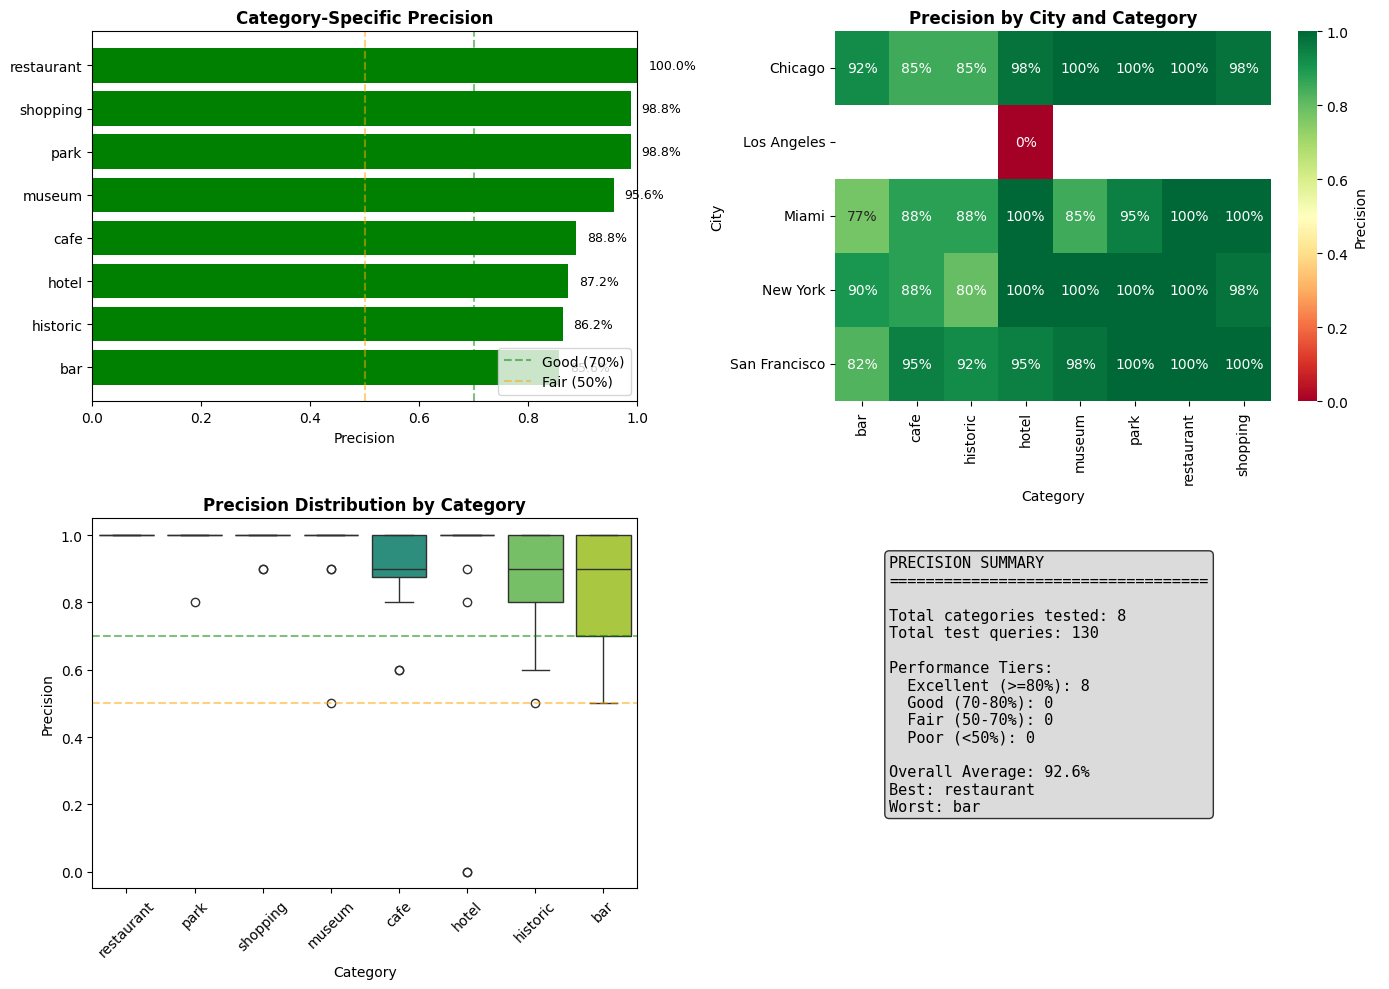


Category precision evaluation complete


In [16]:
# Cell 15: Category-Specific Precision Evaluation

def evaluate_category_precision(retriever):
    """Evaluate precision for specific categories across cities."""

    print("\nCATEGORY-SPECIFIC PRECISION EVALUATION")
    print("=" * 60)

    city_counts = Counter()
    for poi_id, poi in retriever.poi_cache.items():
        city_counts[poi.get('city', 'Unknown')] += 1

    available_cities = [city for city, count in city_counts.most_common(5)]
    print(f"Testing on cities: {', '.join(available_cities)}")

    category_tests = {
        'restaurant': {
            'queries': [
                'best restaurants',
                'places to eat',
                'dining options',
                'food and restaurants'
            ],
            'match_terms': ['restaurant', 'dining', 'food', 'bistro', 'eatery']
        },
        'museum': {
            'queries': [
                'museums to visit',
                'art museums',
                'history museums',
                'cultural museums'
            ],
            'match_terms': ['museum', 'gallery', 'exhibition']
        },
        'park': {
            'queries': [
                'parks nearby',
                'green spaces',
                'outdoor parks',
                'city parks'
            ],
            'match_terms': ['park', 'garden', 'green', 'playground']
        },
        'cafe': {
            'queries': [
                'coffee shops',
                'cafes nearby',
                'places for coffee',
                'cozy cafes'
            ],
            'match_terms': ['cafe', 'coffee', 'tea', 'bakery']
        },
        'bar': {
            'queries': [
                'bars nearby',
                'nightlife spots',
                'pubs and bars',
                'places for drinks'
            ],
            'match_terms': ['bar', 'pub', 'nightclub', 'lounge']
        },
        'hotel': {
            'queries': [
                'hotels nearby',
                'places to stay',
                'accommodation',
                'lodging options'
            ],
            'match_terms': ['hotel', 'motel', 'hostel', 'inn', 'lodge']
        },
        'historic': {
            'queries': [
                'historic sites',
                'historical landmarks',
                'monuments and memorials',
                'heritage sites'
            ],
            'match_terms': ['historic', 'memorial', 'monument', 'heritage', 'landmark']
        },
        'shopping': {
            'queries': [
                'shopping areas',
                'stores and shops',
                'malls nearby',
                'places to shop'
            ],
            'match_terms': ['shop', 'store', 'mall', 'market', 'supermarket', 'retail']
        }
    }

    all_results = []
    category_summaries = []

    for category, config in category_tests.items():
        print(f"\nCategory: {category.upper()}")
        print("-" * 50)

        category_precisions = []
        category_details = []

        for city in available_cities:
            city_precisions = []

            for query in config['queries']:
                full_query = f"{query} in {city}"

                try:
                    results = retriever.search(
                        full_query,
                        k=10,
                        filters={'city': city},
                        rerank=False
                    )

                    if not results:
                        continue

                    correct = 0
                    for poi in results:
                        poi_categories = poi.get('category', [])
                        if isinstance(poi_categories, str):
                            poi_categories = [poi_categories]

                        poi_cats_lower = ' '.join(poi_categories).lower()

                        for term in config['match_terms']:
                            if term in poi_cats_lower:
                                correct += 1
                                break

                    precision = correct / len(results)
                    city_precisions.append(precision)

                    category_details.append({
                        'category': category,
                        'city': city,
                        'query': query,
                        'precision': precision,
                        'correct': correct,
                        'total': len(results)
                    })

                except Exception as e:
                    print(f"   Error for '{full_query}': {str(e)[:30]}")
                    continue

            if city_precisions:
                city_avg = np.mean(city_precisions)
                category_precisions.extend(city_precisions)
                print(f"   {city}: {city_avg:.1%} precision ({len(city_precisions)} queries)")

        if category_precisions:
            avg_precision = np.mean(category_precisions)
            std_precision = np.std(category_precisions)
            min_precision = np.min(category_precisions)
            max_precision = np.max(category_precisions)

            category_summaries.append({
                'category': category,
                'avg_precision': avg_precision,
                'std_precision': std_precision,
                'min_precision': min_precision,
                'max_precision': max_precision,
                'num_tests': len(category_precisions)
            })

            print(f"   Overall: {avg_precision:.1%} +/- {std_precision:.1%}")
            print(f"      Range: [{min_precision:.1%} - {max_precision:.1%}]")

        all_results.extend(category_details)

    df_details = pd.DataFrame(all_results)
    df_summary = pd.DataFrame(category_summaries)

    print("\n" + "=" * 60)
    print("CATEGORY PRECISION SUMMARY")
    print("=" * 60)

    df_summary_sorted = df_summary.sort_values('avg_precision', ascending=False)

    print("\nCategories Ranked by Precision:")
    print("-" * 50)
    for _, row in df_summary_sorted.iterrows():
        bar_length = int(row['avg_precision'] * 30)
        bar = '#' * bar_length + '-' * (30 - bar_length)
        status = '[OK]' if row['avg_precision'] >= 0.7 else '[--]' if row['avg_precision'] >= 0.5 else '[!!]'
        print(f"   {status} {row['category']:12} {bar} {row['avg_precision']:.1%}")

    print("\nPrecision by City:")
    print("-" * 50)
    city_category_pivot = df_details.groupby(['city', 'category'])['precision'].mean().unstack()
    print(city_category_pivot.round(2).to_string())

    print("\nOverall Statistics:")
    print("-" * 50)
    print(f"   Average precision across all categories: {df_summary['avg_precision'].mean():.1%}")
    print(f"   Best performing category: {df_summary_sorted.iloc[0]['category']} ({df_summary_sorted.iloc[0]['avg_precision']:.1%})")
    print(f"   Worst performing category: {df_summary_sorted.iloc[-1]['category']} ({df_summary_sorted.iloc[-1]['avg_precision']:.1%})")
    print(f"   Categories above 70% precision: {len(df_summary[df_summary['avg_precision'] >= 0.7])}/{len(df_summary)}")

    problem_cases = df_details[df_details['precision'] < 0.5]
    if len(problem_cases) > 0:
        print(f"\nLow Precision Cases (< 50%):")
        print("-" * 50)
        for _, row in problem_cases.head(5).iterrows():
            print(f"   {row['city']} - '{row['query']}': {row['precision']:.1%}")

    return df_summary, df_details


def visualize_category_precision(df_summary, df_details):
    """Create visualizations for category precision."""

    print("\nGenerating Category Precision Visualizations...")

    fig, axes = plt.subplots(2, 2, figsize=(14, 10))

    ax1 = axes[0, 0]
    df_sorted = df_summary.sort_values('avg_precision', ascending=True)
    colors = ['green' if x >= 0.7 else 'orange' if x >= 0.5 else 'red'
              for x in df_sorted['avg_precision']]

    bars = ax1.barh(df_sorted['category'], df_sorted['avg_precision'], color=colors)
    ax1.set_xlabel('Precision')
    ax1.set_title('Category-Specific Precision', fontweight='bold')
    ax1.set_xlim(0, 1)
    ax1.axvline(x=0.7, color='green', linestyle='--', alpha=0.5, label='Good (70%)')
    ax1.axvline(x=0.5, color='orange', linestyle='--', alpha=0.5, label='Fair (50%)')
    ax1.legend(loc='lower right')

    for bar, val in zip(bars, df_sorted['avg_precision']):
        ax1.text(val + 0.02, bar.get_y() + bar.get_height()/2,
                f'{val:.1%}', va='center', fontsize=9)

    ax2 = axes[0, 1]
    pivot = df_details.groupby(['city', 'category'])['precision'].mean().unstack()

    sns.heatmap(pivot, annot=True, fmt='.0%', cmap='RdYlGn',
                vmin=0, vmax=1, ax=ax2, cbar_kws={'label': 'Precision'})
    ax2.set_title('Precision by City and Category', fontweight='bold')
    ax2.set_xlabel('Category')
    ax2.set_ylabel('City')

    ax3 = axes[1, 0]
    category_order = df_summary.sort_values('avg_precision', ascending=False)['category'].tolist()

    sns.boxplot(data=df_details, x='category', y='precision',
                order=category_order, ax=ax3, palette='viridis')
    ax3.set_xlabel('Category')
    ax3.set_ylabel('Precision')
    ax3.set_title('Precision Distribution by Category', fontweight='bold')
    ax3.tick_params(axis='x', rotation=45)
    ax3.axhline(y=0.7, color='green', linestyle='--', alpha=0.5)
    ax3.axhline(y=0.5, color='orange', linestyle='--', alpha=0.5)

    ax4 = axes[1, 1]
    ax4.axis('off')

    summary_text = "PRECISION SUMMARY\n" + "=" * 35 + "\n\n"
    summary_text += f"Total categories tested: {len(df_summary)}\n"
    summary_text += f"Total test queries: {len(df_details)}\n\n"

    summary_text += "Performance Tiers:\n"
    excellent = len(df_summary[df_summary['avg_precision'] >= 0.8])
    good = len(df_summary[(df_summary['avg_precision'] >= 0.7) & (df_summary['avg_precision'] < 0.8)])
    fair = len(df_summary[(df_summary['avg_precision'] >= 0.5) & (df_summary['avg_precision'] < 0.7)])
    poor = len(df_summary[df_summary['avg_precision'] < 0.5])

    summary_text += f"  Excellent (>=80%): {excellent}\n"
    summary_text += f"  Good (70-80%): {good}\n"
    summary_text += f"  Fair (50-70%): {fair}\n"
    summary_text += f"  Poor (<50%): {poor}\n\n"

    summary_text += f"Overall Average: {df_summary['avg_precision'].mean():.1%}\n"
    summary_text += f"Best: {df_summary.loc[df_summary['avg_precision'].idxmax(), 'category']}\n"
    summary_text += f"Worst: {df_summary.loc[df_summary['avg_precision'].idxmin(), 'category']}"

    ax4.text(0.1, 0.9, summary_text, transform=ax4.transAxes,
             fontsize=11, verticalalignment='top', fontfamily='monospace',
             bbox=dict(boxstyle='round', facecolor='lightgray', alpha=0.8))

    plt.tight_layout()
    plt.savefig('category_precision_analysis.png', dpi=150, bbox_inches='tight')
    print("Visualization saved as 'category_precision_analysis.png'")

    plt.show()

    return fig


print("Starting Category-Specific Precision Evaluation...\n")

if 'retriever' in dir():
    category_summary, category_details = evaluate_category_precision(retriever)

    if category_summary is not None:
        print("\n" + "=" * 60)

        try:
            fig = visualize_category_precision(category_summary, category_details)
        except Exception as e:
            print(f"Visualization error: {e}")

        print("\nCategory precision evaluation complete")
        print("=" * 60)
else:
    print("Retriever not found!")

Starting Feasibility and Efficiency Evaluation...


FEASIBILITY AND EFFICIENCY EVALUATION
Found 4 cities with sufficient POIs:
   New York: 26,187 POIs
   Chicago: 9,848 POIs
   San Francisco: 5,445 POIs
   Miami: 1,453 POIs

CITY: NEW YORK

  [1/5] Query: 'museums and cultural attractions'
      Budget: 6 hours
      Generated 4 stops
      Stops:
         1. Museum of Arts and Design [museum, tourism]
         2. Spyscape [attraction, tourism]
         3. The Noguchi Museum [museum, tourism]
         4. Wyckoff House Museum [attraction, tourism]

      Results:
         On-time rate: 100%
         Time: 10.6h / 6h (176% utilization)
         Route efficiency: 100%
         Diversity: 3 unique categories
         Duplicates: No

  [2/5] Query: 'restaurants and cafes'
      Budget: 5 hours
      Generated 5 stops
      Stops:
         1. The River Café [restaurant, amenity]
         2. Fanelli Cafe [restaurant, amenity]
         3. Café Bistro [fast_food, amenity]
         4. Bon Cafe 

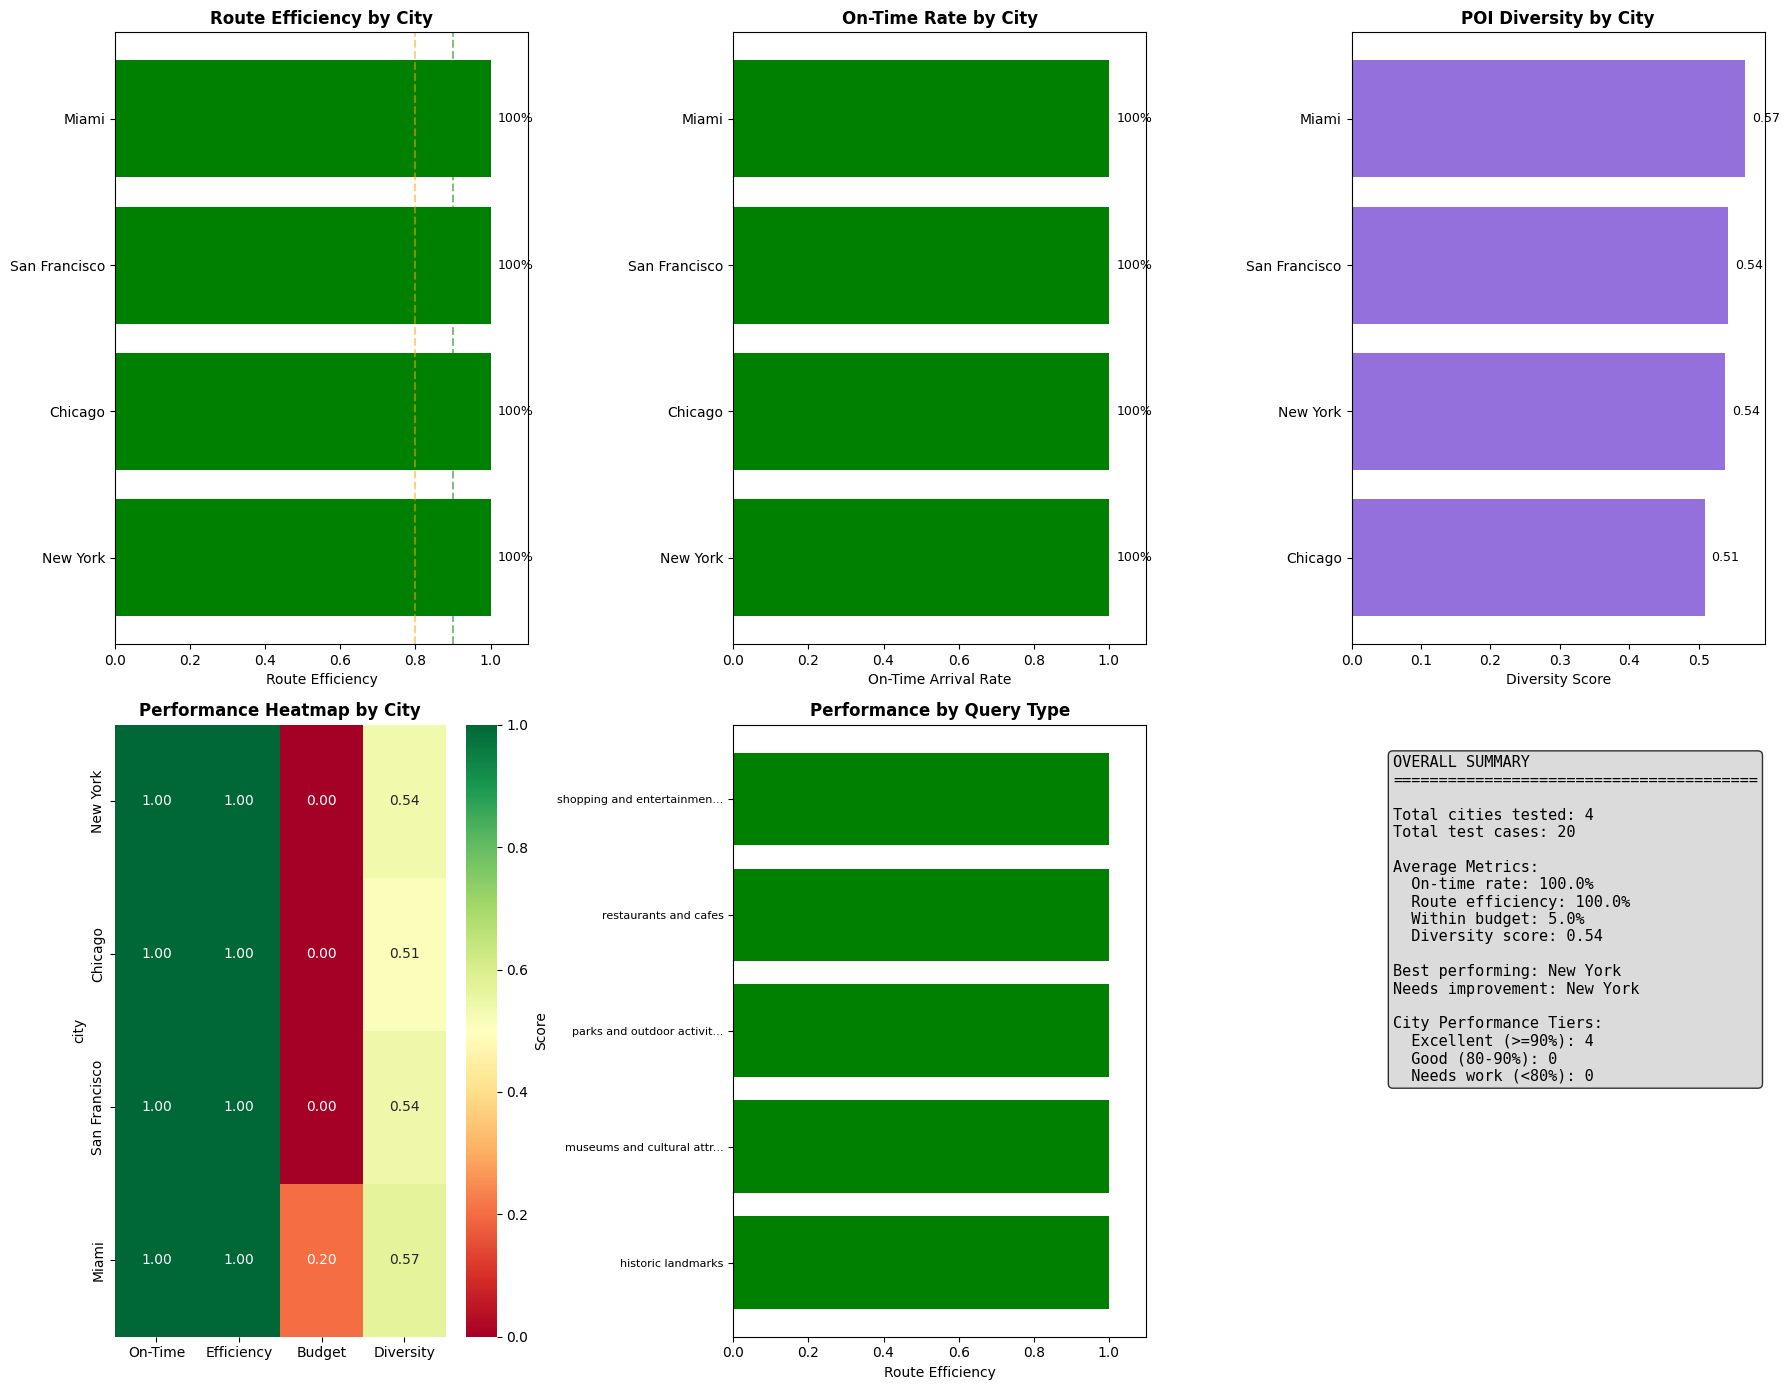


Feasibility evaluation complete


In [19]:
# Cell 16: Feasibility and Efficiency Evaluation

class DiverseItineraryGenerator:
    """Generate diverse itineraries avoiding repetition."""

    def __init__(self, retriever, constraint_solver):
        self.retriever = retriever
        self.constraint_solver = constraint_solver

        self.visit_durations = {
            'museum': 90, 'gallery': 60, 'restaurant': 75, 'cafe': 45,
            'bar': 60, 'pub': 60, 'park': 60, 'garden': 45,
            'monument': 30, 'memorial': 20, 'viewpoint': 30,
            'attraction': 60, 'historic': 45, 'tourism': 60,
            'hotel': 15, 'shop': 45, 'supermarket': 30,
            'fast_food': 30, 'default': 45
        }

    def get_visit_duration(self, poi: Dict) -> int:
        categories = poi.get('category', [])
        if isinstance(categories, str):
            categories = [categories]

        for cat in categories:
            cat_lower = cat.lower()
            for key, duration in self.visit_durations.items():
                if key in cat_lower:
                    return duration

        return self.visit_durations['default']

    def generate_diverse_itinerary(self, city: str, query: str,
                                    num_stops: int = 6,
                                    budget_hours: float = 6.0,
                                    transport_mode: str = 'walk') -> Dict:

        candidates = self.retriever.search(
            query,
            k=100,
            filters={'city': city},
            rerank=True,
            rerank_k=50
        )

        if not candidates:
            return {'status': 'error', 'message': f'No POIs found in {city}'}

        seen_names = set()
        unique_candidates = []

        for poi in candidates:
            name_key = poi.get('name', '').lower().strip()
            name_key = ''.join(c for c in name_key if c.isalnum())[:20]

            if name_key and name_key not in seen_names:
                seen_names.add(name_key)
                unique_candidates.append(poi)

        category_counts = defaultdict(int)
        max_per_category = 2

        diverse_candidates = []
        for poi in unique_candidates:
            categories = poi.get('category', ['other'])
            if isinstance(categories, str):
                categories = [categories]

            primary_cat = categories[0] if categories else 'other'

            if category_counts[primary_cat] < max_per_category:
                diverse_candidates.append(poi)
                category_counts[primary_cat] += 1

            if len(diverse_candidates) >= num_stops * 2:
                break

        selected_pois = diverse_candidates[:num_stops]

        if not selected_pois:
            return {'status': 'error', 'message': 'Could not select diverse POIs'}

        optimized_pois = self._optimize_route_order(selected_pois)

        itinerary = self._build_timed_itinerary(
            optimized_pois,
            start_hour=9,
            transport_mode=transport_mode
        )

        stats = self._calculate_stats(itinerary, transport_mode)

        return {
            'status': 'success',
            'city': city,
            'query': query,
            'itinerary': itinerary,
            'stats': stats,
            'categories_used': dict(category_counts)
        }

    def _optimize_route_order(self, pois: List[Dict]) -> List[Dict]:
        if len(pois) <= 2:
            return pois

        coords = [(poi['lat'], poi['lon']) for poi in pois]

        remaining = set(range(1, len(pois)))
        order = [0]
        current = 0

        while remaining:
            nearest = min(
                remaining,
                key=lambda i: self._haversine(
                    coords[current][0], coords[current][1],
                    coords[i][0], coords[i][1]
                )
            )
            order.append(nearest)
            current = nearest
            remaining.remove(nearest)

        return [pois[i] for i in order]

    def _haversine(self, lat1, lon1, lat2, lon2):
        R = 6371
        lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
        dlat, dlon = lat2 - lat1, lon2 - lon1
        a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
        return R * 2 * np.arcsin(np.sqrt(a))

    def _build_timed_itinerary(self, pois: List[Dict],
                                start_hour: int = 9,
                                transport_mode: str = 'walk') -> List[Dict]:

        speed_kmh = {'walk': 4.5, 'bike': 15, 'car': 30, 'transit': 20}.get(transport_mode, 4.5)

        itinerary = []
        current_time = datetime.combine(datetime.today(), time(start_hour, 0))

        for i, poi in enumerate(pois):
            if i > 0:
                prev_poi = pois[i-1]
                distance = self._haversine(
                    prev_poi['lat'], prev_poi['lon'],
                    poi['lat'], poi['lon']
                ) * 1.4

                travel_minutes = (distance / speed_kmh) * 60
                travel_distance = distance
            else:
                travel_minutes = 0
                travel_distance = 0

            current_time += timedelta(minutes=travel_minutes)
            arrival_time = current_time.time()

            duration = self.get_visit_duration(poi)

            current_time += timedelta(minutes=duration)
            departure_time = current_time.time()

            itinerary.append({
                'order': i + 1,
                'poi': poi,
                'arrival_time': arrival_time,
                'departure_time': departure_time,
                'duration_minutes': duration,
                'travel_from_previous': {
                    'minutes': round(travel_minutes, 1),
                    'distance_km': round(travel_distance, 2),
                    'mode': transport_mode
                }
            })

        return itinerary

    def _calculate_stats(self, itinerary: List[Dict], transport_mode: str) -> Dict:
        total_visit = sum(item['duration_minutes'] for item in itinerary)
        total_travel = sum(item['travel_from_previous']['minutes'] for item in itinerary)
        total_distance = sum(item['travel_from_previous']['distance_km'] for item in itinerary)

        return {
            'total_pois': len(itinerary),
            'total_time_minutes': total_visit + total_travel,
            'total_visit_minutes': total_visit,
            'total_travel_minutes': total_travel,
            'total_distance_km': round(total_distance, 2),
            'transport_mode': transport_mode
        }


class FeasibilityEvaluator:
    """Evaluate itinerary feasibility and efficiency."""

    def __init__(self):
        self.transport_speeds = {
            'walk': 4.5, 'bike': 15.0, 'car': 30.0, 'transit': 20.0
        }

    def haversine_distance(self, lat1, lon1, lat2, lon2):
        R = 6371
        lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
        dlat, dlon = lat2 - lat1, lon2 - lon1
        a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
        return R * 2 * np.arcsin(np.sqrt(a))

    def evaluate_on_time_arrivals(self, itinerary: List[Dict],
                                   transport_mode: str = 'walk',
                                   buffer_minutes: int = 5) -> Dict:

        if len(itinerary) < 2:
            return {
                'on_time_rate': 1.0, 'on_time_count': len(itinerary),
                'total_transitions': 0, 'late_arrivals': [],
                'avg_slack_minutes': 0
            }

        speed = self.transport_speeds.get(transport_mode, 4.5)
        on_time_count = 0
        late_arrivals = []
        slack_times = []

        for i in range(1, len(itinerary)):
            prev_item, curr_item = itinerary[i-1], itinerary[i]
            prev_poi, curr_poi = prev_item['poi'], curr_item['poi']

            distance_km = self.haversine_distance(
                prev_poi['lat'], prev_poi['lon'],
                curr_poi['lat'], curr_poi['lon']
            ) * 1.4

            required_travel_min = (distance_km / speed) * 60
            scheduled_travel_min = curr_item.get('travel_from_previous', {}).get('minutes', 15)

            slack = scheduled_travel_min - required_travel_min
            slack_times.append(slack)

            if slack >= -buffer_minutes:
                on_time_count += 1
            else:
                late_arrivals.append({
                    'from': prev_poi.get('name', 'Unknown')[:30],
                    'to': curr_poi.get('name', 'Unknown')[:30],
                    'distance_km': round(distance_km, 2),
                    'required_min': round(required_travel_min, 1),
                    'scheduled_min': round(scheduled_travel_min, 1),
                    'late_by_min': round(abs(slack), 1)
                })

        total_transitions = len(itinerary) - 1

        return {
            'on_time_rate': on_time_count / total_transitions if total_transitions > 0 else 1.0,
            'on_time_count': on_time_count,
            'total_transitions': total_transitions,
            'late_arrivals': late_arrivals,
            'avg_slack_minutes': np.mean(slack_times) if slack_times else 0
        }

    def evaluate_time_budget(self, itinerary: List[Dict], budget_hours: float = 8.0) -> Dict:

        if not itinerary:
            return {'within_budget': True, 'total_hours': 0, 'budget_hours': budget_hours, 'utilization': 0}

        total_visit = sum(item.get('duration_minutes', 45) for item in itinerary)
        total_travel = sum(item.get('travel_from_previous', {}).get('minutes', 0) for item in itinerary)

        total_hours = (total_visit + total_travel) / 60

        return {
            'within_budget': total_hours <= budget_hours,
            'total_hours': round(total_hours, 2),
            'budget_hours': budget_hours,
            'utilization': round(total_hours / budget_hours, 2) if budget_hours > 0 else 0,
            'overtime_hours': round(max(0, total_hours - budget_hours), 2),
            'visit_hours': round(total_visit / 60, 2),
            'travel_hours': round(total_travel / 60, 2)
        }

    def evaluate_route_efficiency(self, itinerary: List[Dict]) -> Dict:

        if len(itinerary) < 2:
            return {'efficiency': 1.0, 'actual_km': 0, 'optimal_km': 0, 'gap_km': 0}

        coords = [(item['poi']['lat'], item['poi']['lon']) for item in itinerary]

        actual_distance = sum(
            self.haversine_distance(coords[i-1][0], coords[i-1][1], coords[i][0], coords[i][1])
            for i in range(1, len(coords))
        )

        remaining = set(range(1, len(coords)))
        current = 0
        optimal_distance = 0

        while remaining:
            nearest = min(remaining, key=lambda i: self.haversine_distance(
                coords[current][0], coords[current][1], coords[i][0], coords[i][1]
            ))
            optimal_distance += self.haversine_distance(
                coords[current][0], coords[current][1], coords[nearest][0], coords[nearest][1]
            )
            current = nearest
            remaining.remove(nearest)

        actual_km, optimal_km = actual_distance * 1.4, optimal_distance * 1.4
        efficiency = optimal_km / actual_km if actual_km > 0 else 1.0

        return {
            'efficiency': round(min(efficiency, 1.0), 3),
            'actual_km': round(actual_km, 2),
            'optimal_km': round(optimal_km, 2),
            'gap_km': round(actual_km - optimal_km, 2),
            'is_optimal': efficiency >= 0.95
        }

    def evaluate_diversity(self, itinerary: List[Dict]) -> Dict:

        if not itinerary:
            return {'unique_categories': 0, 'diversity_score': 0}

        all_categories = []
        unique_names = set()

        for item in itinerary:
            poi = item['poi']
            unique_names.add(poi.get('name', '').lower().strip())

            cats = poi.get('category', [])
            if isinstance(cats, str):
                cats = [cats]
            all_categories.extend(cats)

        unique_categories = len(set(all_categories))
        category_counts = Counter(all_categories)

        max_possible = len(itinerary) * 2
        diversity_score = unique_categories / max_possible if max_possible > 0 else 0

        return {
            'unique_categories': unique_categories,
            'unique_pois': len(unique_names),
            'total_pois': len(itinerary),
            'diversity_score': round(diversity_score, 3),
            'category_distribution': dict(category_counts.most_common(10)),
            'has_duplicates': len(unique_names) < len(itinerary)
        }


def run_feasibility_evaluation_all_cities(retriever, constraint_solver=None):

    print("\nFEASIBILITY AND EFFICIENCY EVALUATION")
    print("=" * 70)

    itinerary_generator = DiverseItineraryGenerator(retriever, constraint_solver)
    evaluator = FeasibilityEvaluator()

    city_counts = Counter()
    for poi_id, poi in retriever.poi_cache.items():
        city_counts[poi.get('city', 'Unknown')] += 1

    all_cities = [city for city, count in city_counts.most_common() if count >= 50]

    print(f"Found {len(all_cities)} cities with sufficient POIs:")
    for city, count in city_counts.most_common():
        if count >= 50:
            print(f"   {city}: {count:,} POIs")

    test_queries = [
        {'query': 'museums and cultural attractions', 'budget_hours': 6},
        {'query': 'restaurants and cafes', 'budget_hours': 5},
        {'query': 'parks and outdoor activities', 'budget_hours': 4},
        {'query': 'historic landmarks', 'budget_hours': 5},
        {'query': 'shopping and entertainment', 'budget_hours': 6},
    ]

    all_results = []
    city_summaries = []

    for city in all_cities:
        print(f"\n{'='*70}")
        print(f"CITY: {city.upper()}")
        print(f"{'='*70}")

        city_results = []

        for q_idx, test_query in enumerate(test_queries):
            query = test_query['query']
            budget_hours = test_query['budget_hours']

            print(f"\n  [{q_idx+1}/{len(test_queries)}] Query: '{query}'")
            print(f"      Budget: {budget_hours} hours")

            try:
                result = itinerary_generator.generate_diverse_itinerary(
                    city=city,
                    query=query,
                    num_stops=6,
                    budget_hours=budget_hours,
                    transport_mode='walk'
                )

                if result['status'] != 'success':
                    print(f"      Failed: {result.get('message', 'Unknown error')}")
                    continue

                itinerary = result['itinerary']
                print(f"      Generated {len(itinerary)} stops")

                print(f"      Stops:")
                for item in itinerary:
                    poi = item['poi']
                    cats = poi.get('category', [])[:2]
                    print(f"         {item['order']}. {poi['name'][:40]} [{', '.join(cats)}]")

            except Exception as e:
                print(f"      Error: {str(e)[:50]}")
                continue

            on_time_eval = evaluator.evaluate_on_time_arrivals(itinerary, 'walk')
            budget_eval = evaluator.evaluate_time_budget(itinerary, budget_hours)
            efficiency_eval = evaluator.evaluate_route_efficiency(itinerary)
            diversity_eval = evaluator.evaluate_diversity(itinerary)

            print(f"\n      Results:")
            print(f"         On-time rate: {on_time_eval['on_time_rate']:.0%}")
            print(f"         Time: {budget_eval['total_hours']:.1f}h / {budget_hours}h ({budget_eval['utilization']:.0%} utilization)")
            print(f"         Route efficiency: {efficiency_eval['efficiency']:.0%}")
            print(f"         Diversity: {diversity_eval['unique_categories']} unique categories")
            print(f"         Duplicates: {'Yes' if diversity_eval['has_duplicates'] else 'No'}")

            result_entry = {
                'city': city,
                'query': query,
                'budget_hours': budget_hours,
                'num_stops': len(itinerary),
                'on_time_rate': on_time_eval['on_time_rate'],
                'time_utilization': budget_eval['utilization'],
                'within_budget': budget_eval['within_budget'],
                'total_hours': budget_eval['total_hours'],
                'route_efficiency': efficiency_eval['efficiency'],
                'actual_km': efficiency_eval['actual_km'],
                'optimal_km': efficiency_eval['optimal_km'],
                'is_optimal_route': efficiency_eval['is_optimal'],
                'unique_categories': diversity_eval['unique_categories'],
                'diversity_score': diversity_eval['diversity_score'],
                'has_duplicates': diversity_eval['has_duplicates']
            }

            city_results.append(result_entry)
            all_results.append(result_entry)

        if city_results:
            df_city = pd.DataFrame(city_results)
            city_summaries.append({
                'city': city,
                'num_tests': len(city_results),
                'avg_on_time_rate': df_city['on_time_rate'].mean(),
                'avg_time_utilization': df_city['time_utilization'].mean(),
                'within_budget_rate': df_city['within_budget'].mean(),
                'avg_route_efficiency': df_city['route_efficiency'].mean(),
                'avg_diversity_score': df_city['diversity_score'].mean(),
                'duplicate_rate': df_city['has_duplicates'].mean()
            })

            print(f"\n  {city} Summary:")
            print(f"     Avg on-time rate: {df_city['on_time_rate'].mean():.0%}")
            print(f"     Avg route efficiency: {df_city['route_efficiency'].mean():.0%}")
            print(f"     Within budget: {df_city['within_budget'].mean():.0%}")
            print(f"     Avg diversity: {df_city['diversity_score'].mean():.2f}")

    df_results = pd.DataFrame(all_results)
    df_city_summary = pd.DataFrame(city_summaries)

    print("\n" + "=" * 70)
    print("COMPREHENSIVE FEASIBILITY SUMMARY")
    print("=" * 70)

    if len(df_results) > 0:
        print(f"\nOverall Statistics ({len(df_results)} test cases across {len(all_cities)} cities):")
        print("-" * 50)
        print(f"   Average on-time rate: {df_results['on_time_rate'].mean():.1%}")
        print(f"   Average time utilization: {df_results['time_utilization'].mean():.0%}")
        print(f"   Within budget rate: {df_results['within_budget'].mean():.1%}")
        print(f"   Average route efficiency: {df_results['route_efficiency'].mean():.1%}")
        print(f"   Average diversity score: {df_results['diversity_score'].mean():.2f}")
        print(f"   Duplicate-free rate: {(1 - df_results['has_duplicates'].mean()):.1%}")

        print(f"\nPer-City Performance:")
        print("-" * 50)

        df_city_summary_sorted = df_city_summary.sort_values('avg_route_efficiency', ascending=False)

        for _, row in df_city_summary_sorted.iterrows():
            status = '[++]' if row['avg_route_efficiency'] >= 0.9 else '[OK]' if row['avg_route_efficiency'] >= 0.8 else '[--]'
            print(f"   {status} {row['city']}: "
                  f"Efficiency={row['avg_route_efficiency']:.0%}, "
                  f"On-time={row['avg_on_time_rate']:.0%}, "
                  f"Budget={row['within_budget_rate']:.0%}, "
                  f"Diversity={row['avg_diversity_score']:.2f}")

        print(f"\nPerformance by Query Type:")
        print("-" * 50)
        query_summary = df_results.groupby('query').agg({
            'on_time_rate': 'mean',
            'route_efficiency': 'mean',
            'within_budget': 'mean',
            'diversity_score': 'mean'
        }).round(2)
        print(query_summary.to_string())

    return df_results, df_city_summary


def visualize_all_cities_feasibility(df_results, df_city_summary):

    print("\nGenerating Comprehensive Visualizations...")

    fig = plt.figure(figsize=(18, 14))

    ax1 = fig.add_subplot(2, 3, 1)
    df_sorted = df_city_summary.sort_values('avg_route_efficiency', ascending=True)
    colors = ['green' if x >= 0.9 else 'orange' if x >= 0.8 else 'red'
              for x in df_sorted['avg_route_efficiency']]

    bars = ax1.barh(df_sorted['city'], df_sorted['avg_route_efficiency'], color=colors)
    ax1.set_xlabel('Route Efficiency')
    ax1.set_title('Route Efficiency by City', fontweight='bold')
    ax1.set_xlim(0, 1.1)
    ax1.axvline(x=0.9, color='green', linestyle='--', alpha=0.5)
    ax1.axvline(x=0.8, color='orange', linestyle='--', alpha=0.5)

    for bar, val in zip(bars, df_sorted['avg_route_efficiency']):
        ax1.text(val + 0.02, bar.get_y() + bar.get_height()/2,
                f'{val:.0%}', va='center', fontsize=9)

    ax2 = fig.add_subplot(2, 3, 2)
    df_sorted = df_city_summary.sort_values('avg_on_time_rate', ascending=True)
    colors = ['green' if x >= 0.9 else 'orange' if x >= 0.8 else 'red'
              for x in df_sorted['avg_on_time_rate']]

    bars = ax2.barh(df_sorted['city'], df_sorted['avg_on_time_rate'], color=colors)
    ax2.set_xlabel('On-Time Arrival Rate')
    ax2.set_title('On-Time Rate by City', fontweight='bold')
    ax2.set_xlim(0, 1.1)

    for bar, val in zip(bars, df_sorted['avg_on_time_rate']):
        ax2.text(val + 0.02, bar.get_y() + bar.get_height()/2,
                f'{val:.0%}', va='center', fontsize=9)

    ax3 = fig.add_subplot(2, 3, 3)
    df_sorted = df_city_summary.sort_values('avg_diversity_score', ascending=True)

    bars = ax3.barh(df_sorted['city'], df_sorted['avg_diversity_score'], color='mediumpurple')
    ax3.set_xlabel('Diversity Score')
    ax3.set_title('POI Diversity by City', fontweight='bold')

    for bar, val in zip(bars, df_sorted['avg_diversity_score']):
        ax3.text(val + 0.01, bar.get_y() + bar.get_height()/2,
                f'{val:.2f}', va='center', fontsize=9)

    ax4 = fig.add_subplot(2, 3, 4)

    heatmap_data = df_city_summary.set_index('city')[
        ['avg_on_time_rate', 'avg_route_efficiency', 'within_budget_rate', 'avg_diversity_score']
    ]
    heatmap_data.columns = ['On-Time', 'Efficiency', 'Budget', 'Diversity']

    sns.heatmap(heatmap_data, annot=True, fmt='.2f', cmap='RdYlGn',
                vmin=0, vmax=1, ax=ax4, cbar_kws={'label': 'Score'})
    ax4.set_title('Performance Heatmap by City', fontweight='bold')

    ax5 = fig.add_subplot(2, 3, 5)

    query_perf = df_results.groupby('query')['route_efficiency'].mean().sort_values()
    colors = ['green' if x >= 0.9 else 'orange' if x >= 0.8 else 'red' for x in query_perf]

    bars = ax5.barh(range(len(query_perf)), query_perf.values, color=colors)
    ax5.set_yticks(range(len(query_perf)))
    ax5.set_yticklabels([q[:25] + '...' if len(q) > 25 else q for q in query_perf.index], fontsize=8)
    ax5.set_xlabel('Route Efficiency')
    ax5.set_title('Performance by Query Type', fontweight='bold')
    ax5.set_xlim(0, 1.1)

    ax6 = fig.add_subplot(2, 3, 6)
    ax6.axis('off')

    summary_text = "OVERALL SUMMARY\n" + "=" * 40 + "\n\n"
    summary_text += f"Total cities tested: {len(df_city_summary)}\n"
    summary_text += f"Total test cases: {len(df_results)}\n\n"

    summary_text += "Average Metrics:\n"
    summary_text += f"  On-time rate: {df_results['on_time_rate'].mean():.1%}\n"
    summary_text += f"  Route efficiency: {df_results['route_efficiency'].mean():.1%}\n"
    summary_text += f"  Within budget: {df_results['within_budget'].mean():.1%}\n"
    summary_text += f"  Diversity score: {df_results['diversity_score'].mean():.2f}\n\n"

    best_city = df_city_summary.loc[df_city_summary['avg_route_efficiency'].idxmax(), 'city']
    worst_city = df_city_summary.loc[df_city_summary['avg_route_efficiency'].idxmin(), 'city']

    summary_text += f"Best performing: {best_city}\n"
    summary_text += f"Needs improvement: {worst_city}\n\n"

    excellent = len(df_city_summary[df_city_summary['avg_route_efficiency'] >= 0.9])
    good = len(df_city_summary[(df_city_summary['avg_route_efficiency'] >= 0.8) &
                               (df_city_summary['avg_route_efficiency'] < 0.9)])
    fair = len(df_city_summary[df_city_summary['avg_route_efficiency'] < 0.8])

    summary_text += "City Performance Tiers:\n"
    summary_text += f"  Excellent (>=90%): {excellent}\n"
    summary_text += f"  Good (80-90%): {good}\n"
    summary_text += f"  Needs work (<80%): {fair}"

    ax6.text(0.1, 0.95, summary_text, transform=ax6.transAxes,
             fontsize=11, verticalalignment='top', fontfamily='monospace',
             bbox=dict(boxstyle='round', facecolor='lightgray', alpha=0.8))

    plt.tight_layout()
    plt.savefig('feasibility_all_cities.png', dpi=150, bbox_inches='tight')
    print("Visualization saved as 'feasibility_all_cities.png'")

    plt.show()

    return fig


print("Starting Feasibility and Efficiency Evaluation...\n")

if 'retriever' in dir():
    cs = constraint_solver if 'constraint_solver' in dir() else None

    feasibility_results, city_summary = run_feasibility_evaluation_all_cities(retriever, cs)

    if feasibility_results is not None and len(feasibility_results) > 0:
        print("\n" + "=" * 70)

        try:
            fig = visualize_all_cities_feasibility(feasibility_results, city_summary)
        except Exception as e:
            print(f"Visualization error: {e}")
            import traceback
            traceback.print_exc()

        print("\nFeasibility evaluation complete")
        print("=" * 70)
else:
    print("Retriever not found!")

Starting RAG quality evaluation.
RAG quality evaluation starting.
Evaluating 4 cities.

City: New York
  Query: museums and cultural sites
    Results for 5 POIs:
      Faithfulness: 1.00
      Citation accuracy: 1.00
      Total hallucinations: 0 (0.00 per POI)
      Explanation quality: 0.87
    Sample explanations:
      - Yeshiva University Museum
        "Explore exhibits at this museum in New York. Jewish cultural institution in New...."
        citations: 2
      - Spyscape
        "A local spot that showcases something of interest in New York...."
        citations: 2
  Query: restaurants and dining
    Results for 3 POIs:
      Faithfulness: 1.00
      Citation accuracy: 1.00
      Total hallucinations: 0 (0.00 per POI)
      Explanation quality: 0.62
    Sample explanations:
      - Sarge's Delicatessan & Diner
        "This restaurant serves jewish;diner dishes in a welcoming atmosphere. restaurant in Manhattan, New...."
        citations: 2
      - B&B Restaurant
        "A

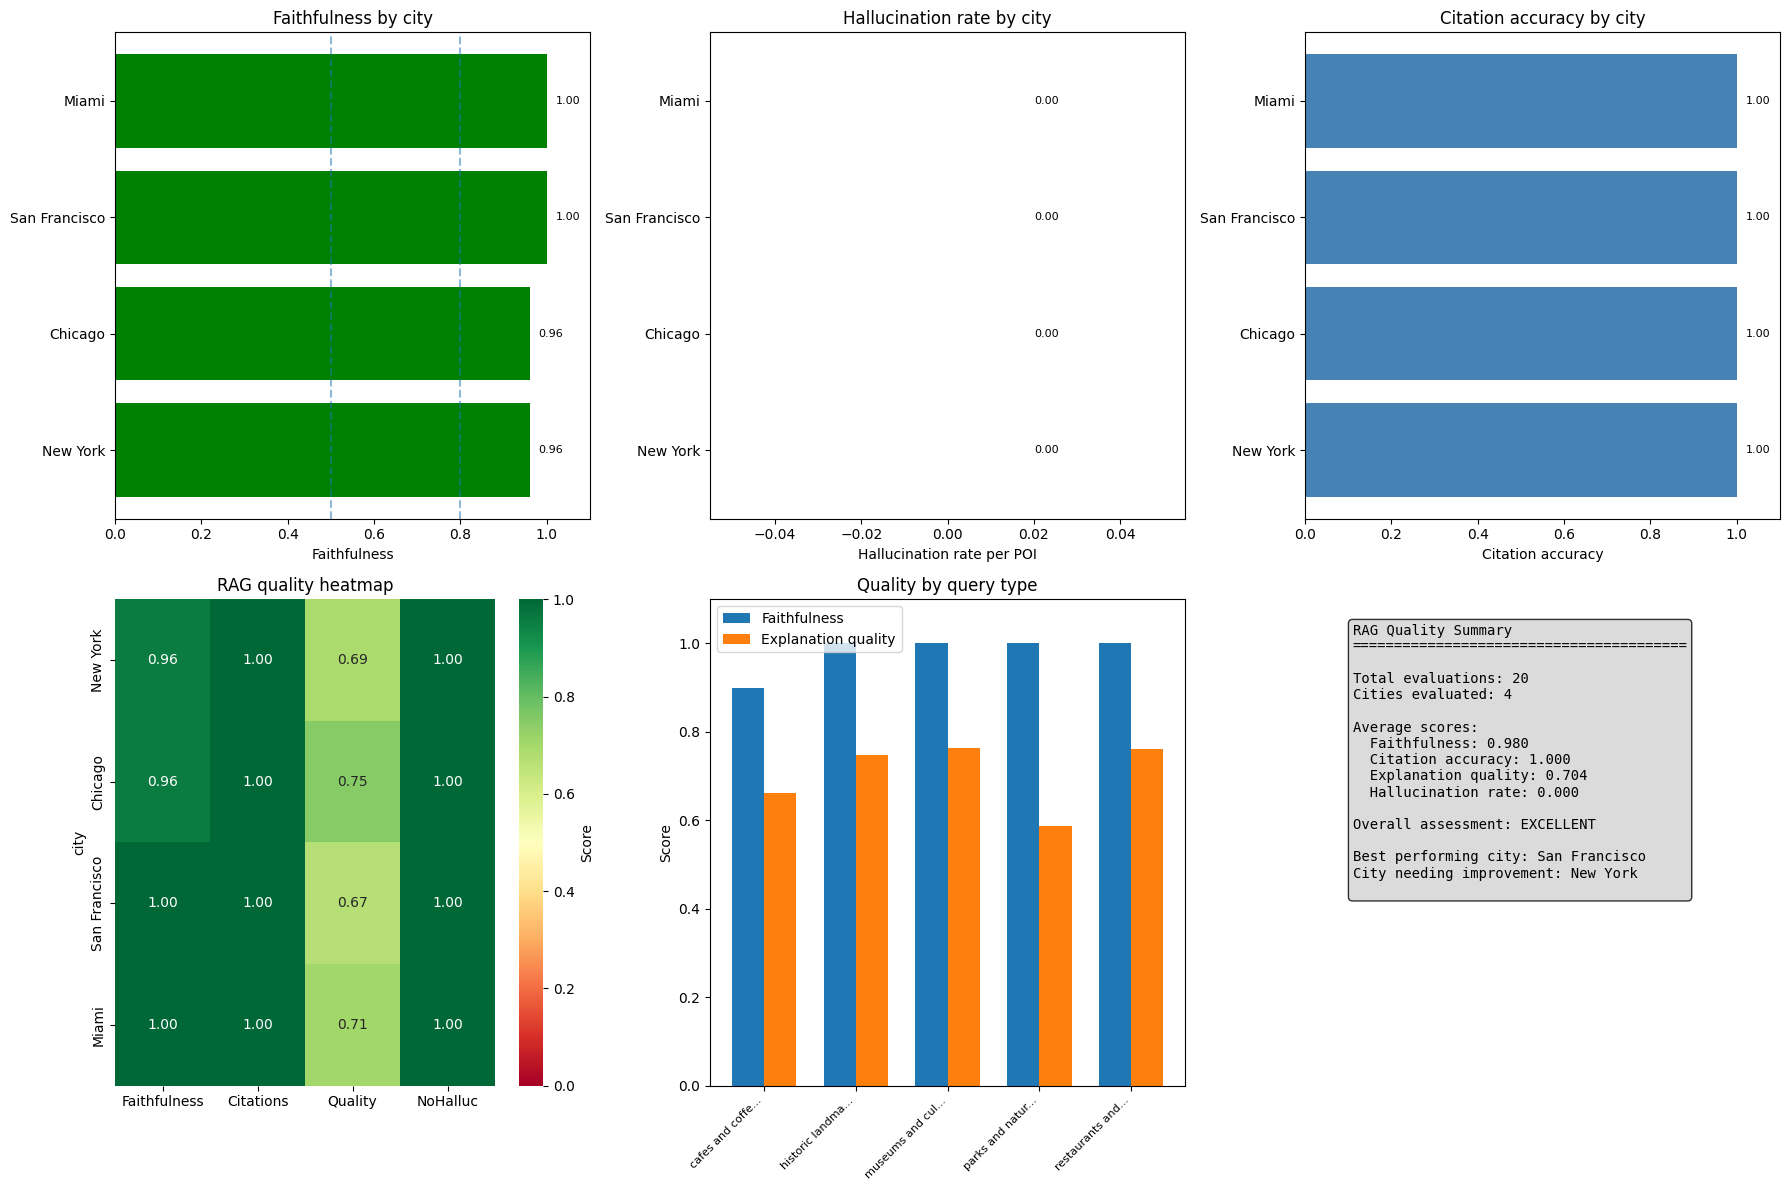

RAG quality evaluation complete.


In [20]:
# Cell 17: RAG quality evaluation
# Evaluates faithfulness, citation accuracy, and hallucination detection

from typing import Dict, List
import re
import numpy as np
import pandas as pd
from collections import Counter
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import traceback

class RAGQualityEvaluator:
    """Check RAG outputs for faithfulness, citation quality, and hallucinations."""

    def __init__(self):
        # Phrases that should be backed by sources if used in descriptions
        self.unsupported_claim_indicators = [
            'world famous', 'world-famous', 'world renowned', 'world-renowned',
            'best in the world', 'best in class', 'number one', '#1',
            'most popular', 'most visited', 'most famous',
            'award winning', 'award-winning', 'michelin star', 'michelin-starred',
            'five star', '5-star', 'five-star', 'luxury',
            'celebrity favorite', 'celebrity favourite', 'celebrity hotspot',
            'instagram worthy', 'instagrammable', 'iconic',
            'must visit', 'must-visit', 'must see', 'must-see',
            'legendary', 'world-class', 'internationally acclaimed',
            'critically acclaimed', 'highly rated', 'top rated', 'top-rated',
            'unforgettable', 'breathtaking', 'stunning', 'spectacular',
            'unparalleled', 'unmatched', 'unrivaled', 'unique'
        ]

        # Regex patterns for factual claims that should be verifiable
        self.factual_patterns = [
            r'founded in \d{4}',
            r'built in \d{4}',
            r'established in \d{4}',
            r'opened in \d{4}',
            r'\d+ years old',
            r'\d+ million visitors',
            r'\d+ stars?',
            r'rated \d(\.\d)?',
            r'\$\d+',
            r'\d+ floors?',
            r'\d+ rooms?',
        ]

    def extract_poi_facts(self, poi: Dict) -> Dict:
        """Pull out standardized, lower-cased facts from a POI record."""

        facts = {
            'name': poi.get('name', '').lower(),
            'categories': [],
            'tags': {},
            'description_keywords': set(),
            'location': {
                'city': poi.get('city', '').lower(),
                'country': poi.get('country', '').lower()
            }
        }

        # Normalize categories
        categories = poi.get('category', [])
        if isinstance(categories, str):
            categories = [categories]
        facts['categories'] = [c.lower() for c in categories if c]

        # Normalize tags to lower-case strings
        tags = poi.get('tags', {})
        if isinstance(tags, dict):
            facts['tags'] = {k.lower(): str(v).lower() for k, v in tags.items()}

        # Extract simple keywords from description
        description = poi.get('description', '')
        if description:
            words = re.findall(r"\w+", description.lower())
            facts['description_keywords'] = set(w for w in words if len(w) > 3)

        # Optional fields
        if poi.get('cuisine'):
            facts['cuisine'] = str(poi['cuisine']).lower()
        if poi.get('rating') is not None:
            facts['rating'] = poi['rating']
        if poi.get('website'):
            facts['has_website'] = True
        if poi.get('phone'):
            facts['has_phone'] = True
        if poi.get('opening_hours'):
            facts['has_hours'] = True
            facts['opening_hours'] = poi['opening_hours']

        return facts

    def check_claim_support(self, claim: str, poi_facts: Dict) -> Dict:
        """Return which parts of a claim are supported by the supplied POI facts."""

        claim_lower = (claim or "").lower()
        supported = []
        unsupported = []

        # Name match
        name = poi_facts.get('name', '')
        if name and name in claim_lower:
            supported.append(f"name: {name}")

        # Category mentions
        for cat in poi_facts.get('categories', []):
            if cat and cat in claim_lower:
                supported.append(f"category: {cat}")

        # City mention
        city = poi_facts.get('location', {}).get('city', '')
        if city and city in claim_lower:
            supported.append(f"city: {city}")

        # Unsupported superlatives
        for indicator in self.unsupported_claim_indicators:
            if indicator in claim_lower:
                # consider it supported only if it appears in description keywords or tags
                in_description = any(indicator in kw for kw in poi_facts.get('description_keywords', []))
                tag_text = ' '.join(str(v) for v in poi_facts.get('tags', {}).values())
                in_tags = indicator in tag_text
                if not (in_description or in_tags):
                    unsupported.append(indicator)

        total = len(supported) + len(unsupported)
        score = len(supported) / max(total, 1)

        return {
            'support_score': score,
            'supported_facts': supported,
            'unsupported_claims': unsupported,
            'num_supported': len(supported),
            'num_unsupported': len(unsupported),
            'is_faithful': len(unsupported) == 0
        }

    def evaluate_citation_accuracy(self, poi: Dict, citations: List[Dict]) -> Dict:
        """Check presence and likely validity of citations."""

        results = {
            'has_citations': bool(citations),
            'num_citations': len(citations),
            'citation_sources': [],
            'valid_citations': 0,
            'citation_types': []
        }

        for cit in citations:
            source = cit.get('source', 'unknown')
            results['citation_sources'].append(source)
            results['citation_types'].append(cit.get('type', 'unknown'))

            url = cit.get('url', '') or ''
            # Simple heuristics for validity
            if poi.get('source') == 'osm' and 'openstreetmap.org' in url:
                results['valid_citations'] += 1
            elif poi.get('wikidata_id') and 'wikidata.org' in url:
                results['valid_citations'] += 1
            elif url:
                # partial credit for any URL
                results['valid_citations'] += 0.5

        if results['num_citations'] > 0:
            results['citation_accuracy'] = results['valid_citations'] / results['num_citations']
        else:
            results['citation_accuracy'] = 0.0

        return results

    def detect_hallucinations(self, explanation: str, poi: Dict) -> Dict:
        """Detect likely hallucinations in an explanation relative to POI data."""

        explanation_lower = (explanation or "").lower()
        poi_facts = self.extract_poi_facts(poi)

        halluc = {
            'superlative_hallucinations': [],
            'factual_hallucinations': [],
            'entity_hallucinations': [],
            'total_hallucinations': 0,
            'hallucination_severity': 'none'
        }

        # Unsupported superlatives
        source_text = ' '.join([
            poi.get('description', '') or '',
            ' '.join(str(v) for v in poi.get('tags', {}).values()) if poi.get('tags') else ''
        ]).lower()

        for indicator in self.unsupported_claim_indicators:
            if indicator in explanation_lower and indicator not in source_text:
                halluc['superlative_hallucinations'].append({
                    'claim': indicator,
                    'type': 'unsupported_superlative'
                })

        # Unverified factual claims
        for pattern in self.factual_patterns:
            matches = re.findall(pattern, explanation_lower)
            for match in matches:
                if match not in source_text:
                    halluc['factual_hallucinations'].append({
                        'claim': match,
                        'type': 'unverified_fact'
                    })

        # Entity mentions: avoid aggressive flagging to reduce false positives
        # (This is a conservative placeholder; more advanced entity linking would be better.)
        # We intentionally do not add many entity flags here.

        total = (
            len(halluc['superlative_hallucinations'])
            + len(halluc['factual_hallucinations'])
            + len(halluc['entity_hallucinations'])
        )
        halluc['total_hallucinations'] = total

        if total == 0:
            severity = 'none'
        elif total == 1:
            severity = 'low'
        elif total <= 3:
            severity = 'medium'
        else:
            severity = 'high'

        halluc['hallucination_severity'] = severity
        return halluc

    def evaluate_explanation_quality(self, explanation: str, poi: Dict) -> Dict:
        """Score explanation length and relevance against POI attributes."""

        text = (explanation or "").strip()
        words = re.findall(r"\w+", text)
        word_count = len(words)
        sentence_count = len([s for s in text.split('.') if s.strip()])

        # Length heuristic
        if word_count < 10:
            length_score = 0.5
        elif word_count > 100:
            length_score = 0.7
        else:
            length_score = 1.0

        # Relevance heuristic
        relevance = 0.0
        poi_name = poi.get('name', '').lower()
        categories = poi.get('category', [])
        if isinstance(categories, str):
            categories = [categories]
        explanation_lower = text.lower()

        if poi_name and any(part in explanation_lower for part in poi_name.split()[:2]):
            relevance += 0.3

        for cat in categories:
            if cat and cat.lower() in explanation_lower:
                relevance += 0.2
                break

        city = poi.get('city', '').lower()
        if city and city in explanation_lower:
            relevance += 0.2

        informative_words = ['experience', 'enjoy', 'discover', 'explore', 'visit',
                             'offers', 'features', 'known for', 'famous', 'popular']
        if any(word in explanation_lower for word in informative_words):
            relevance += 0.3

        relevance = min(relevance, 1.0)

        overall = (length_score + relevance) / 2.0

        return {
            'word_count': word_count,
            'sentence_count': sentence_count,
            'length_score': length_score,
            'relevance_score': relevance,
            'overall_quality': overall
        }

    def calculate_faithfulness_score(self, itinerary: List[Dict]) -> Dict:
        """Aggregate faithfulness, citation accuracy and hallucination stats for an itinerary."""

        if not itinerary:
            return {
                'avg_faithfulness': 0.0,
                'avg_citation_accuracy': 0.0,
                'total_hallucinations': 0,
                'hallucination_rate': 0.0,
                'avg_explanation_quality': 0.0
            }

        faith_scores = []
        citation_scores = []
        halluc_counts = []
        quality_scores = []
        detailed = []

        for item in itinerary:
            explanation = item.get('explanation', '')
            poi = item.get('poi', {}) or {}
            citations = item.get('citations', []) or []

            facts = self.extract_poi_facts(poi)
            claim_result = self.check_claim_support(explanation, facts)
            faith_scores.append(claim_result['support_score'])

            cit_result = self.evaluate_citation_accuracy(poi, citations)
            citation_scores.append(cit_result['citation_accuracy'])

            hall_result = self.detect_hallucinations(explanation, poi)
            halluc_counts.append(hall_result['total_hallucinations'])

            qual_result = self.evaluate_explanation_quality(explanation, poi)
            quality_scores.append(qual_result['overall_quality'])

            detailed.append({
                'poi_name': poi.get('name', 'Unknown'),
                'faithfulness': claim_result['support_score'],
                'citation_accuracy': cit_result['citation_accuracy'],
                'hallucinations': hall_result['total_hallucinations'],
                'hallucination_severity': hall_result['hallucination_severity'],
                'explanation_quality': qual_result['overall_quality'],
                'unsupported_claims': claim_result['unsupported_claims'],
                'hallucination_details': hall_result
            })

        n = len(itinerary)
        total_hallucinations = sum(halluc_counts)

        return {
            'avg_faithfulness': float(np.mean(faith_scores)),
            'avg_citation_accuracy': float(np.mean(citation_scores)),
            'total_hallucinations': int(total_hallucinations),
            'hallucination_rate': float(total_hallucinations) / n if n > 0 else 0.0,
            'avg_explanation_quality': float(np.mean(quality_scores)),
            'items_with_hallucinations': int(sum(1 for h in halluc_counts if h > 0)),
            'detailed_results': detailed
        }


class RAGExplanationGenerator:
    """A small helper to generate example explanations and citations."""

    def __init__(self):
        self.templates = {
            'restaurant': [
                "A popular {category} offering {cuisine} cuisine in the heart of {city}.",
                "Experience authentic {cuisine} flavors at this {city} restaurant.",
                "This {category} serves {cuisine} dishes in a welcoming atmosphere."
            ],
            'museum': [
                "Explore exhibits at this {category} in {city}.",
                "A cultural site with notable collections in {city}.",
                "Discover history and art at this {city} {category}."
            ],
            'park': [
                "A green space for relaxation and outdoor activities in {city}.",
                "A peaceful park with scenic views located in {city}.",
                "This {category} offers walking paths and open areas in {city}."
            ],
            'cafe': [
                "A cozy spot for coffee and light bites in {city}.",
                "Enjoy beverages and snacks at this small {city} cafe.",
                "Popular with locals for its atmosphere and drinks."
            ],
            'historic': [
                "A historic site with significance to {city}.",
                "This landmark highlights {city}'s heritage.",
                "Explore the history and notable features of this site."
            ],
            'default': [
                "A destination worth visiting in {city}.",
                "A local spot that showcases something of interest in {city}.",
                "Consider visiting this {category} while in {city}."
            ]
        }

    def generate_explanation(self, poi: Dict, query: str = '') -> str:
        """Create a short, template-based explanation for a POI."""

        categories = poi.get('category', ['attraction'])
        if isinstance(categories, str):
            categories = [categories]

        primary_cat = categories[0].lower() if categories else 'attraction'
        city = poi.get('city', 'the city')
        cuisine = poi.get('cuisine') or poi.get('tags', {}).get('cuisine', 'local')

        # choose a template that matches the category if possible
        template_key = 'default'
        for key in self.templates:
            if key in primary_cat:
                template_key = key
                break

        templates = self.templates.get(template_key, self.templates['default'])
        template = np.random.choice(templates)
        explanation = template.format(category=primary_cat, city=city, cuisine=cuisine)

        # append a short snippet from the description if available
        description = poi.get('description', '') or ''
        if len(description) > 20:
            snippet = description[:100].rsplit(' ', 1)[0]
            explanation = f"{explanation} {snippet}."

        return explanation

    def generate_citations(self, poi: Dict) -> List[Dict]:
        """Create simple citation objects based on POI metadata."""

        citations = []
        source = poi.get('source', 'unknown')
        source_id = poi.get('source_id', '')

        if source == 'osm' and source_id:
            parts = source_id.replace('osm_', '').split('_')
            if len(parts) >= 2:
                osm_type, osm_id = parts[0], parts[1]
                citations.append({
                    'source': 'OpenStreetMap',
                    'type': 'primary',
                    'url': f"https://www.openstreetmap.org/{osm_type}/{osm_id}",
                    'retrieved': datetime.now().isoformat()
                })

        if poi.get('wikidata_id'):
            citations.append({
                'source': 'Wikidata',
                'type': 'enrichment',
                'url': f"https://www.wikidata.org/wiki/{poi['wikidata_id']}",
                'retrieved': datetime.now().isoformat()
            })

        return citations


def run_rag_quality_evaluation(retriever, itinerary_generator):
    """Run a full RAG quality pass across popular cities and queries."""

    print("RAG quality evaluation starting.")
    evaluator = RAGQualityEvaluator()
    explanation_gen = RAGExplanationGenerator()

    # Count POIs per city
    city_counts = Counter()
    for poi_id, poi in getattr(retriever, "poi_cache", {}).items():
        city_counts[poi.get('city', 'Unknown')] += 1

    # consider only cities with a reasonable number of POIs
    all_cities = [city for city, count in city_counts.most_common() if count >= 50]
    print(f"Evaluating {len(all_cities)} cities.")

    test_queries = [
        'museums and cultural sites',
        'restaurants and dining',
        'parks and nature',
        'historic landmarks',
        'cafes and coffee shops'
    ]

    all_results = []
    city_results = []
    all_hallucinations = []

    for city in all_cities:
        print("\n" + "=" * 50)
        print(f"City: {city}")
        print("=" * 50)

        city_faith = []
        city_citations = []
        city_halluc = []
        city_quality = []

        for query in test_queries:
            print(f"  Query: {query}")

            try:
                result = itinerary_generator.generate_diverse_itinerary(
                    city=city,
                    query=query,
                    num_stops=5,
                    budget_hours=5,
                    transport_mode='walk'
                )
                if result.get('status') != 'success':
                    print("    Failed to generate itinerary for this query.")
                    continue
                itinerary = result.get('itinerary', [])
            except Exception as e:
                print(f"    Error generating itinerary: {str(e)[:200]}")
                continue

            # Attach explanations and citations
            for stop in itinerary:
                poi = stop.get('poi', {}) or {}
                stop['explanation'] = explanation_gen.generate_explanation(poi, query)
                stop['citations'] = explanation_gen.generate_citations(poi)

            # Evaluate the generated itinerary
            faithfulness_result = evaluator.calculate_faithfulness_score(itinerary)

            print(f"    Results for {len(itinerary)} POIs:")
            print(f"      Faithfulness: {faithfulness_result['avg_faithfulness']:.2f}")
            print(f"      Citation accuracy: {faithfulness_result['avg_citation_accuracy']:.2f}")
            print(f"      Total hallucinations: {faithfulness_result['total_hallucinations']} "
                  f"({faithfulness_result['hallucination_rate']:.2f} per POI)")
            print(f"      Explanation quality: {faithfulness_result['avg_explanation_quality']:.2f}")

            # Show a couple of sample explanations
            print("    Sample explanations:")
            for stop in itinerary[:2]:
                name = stop.get('poi', {}).get('name', 'Unknown')[:40]
                text = stop.get('explanation', '')[:120]
                c_count = len(stop.get('citations', []))
                print(f"      - {name}")
                print(f"        \"{text}...\"")
                print(f"        citations: {c_count}")

            # Record any hallucination details
            if faithfulness_result.get('items_with_hallucinations', 0) > 0:
                for detail in faithfulness_result.get('detailed_results', []):
                    if detail.get('hallucinations', 0) > 0:
                        all_hallucinations.append({
                            'city': city,
                            'query': query,
                            'poi': detail.get('poi_name'),
                            'severity': detail.get('hallucination_severity'),
                            'claims': detail.get('unsupported_claims')
                        })

            city_faith.append(faithfulness_result['avg_faithfulness'])
            city_citations.append(faithfulness_result['avg_citation_accuracy'])
            city_halluc.append(faithfulness_result['hallucination_rate'])
            city_quality.append(faithfulness_result['avg_explanation_quality'])

            all_results.append({
                'city': city,
                'query': query,
                'num_pois': len(itinerary),
                'faithfulness': faithfulness_result['avg_faithfulness'],
                'citation_accuracy': faithfulness_result['avg_citation_accuracy'],
                'hallucination_rate': faithfulness_result['hallucination_rate'],
                'total_hallucinations': faithfulness_result['total_hallucinations'],
                'explanation_quality': faithfulness_result['avg_explanation_quality'],
                'items_with_hallucinations': faithfulness_result['items_with_hallucinations']
            })

        if city_faith:
            city_results.append({
                'city': city,
                'avg_faithfulness': float(np.mean(city_faith)),
                'avg_citation_accuracy': float(np.mean(city_citations)),
                'avg_hallucination_rate': float(np.mean(city_halluc)),
                'avg_explanation_quality': float(np.mean(city_quality)),
                'num_tests': len(city_faith)
            })
            print(f"  Summary for {city}:")
            print(f"    Average faithfulness: {np.mean(city_faith):.2f}")
            print(f"    Average citation accuracy: {np.mean(city_citations):.2f}")
            print(f"    Average hallucination rate: {np.mean(city_halluc):.2f}")
            print(f"    Average explanation quality: {np.mean(city_quality):.2f}")

    df_results = pd.DataFrame(all_results)
    df_city = pd.DataFrame(city_results)
    df_hallucinations = pd.DataFrame(all_hallucinations) if all_hallucinations else None

    print("\n" + "=" * 50)
    print("RAG quality summary")
    print("=" * 50)

    if not df_results.empty:
        print(f"Overall statistics ({len(df_results)} evaluations across {len(all_cities)} cities):")
        print(f"  Average faithfulness: {df_results['faithfulness'].mean():.3f}")
        print(f"  Average citation accuracy: {df_results['citation_accuracy'].mean():.3f}")
        print(f"  Average hallucination rate: {df_results['hallucination_rate'].mean():.3f}")
        print(f"  Total hallucinations detected: {df_results['total_hallucinations'].sum()}")
        print(f"  Average explanation quality: {df_results['explanation_quality'].mean():.3f}")

        high_faith = len(df_results[df_results['faithfulness'] >= 0.8])
        med_faith = len(df_results[(df_results['faithfulness'] >= 0.5) & (df_results['faithfulness'] < 0.8)])
        low_faith = len(df_results[df_results['faithfulness'] < 0.5])

        print("Quality tiers (faithfulness):")
        print(f"  High (>= 0.8): {high_faith}/{len(df_results)}")
        print(f"  Medium (0.5 - 0.8): {med_faith}/{len(df_results)}")
        print(f"  Low (< 0.5): {low_faith}/{len(df_results)}")

        no_halluc = len(df_results[df_results['hallucination_rate'] == 0])
        print(f"Hallucination-free evaluations: {no_halluc}/{len(df_results)}")

        if not df_city.empty:
            print("\nPer-city results:")
            df_city_sorted = df_city.sort_values('avg_faithfulness', ascending=False)
            for _, row in df_city_sorted.iterrows():
                faith = row['avg_faithfulness']
                cit = row['avg_citation_accuracy']
                hall = row['avg_hallucination_rate']
                print(f"  {row['city']}: faith={faith:.2f}, citations={cit:.2f}, hallucination_rate={hall:.2f}")

        print("\nQuality by query type:")
        query_summary = df_results.groupby('query').agg({
            'faithfulness': 'mean',
            'citation_accuracy': 'mean',
            'hallucination_rate': 'mean',
            'explanation_quality': 'mean'
        }).round(3)
        print(query_summary.to_string())

        if df_hallucinations is not None and not df_hallucinations.empty:
            print("\nHallucination analysis:")
            print(f"  Total instances: {len(df_hallucinations)}")
            severity_counts = df_hallucinations['severity'].value_counts()
            print("  By severity:")
            for sev, count in severity_counts.items():
                print(f"    {sev}: {count}")

            all_claims = []
            for claims in df_hallucinations['claims']:
                if claims:
                    all_claims.extend(claims)

            if all_claims:
                claim_counts = Counter(all_claims)
                print("  Most common unsupported claims:")
                for claim, count in claim_counts.most_common(5):
                    print(f"    {claim}: {count} times")

    return df_results, df_city, df_hallucinations


def visualize_rag_quality(df_results, df_city):
    """Create plots summarizing RAG quality metrics."""

    print("Generating visualizations for RAG quality.")

    fig = plt.figure(figsize=(18, 12))

    # 1. Faithfulness by city
    ax1 = fig.add_subplot(2, 3, 1)
    df_sorted = df_city.sort_values('avg_faithfulness', ascending=True)
    colors = ['green' if x >= 0.8 else 'orange' if x >= 0.5 else 'red'
              for x in df_sorted['avg_faithfulness']]
    bars = ax1.barh(df_sorted['city'], df_sorted['avg_faithfulness'], color=colors)
    ax1.set_xlabel('Faithfulness')
    ax1.set_title('Faithfulness by city')
    ax1.set_xlim(0, 1.1)
    ax1.axvline(x=0.8, linestyle='--', alpha=0.5)
    ax1.axvline(x=0.5, linestyle='--', alpha=0.5)
    for bar, val in zip(bars, df_sorted['avg_faithfulness']):
        ax1.text(val + 0.02, bar.get_y() + bar.get_height() / 2, f'{val:.2f}', va='center', fontsize=8)

    # 2. Hallucination rate by city
    ax2 = fig.add_subplot(2, 3, 2)
    df_sorted = df_city.sort_values('avg_hallucination_rate', ascending=False)
    colors = ['red' if x >= 1.0 else 'orange' if x >= 0.5 else 'green'
              for x in df_sorted['avg_hallucination_rate']]
    bars = ax2.barh(df_sorted['city'], df_sorted['avg_hallucination_rate'], color=colors)
    ax2.set_xlabel('Hallucination rate per POI')
    ax2.set_title('Hallucination rate by city')
    for bar, val in zip(bars, df_sorted['avg_hallucination_rate']):
        ax2.text(val + 0.02, bar.get_y() + bar.get_height() / 2, f'{val:.2f}', va='center', fontsize=8)

    # 3. Citation accuracy by city
    ax3 = fig.add_subplot(2, 3, 3)
    df_sorted = df_city.sort_values('avg_citation_accuracy', ascending=True)
    bars = ax3.barh(df_sorted['city'], df_sorted['avg_citation_accuracy'], color='steelblue')
    ax3.set_xlabel('Citation accuracy')
    ax3.set_title('Citation accuracy by city')
    ax3.set_xlim(0, 1.1)
    for bar, val in zip(bars, df_sorted['avg_citation_accuracy']):
        ax3.text(val + 0.02, bar.get_y() + bar.get_height() / 2, f'{val:.2f}', va='center', fontsize=8)

    # 4. Heatmap of key metrics
    ax4 = fig.add_subplot(2, 3, 4)
    heatmap_data = df_city.set_index('city')[
        ['avg_faithfulness', 'avg_citation_accuracy', 'avg_explanation_quality']
    ].copy()
    heatmap_data.columns = ['Faithfulness', 'Citations', 'Quality']
    heatmap_data['NoHalluc'] = 1 - df_city.set_index('city')['avg_hallucination_rate']
    sns.heatmap(heatmap_data, annot=True, fmt='.2f', cmap='RdYlGn', vmin=0, vmax=1, ax=ax4,
                cbar_kws={'label': 'Score'})
    ax4.set_title('RAG quality heatmap')

    # 5. Quality by query type
    ax5 = fig.add_subplot(2, 3, 5)
    query_metrics = df_results.groupby('query')[['faithfulness', 'explanation_quality']].mean()
    x = np.arange(len(query_metrics))
    width = 0.35
    ax5.bar(x - width / 2, query_metrics['faithfulness'], width, label='Faithfulness')
    ax5.bar(x + width / 2, query_metrics['explanation_quality'], width, label='Explanation quality')
    ax5.set_ylabel('Score')
    ax5.set_title('Quality by query type')
    ax5.set_xticks(x)
    ax5.set_xticklabels([q[:15] + '...' if len(q) > 15 else q for q in query_metrics.index],
                        rotation=45, ha='right', fontsize=8)
    ax5.legend()
    ax5.set_ylim(0, 1.1)

    # 6. Summary text
    ax6 = fig.add_subplot(2, 3, 6)
    ax6.axis('off')
    summary_text = "RAG Quality Summary\n" + "=" * 40 + "\n\n"
    summary_text += f"Total evaluations: {len(df_results)}\n"
    summary_text += f"Cities evaluated: {len(df_city)}\n\n"
    summary_text += "Average scores:\n"
    summary_text += f"  Faithfulness: {df_results['faithfulness'].mean():.3f}\n"
    summary_text += f"  Citation accuracy: {df_results['citation_accuracy'].mean():.3f}\n"
    summary_text += f"  Explanation quality: {df_results['explanation_quality'].mean():.3f}\n"
    summary_text += f"  Hallucination rate: {df_results['hallucination_rate'].mean():.3f}\n\n"

    avg_faith = df_results['faithfulness'].mean()
    avg_halluc = df_results['hallucination_rate'].mean()
    if avg_faith >= 0.8 and avg_halluc < 0.3:
        overall = "EXCELLENT"
    elif avg_faith >= 0.6 and avg_halluc < 0.5:
        overall = "GOOD"
    elif avg_faith >= 0.4:
        overall = "FAIR"
    else:
        overall = "NEEDS IMPROVEMENT"

    summary_text += f"Overall assessment: {overall}\n\n"

    if not df_city.empty:
        best_city = df_city.loc[df_city['avg_faithfulness'].idxmax(), 'city']
        worst_city = df_city.loc[df_city['avg_faithfulness'].idxmin(), 'city']
        summary_text += f"Best performing city: {best_city}\n"
        summary_text += f"City needing improvement: {worst_city}\n"

    ax6.text(0.1, 0.95, summary_text, transform=ax6.transAxes,
             fontsize=10, verticalalignment='top', fontfamily='monospace',
             bbox=dict(boxstyle='round', facecolor='lightgray', alpha=0.8))

    plt.tight_layout()
    plt.savefig('rag_quality_analysis.png', dpi=150, bbox_inches='tight')
    print("Visualization saved to 'rag_quality_analysis.png'.")
    plt.show()
    return fig


# Run the evaluation if a retriever exists in the current namespace
print("Starting RAG quality evaluation.")

if 'retriever' in globals():
    # create itinerary generator if not already present
    if 'itinerary_generator' not in globals():
        cs = globals().get('constraint_solver')
        itinerary_generator = DiverseItineraryGenerator(retriever, cs)

    try:
        rag_results, rag_city_summary, hallucination_details = run_rag_quality_evaluation(
            retriever, itinerary_generator
        )
        if rag_results is not None and len(rag_results) > 0:
            try:
                fig = visualize_rag_quality(rag_results, rag_city_summary)
            except Exception as exc:
                print("Visualization error:", exc)
                traceback.print_exc()
            print("RAG quality evaluation complete.")
    except Exception as e:
        print("Error running RAG quality evaluation:", e)
        traceback.print_exc()
else:
    print("Retriever not found in the current environment.")


Starting human study simulation...


HUMAN STUDY SIMULATION
Cities available: New York, Chicago, San Francisco, Miami
Simulating 100 users with 2 evaluations each
Total evaluations: 200

Generating 100 user personas...
Persona distribution:
   - culture_enthusiast: 14
   - outdoor_lover: 13
   - photographer: 11
   - local_expert: 10
   - luxury_seeker: 10
   - first_time_visitor: 9
   - family_traveler: 8
   - foodie: 7
   - budget_traveler: 5
   - business_traveler: 5
   - history_buff: 4
   - solo_explorer: 4

Running simulations...
   Processed 20/100 users...
   Processed 40/100 users...
   Processed 60/100 users...
   Processed 80/100 users...
   Processed 100/100 users...

Completed 200 evaluations

HUMAN STUDY RESULTS ANALYSIS

Overall Rating Statistics (1–5 scale):
--------------------------------------------------
   overall_satisfaction      #####################......... 3.62 ± 0.74 (n=200, 100%)
   interest_match            ##################............ 3.13 ± 0.74 (n=177

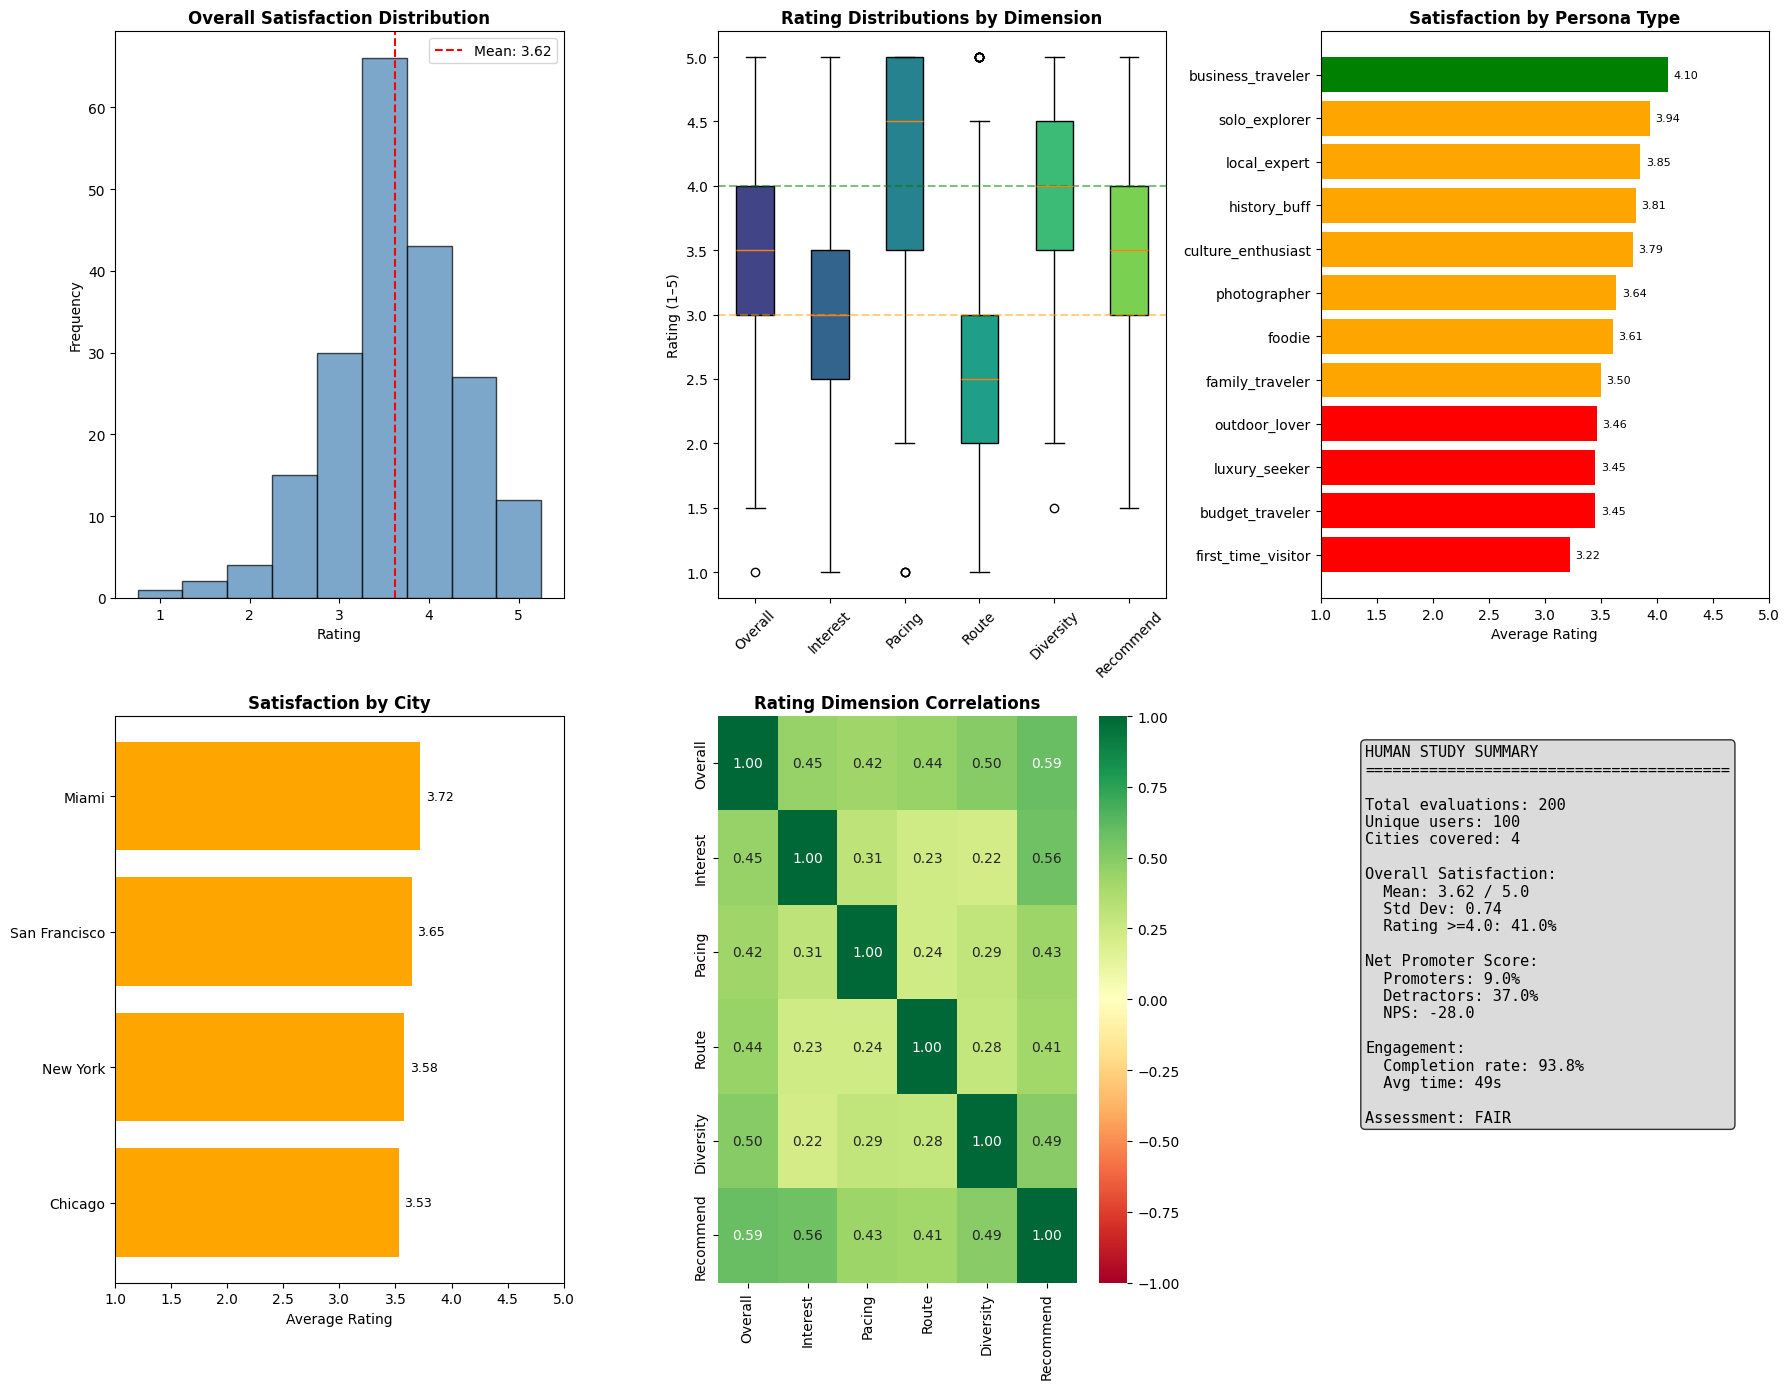


Human study simulation complete.


In [28]:
# Cell 18: Human Study Simulation


class UserPersona:
    """Represents a simulated user with realistic characteristics"""

    def __init__(self, persona_id: int, persona_type: str = None):
        self.id = persona_id

        # Randomly assign persona type if not specified
        persona_types = [
            'culture_enthusiast', 'foodie', 'outdoor_lover', 'history_buff',
            'budget_traveler', 'luxury_seeker', 'family_traveler', 'solo_explorer',
            'photographer', 'local_expert', 'first_time_visitor', 'business_traveler'
        ]

        self.persona_type = persona_type or np.random.choice(persona_types)

        # Generate characteristics and preferences
        self._generate_characteristics()
        self._generate_rating_style()
        self._generate_preferences()

    def _generate_characteristics(self):
        """Generate demographic and behavioral characteristics"""

        # Age group
        self.age = np.random.choice(
            ['18-24', '25-34', '35-44', '45-54', '55-64', '65+'],
            p=[0.15, 0.30, 0.25, 0.15, 0.10, 0.05]
        )

        # Travel experience level
        self.experience_level = np.random.choice(
            ['novice', 'intermediate', 'experienced', 'expert'],
            p=[0.20, 0.35, 0.30, 0.15]
        )

        # Tech savviness (affects how they interact with the app)
        self.tech_savvy = np.random.choice(
            ['low', 'medium', 'high'],
            p=[0.20, 0.50, 0.30]
        )

        # Walking tolerance (km per day)
        self.walking_tolerance = {
            '18-24': np.random.uniform(8, 15),
            '25-34': np.random.uniform(7, 12),
            '35-44': np.random.uniform(5, 10),
            '45-54': np.random.uniform(4, 8),
            '55-64': np.random.uniform(3, 6),
            '65+': np.random.uniform(2, 5)
        }[self.age]

        # Time preference
        self.preferred_start_time = np.random.choice(
            ['early_bird', 'normal', 'late_starter'],
            p=[0.25, 0.55, 0.20]
        )

        # Pace preference
        self.pace_preference = np.random.choice(
            ['relaxed', 'moderate', 'packed'],
            p=[0.30, 0.50, 0.20]
        )

    def _generate_rating_style(self):
        """Generate individual rating tendencies"""

        # Base rating tendency (some people rate higher/lower on average)
        self.rating_bias = np.random.normal(0, 0.5)

        # Rating variability
        self.rating_variance = np.random.uniform(0.3, 0.8)

        # Strictness level
        self.strictness = np.random.choice(
            ['lenient', 'moderate', 'strict'],
            p=[0.25, 0.50, 0.25]
        )

        # Tendency to use extreme ratings
        self.extreme_tendency = np.random.uniform(0, 0.3)

        # Likelihood to skip questions
        self.skip_probability = np.random.uniform(0, 0.15)

        # Engagement level
        self.engagement = np.random.choice(
            ['low', 'medium', 'high'],
            p=[0.15, 0.55, 0.30]
        )

    def _generate_preferences(self):
        """Generate content preferences based on persona type"""

        preference_map = {
            'culture_enthusiast': {
                'preferred_categories': ['museum', 'gallery', 'art', 'theatre', 'historic'],
                'disliked_categories': ['fast_food', 'mall', 'supermarket'],
                'importance_weights': {'diversity': 0.9, 'culture': 1.0, 'food': 0.6}
            },
            'foodie': {
                'preferred_categories': ['restaurant', 'cafe', 'bar', 'market', 'bakery'],
                'disliked_categories': ['fast_food', 'supermarket'],
                'importance_weights': {'diversity': 0.7, 'food_quality': 1.0, 'ambiance': 0.8}
            },
            'outdoor_lover': {
                'preferred_categories': ['park', 'garden', 'beach', 'nature', 'viewpoint'],
                'disliked_categories': ['mall', 'museum', 'shop'],
                'importance_weights': {'outdoor': 1.0, 'nature': 0.9, 'walking': 0.8}
            },
            'history_buff': {
                'preferred_categories': ['historic', 'memorial', 'monument', 'museum', 'castle'],
                'disliked_categories': ['mall', 'fast_food', 'nightclub'],
                'importance_weights': {'history': 1.0, 'authenticity': 0.9, 'education': 0.8}
            },
            'budget_traveler': {
                'preferred_categories': ['park', 'viewpoint', 'market', 'cafe'],
                'disliked_categories': ['luxury', 'fine_dining'],
                'importance_weights': {'cost': 1.0, 'value': 0.9, 'free_activities': 0.8}
            },
            'luxury_seeker': {
                'preferred_categories': ['restaurant', 'hotel', 'spa', 'gallery', 'theatre'],
                'disliked_categories': ['fast_food', 'budget', 'hostel'],
                'importance_weights': {'quality': 1.0, 'exclusivity': 0.9, 'service': 0.8}
            },
            'family_traveler': {
                'preferred_categories': ['park', 'zoo', 'museum', 'playground', 'beach'],
                'disliked_categories': ['bar', 'nightclub', 'pub'],
                'importance_weights': {'family_friendly': 1.0, 'safety': 0.9, 'entertainment': 0.8}
            },
            'solo_explorer': {
                'preferred_categories': ['cafe', 'museum', 'park', 'viewpoint', 'bar'],
                'disliked_categories': ['family', 'playground'],
                'importance_weights': {'atmosphere': 0.9, 'safety': 0.8, 'social': 0.7}
            },
            'photographer': {
                'preferred_categories': ['viewpoint', 'landmark', 'park', 'historic', 'architecture'],
                'disliked_categories': ['mall', 'supermarket'],
                'importance_weights': {'visual': 1.0, 'lighting': 0.8, 'uniqueness': 0.9}
            },
            'local_expert': {
                'preferred_categories': ['hidden_gem', 'local', 'authentic', 'neighborhood'],
                'disliked_categories': ['tourist_trap', 'chain'],
                'importance_weights': {'authenticity': 1.0, 'local': 0.9, 'unique': 0.8}
            },
            'first_time_visitor': {
                'preferred_categories': ['landmark', 'famous', 'must_see', 'iconic'],
                'disliked_categories': [],
                'importance_weights': {'iconic': 1.0, 'famous': 0.9, 'photo_op': 0.8}
            },
            'business_traveler': {
                'preferred_categories': ['restaurant', 'cafe', 'hotel', 'bar'],
                'disliked_categories': ['tourist', 'family', 'playground'],
                'importance_weights': {'efficiency': 1.0, 'quality': 0.8, 'convenience': 0.9}
            }
        }

        prefs = preference_map.get(self.persona_type, preference_map['first_time_visitor'])
        self.preferred_categories = prefs['preferred_categories']
        self.disliked_categories = prefs['disliked_categories']
        self.importance_weights = prefs['importance_weights']

    def __repr__(self):
        return f"UserPersona(id={self.id}, type={self.persona_type}, age={self.age}, strictness={self.strictness})"


class RealisticRatingSimulator:
    """Simulates ratings based on itinerary quality and user preferences"""

    def __init__(self):
        self.rating_dimensions = [
            'overall_satisfaction',
            'interest_match',
            'pacing_appropriateness',
            'route_logic',
            'diversity_variety',
            'explanation_helpfulness',
            'time_management',
            'would_recommend'
        ]

        # Feedback templates for qualitative responses
        self.positive_feedback = [
            "Really enjoyed the variety of places suggested.",
            "The timing worked out well for our schedule.",
            "Good mix of activities that matched our interests.",
            "The route was convenient for walking.",
            "The explanations were helpful in understanding each place.",
            "Balanced combination of popular spots and lesser-known places.",
            "Time estimates felt realistic.",
            "I would consider using this again for planning future trips."
        ]

        self.negative_feedback = [
            "Some places did not match what I was looking for.",
            "The schedule felt rushed between locations.",
            "I would have preferred more variety in the suggestions.",
            "The walking distances were higher than expected.",
            "Explanations could be more detailed.",
            "Too many similar types of places.",
            "Time estimates did not feel accurate.",
            "Missing some key attractions I expected to see."
        ]

        self.neutral_feedback = [
            "It was fine and met basic expectations.",
            "Some suggestions were good, others less relevant.",
            "Overall experience was average.",
            "It was acceptable but could be improved.",
            "Reasonable starting point for planning."
        ]

        self.specific_feedback = {
            'too_many_restaurants': "Too many restaurants, would prefer more variety.",
            'not_enough_culture': "Would like more cultural or museum options.",
            'too_spread_out': "Locations were too spread out with a lot of walking.",
            'good_diversity': "Good variety of different types of places.",
            'great_timing': "Timing and pacing felt appropriate.",
            'missing_landmarks': "Missing some well-known landmarks I wanted to visit.",
            'loved_hidden_gems': "The lesser-known places included were appreciated.",
            'too_touristy': "The plan felt too focused on tourist-heavy locations.",
            'perfect_for_interests': "Matched my interests very well."
        }

    def calculate_interest_match(self, itinerary: List[Dict], persona: UserPersona) -> float:
        """Calculate how well the itinerary matches user interests"""

        if not itinerary:
            return 0.5

        match_score = 0
        total_pois = len(itinerary)

        for item in itinerary:
            poi = item['poi']
            categories = poi.get('category', [])
            if isinstance(categories, str):
                categories = [categories]
            categories_lower = [c.lower() for c in categories]

            # Check for preferred categories
            preferred_matches = sum(
                1 for pref in persona.preferred_categories
                if any(pref in cat for cat in categories_lower)
            )

            # Check for disliked categories
            disliked_matches = sum(
                1 for dis in persona.disliked_categories
                if any(dis in cat for cat in categories_lower)
            )

            # Score this POI
            poi_score = 0.5
            poi_score += min(preferred_matches * 0.2, 0.4)
            poi_score -= disliked_matches * 0.3

            match_score += max(0, min(1, poi_score))

        return match_score / total_pois

    def calculate_pacing_score(self, itinerary: List[Dict], persona: UserPersona) -> float:
        """Calculate pacing appropriateness based on user preferences"""

        if not itinerary:
            return 0.5

        # Calculate total time and stops
        total_duration = sum(item.get('duration_minutes', 45) for item in itinerary)
        num_stops = len(itinerary)
        avg_duration = total_duration / num_stops if num_stops > 0 else 0

        # Ideal pacing based on persona
        ideal_avg_duration = {
            'relaxed': 75,
            'moderate': 55,
            'packed': 40
        }[persona.pace_preference]

        # Calculate deviation from ideal
        deviation = abs(avg_duration - ideal_avg_duration) / ideal_avg_duration
        pacing_score = max(0, 1 - deviation)

        # Adjust for number of stops
        ideal_stops = {
            'relaxed': 4,
            'moderate': 6,
            'packed': 8
        }[persona.pace_preference]

        stops_deviation = abs(num_stops - ideal_stops) / ideal_stops
        stops_score = max(0, 1 - stops_deviation * 0.5)

        return (pacing_score * 0.6 + stops_score * 0.4)

    def calculate_route_logic_score(self, itinerary: List[Dict], persona: UserPersona) -> float:
        """Calculate route logic score based on walking tolerance"""

        if len(itinerary) < 2:
            return 0.8

        # Calculate total walking distance
        total_distance = sum(
            item.get('travel_from_previous', {}).get('distance_km', 0)
            for item in itinerary
        )

        # Compare to user's walking tolerance
        tolerance = persona.walking_tolerance

        if total_distance <= tolerance * 0.7:
            score = 1.0
        elif total_distance <= tolerance:
            score = 0.8
        elif total_distance <= tolerance * 1.3:
            score = 0.6
        else:
            score = 0.4

        return score

    def calculate_diversity_score(self, itinerary: List[Dict]) -> float:
        """Calculate diversity of the itinerary"""

        if not itinerary:
            return 0.5

        all_categories = []
        for item in itinerary:
            cats = item['poi'].get('category', [])
            if isinstance(cats, str):
                cats = [cats]
            all_categories.extend(cats)

        unique_categories = len(set(all_categories))
        total_pois = len(itinerary)

        # Diversity ratio
        diversity_ratio = unique_categories / (total_pois * 1.5)

        return min(1.0, diversity_ratio)

    def generate_rating(self, base_score: float, persona: UserPersona,
                        dimension: str) -> float:
        """Generate a rating with persona-specific biases"""

        # Apply persona bias
        adjusted_score = base_score + persona.rating_bias * 0.1

        # Apply strictness
        strictness_modifier = {
            'lenient': 0.15,
            'moderate': 0,
            'strict': -0.15
        }[persona.strictness]
        adjusted_score += strictness_modifier

        # Add noise
        noise = np.random.normal(0, persona.rating_variance * 0.15)
        adjusted_score += noise

        # Extreme tendency
        if np.random.random() < persona.extreme_tendency:
            if adjusted_score > 0.6:
                adjusted_score = min(1.0, adjusted_score + 0.2)
            elif adjusted_score < 0.4:
                adjusted_score = max(0, adjusted_score - 0.2)

        # Convert to 1–5 scale
        rating = 1 + adjusted_score * 4

        # Ensure bounds
        rating = max(1, min(5, rating))

        # Round to nearest 0.5
        rating = round(rating * 2) / 2

        return rating

    def simulate_skip(self, persona: UserPersona) -> bool:
        """Simulate whether user skips a question"""
        return np.random.random() < persona.skip_probability

    def generate_feedback(self, ratings: Dict, persona: UserPersona,
                          itinerary: List[Dict]) -> Dict:
        """Generate qualitative feedback"""

        feedback = {
            'open_ended': '',
            'specific_comments': [],
            'improvement_suggestions': []
        }

        # Filter out None values before calculating average
        valid_ratings = [r for r in ratings.values() if r is not None]
        avg_rating = np.mean(valid_ratings) if valid_ratings else 3.0

        # Open-ended feedback based on overall satisfaction
        if avg_rating >= 4.0:
            feedback['open_ended'] = np.random.choice(self.positive_feedback)
        elif avg_rating <= 2.5:
            feedback['open_ended'] = np.random.choice(self.negative_feedback)
        else:
            feedback['open_ended'] = np.random.choice(self.neutral_feedback)

        # Helper to safely get rating with None handling
        def safe_rating(key, default=3.0):
            val = ratings.get(key)
            return val if val is not None else default

        # Specific comments based on ratings
        if safe_rating('diversity_variety') < 3:
            feedback['specific_comments'].append(
                self.specific_feedback['too_many_restaurants']
                if self._has_too_many_restaurants(itinerary)
                else self.specific_feedback['not_enough_culture']
            )
        elif safe_rating('diversity_variety') >= 4:
            feedback['specific_comments'].append(self.specific_feedback['good_diversity'])

        if safe_rating('route_logic') < 3:
            feedback['specific_comments'].append(self.specific_feedback['too_spread_out'])

        if safe_rating('pacing_appropriateness') >= 4:
            feedback['specific_comments'].append(self.specific_feedback['great_timing'])

        if safe_rating('interest_match') >= 4:
            feedback['specific_comments'].append(self.specific_feedback['perfect_for_interests'])
        elif safe_rating('interest_match') < 3:
            if persona.persona_type == 'culture_enthusiast':
                feedback['specific_comments'].append(self.specific_feedback['not_enough_culture'])
            elif persona.persona_type == 'first_time_visitor':
                feedback['specific_comments'].append(self.specific_feedback['missing_landmarks'])

        # Improvement suggestions based on persona
        if avg_rating < 4.0:
            suggestions = []
            if persona.persona_type in ['culture_enthusiast', 'history_buff']:
                suggestions.append("Include more cultural and historical sites.")
            if persona.persona_type == 'foodie':
                suggestions.append("Add more diverse dining options.")
            if persona.persona_type == 'outdoor_lover':
                suggestions.append("Include more parks and outdoor spaces.")
            if persona.pace_preference == 'relaxed':
                suggestions.append("Reduce the number of stops for a more relaxed pace.")
            if persona.pace_preference == 'packed':
                suggestions.append("Allow a few more attractions for a busy schedule.")

            feedback['improvement_suggestions'] = suggestions[:2]

        return feedback

    def _has_too_many_restaurants(self, itinerary: List[Dict]) -> bool:
        """Check if itinerary has too many restaurants"""
        restaurant_count = sum(
            1 for item in itinerary
            if 'restaurant' in str(item['poi'].get('category', [])).lower()
        )
        return restaurant_count > len(itinerary) * 0.4

    def simulate_user_evaluation(self, itinerary: List[Dict],
                                 persona: UserPersona,
                                 city: str, query: str) -> Dict:
        """Simulate a complete user evaluation"""

        # Base scores from itinerary analysis
        interest_match = self.calculate_interest_match(itinerary, persona)
        pacing_score = self.calculate_pacing_score(itinerary, persona)
        route_score = self.calculate_route_logic_score(itinerary, persona)
        diversity_score = self.calculate_diversity_score(itinerary)

        # Generate ratings for each dimension
        ratings = {}

        # Overall satisfaction
        overall_base = (
            interest_match * 0.3 +
            pacing_score * 0.2 +
            route_score * 0.2 +
            diversity_score * 0.3
        )
        ratings['overall_satisfaction'] = self.generate_rating(overall_base, persona, 'overall')

        # Interest match
        if not self.simulate_skip(persona):
            ratings['interest_match'] = self.generate_rating(interest_match, persona, 'interest')
        else:
            ratings['interest_match'] = None

        # Pacing
        if not self.simulate_skip(persona):
            ratings['pacing_appropriateness'] = self.generate_rating(pacing_score, persona, 'pacing')
        else:
            ratings['pacing_appropriateness'] = None

        # Route logic
        if not self.simulate_skip(persona):
            ratings['route_logic'] = self.generate_rating(route_score, persona, 'route')
        else:
            ratings['route_logic'] = None

        # Diversity
        if not self.simulate_skip(persona):
            ratings['diversity_variety'] = self.generate_rating(diversity_score, persona, 'diversity')
        else:
            ratings['diversity_variety'] = None

        # Explanation helpfulness (simulated)
        explanation_base = 0.6 + np.random.uniform(-0.1, 0.2)
        if not self.simulate_skip(persona):
            ratings['explanation_helpfulness'] = self.generate_rating(explanation_base, persona, 'explanation')
        else:
            ratings['explanation_helpfulness'] = None

        # Time management
        if not self.simulate_skip(persona):
            ratings['time_management'] = self.generate_rating(
                pacing_score * 0.7 + route_score * 0.3, persona, 'time'
            )
        else:
            ratings['time_management'] = None

        # Would recommend
        recommend_base = overall_base * 0.8 + interest_match * 0.2
        ratings['would_recommend'] = self.generate_rating(recommend_base, persona, 'recommend')

        # Qualitative feedback
        feedback = self.generate_feedback(ratings, persona, itinerary)

        # Completion rate
        completed_ratings = sum(1 for r in ratings.values() if r is not None)
        completion_rate = completed_ratings / len(ratings)

        # Time spent (seconds)
        base_time = 45
        engagement_multiplier = {'low': 0.6, 'medium': 1.0, 'high': 1.5}[persona.engagement]
        time_spent = int(base_time * engagement_multiplier * np.random.uniform(0.8, 1.2))

        return {
            'user_id': persona.id,
            'persona_type': persona.persona_type,
            'age_group': persona.age,
            'experience_level': persona.experience_level,
            'city': city,
            'query': query,
            'ratings': ratings,
            'feedback': feedback,
            'completion_rate': completion_rate,
            'time_spent_seconds': time_spent,
            'base_scores': {
                'interest_match': interest_match,
                'pacing': pacing_score,
                'route_logic': route_score,
                'diversity': diversity_score
            }
        }


def run_human_study_simulation(retriever, itinerary_generator,
                               n_users: int = 100,
                               evaluations_per_user: int = 2):
    """Run human study simulation"""

    print("\nHUMAN STUDY SIMULATION")
    print("=" * 70)

    simulator = RealisticRatingSimulator()

    # Get all cities
    city_counts = Counter()
    for poi_id, poi in retriever.poi_cache.items():
        city_counts[poi.get('city', 'Unknown')] += 1

    all_cities = [city for city, count in city_counts.most_common() if count >= 50]

    print(f"Cities available: {', '.join(all_cities)}")
    print(f"Simulating {n_users} users with {evaluations_per_user} evaluations each")
    print(f"Total evaluations: {n_users * evaluations_per_user}")

    # Test queries
    test_queries = [
        'museums and cultural attractions',
        'restaurants and dining',
        'parks and outdoor activities',
        'historic landmarks',
        'cafes and coffee shops',
        'shopping and entertainment',
        'nightlife and bars'
    ]

    # Generate user personas
    print(f"\nGenerating {n_users} user personas...")
    personas = [UserPersona(i) for i in range(n_users)]

    # Persona distribution
    persona_dist = Counter(p.persona_type for p in personas)
    print("Persona distribution:")
    for ptype, count in persona_dist.most_common():
        print(f"   - {ptype}: {count}")

    # Run simulation
    all_evaluations = []
    city_evaluations = defaultdict(list)

    print("\nRunning simulations...")

    for user_idx, persona in enumerate(personas):
        if (user_idx + 1) % 20 == 0:
            print(f"   Processed {user_idx + 1}/{n_users} users...")

        # Each user evaluates multiple itineraries
        for eval_idx in range(evaluations_per_user):
            # Select city and query
            city = np.random.choice(all_cities)
            query = np.random.choice(test_queries)

            # Generate itinerary
            try:
                result = itinerary_generator.generate_diverse_itinerary(
                    city=city,
                    query=query,
                    num_stops=np.random.randint(4, 8),
                    budget_hours=np.random.uniform(4, 8),
                    transport_mode='walk'
                )

                if result['status'] != 'success':
                    continue

                itinerary = result['itinerary']

            except Exception:
                continue

            # Simulate user evaluation
            evaluation = simulator.simulate_user_evaluation(
                itinerary, persona, city, query
            )

            all_evaluations.append(evaluation)
            city_evaluations[city].append(evaluation)

    print(f"\nCompleted {len(all_evaluations)} evaluations")

    # Analyze results
    print("\n" + "=" * 70)
    print("HUMAN STUDY RESULTS ANALYSIS")
    print("=" * 70)

    # Extract ratings into DataFrame
    ratings_data = []
    for eval in all_evaluations:
        row = {
            'user_id': eval['user_id'],
            'persona_type': eval['persona_type'],
            'age_group': eval['age_group'],
            'experience_level': eval['experience_level'],
            'city': eval['city'],
            'query': eval['query'],
            'completion_rate': eval['completion_rate'],
            'time_spent': eval['time_spent_seconds']
        }

        for dim, rating in eval['ratings'].items():
            row[dim] = rating

        for dim, score in eval['base_scores'].items():
            row[f'base_{dim}'] = score

        ratings_data.append(row)

    df_ratings = pd.DataFrame(ratings_data)

    # Overall statistics
    rating_cols = [
        'overall_satisfaction', 'interest_match', 'pacing_appropriateness',
        'route_logic', 'diversity_variety', 'explanation_helpfulness',
        'time_management', 'would_recommend'
    ]

    print("\nOverall Rating Statistics (1–5 scale):")
    print("-" * 50)

    for col in rating_cols:
        valid_ratings = df_ratings[col].dropna()
        if len(valid_ratings) > 0:
            mean_r = valid_ratings.mean()
            std_r = valid_ratings.std()
            median_r = valid_ratings.median()
            response_rate = len(valid_ratings) / len(df_ratings) * 100

            # Simple bar visualization in text
            bar_len = int(mean_r * 6)
            bar = '#' * bar_len + '.' * (30 - bar_len)

            print(
                f"   {col[:25]:25} {bar} "
                f"{mean_r:.2f} ± {std_r:.2f} (n={len(valid_ratings)}, {response_rate:.0f}%)"
            )

    # Net Promoter Score (NPS)
    print("\nNet Promoter Score (NPS):")
    print("-" * 50)

    recommend_ratings = df_ratings['would_recommend'].dropna()
    promoters = len(recommend_ratings[recommend_ratings >= 4.5])
    passives = len(recommend_ratings[(recommend_ratings >= 3.5) & (recommend_ratings < 4.5)])
    detractors = len(recommend_ratings[recommend_ratings < 3.5])
    total_nps = len(recommend_ratings)

    nps_score = ((promoters - detractors) / total_nps) * 100 if total_nps > 0 else 0

    print(f"   Promoters (≥4.5): {promoters} ({promoters/total_nps*100:.1f}%)")
    print(f"   Passives (3.5–4.5): {passives} ({passives/total_nps*100:.1f}%)")
    print(f"   Detractors (<3.5): {detractors} ({detractors/total_nps*100:.1f}%)")
    print(f"   NPS Score: {nps_score:.1f}")

    # By persona type
    print("\nRatings by Persona Type:")
    print("-" * 50)

    persona_summary = df_ratings.groupby('persona_type')[
        ['overall_satisfaction', 'interest_match', 'would_recommend']
    ].mean()
    persona_summary = persona_summary.sort_values('overall_satisfaction', ascending=False)

    for persona, row in persona_summary.iterrows():
        print(
            f"   {persona:20} "
            f"Overall: {row['overall_satisfaction']:.2f}, "
            f"Match: {row['interest_match']:.2f}, "
            f"Recommend: {row['would_recommend']:.2f}"
        )

    # By city
    print("\nRatings by City:")
    print("-" * 50)

    city_summary = df_ratings.groupby('city')[
        ['overall_satisfaction', 'would_recommend']
    ].agg(['mean', 'count'])
    city_summary.columns = ['overall_mean', 'overall_n', 'recommend_mean', 'recommend_n']
    city_summary = city_summary.sort_values('overall_mean', ascending=False)

    for city, row in city_summary.iterrows():
        print(
            f"   {city:20} "
            f"Overall: {row['overall_mean']:.2f} (n={int(row['overall_n'])}), "
            f"Recommend: {row['recommend_mean']:.2f}"
        )

    # By query type
    print("\nRatings by Query Type:")
    print("-" * 50)

    query_summary = df_ratings.groupby('query')[
        ['overall_satisfaction', 'interest_match']
    ].mean()
    query_summary = query_summary.sort_values('overall_satisfaction', ascending=False)

    for query, row in query_summary.iterrows():
        print(
            f"   - {query[:35]:35} "
            f"Overall: {row['overall_satisfaction']:.2f}, "
            f"Match: {row['interest_match']:.2f}"
        )

    # By experience level
    print("\nRatings by Experience Level:")
    print("-" * 50)

    exp_summary = df_ratings.groupby('experience_level')[
        ['overall_satisfaction', 'would_recommend']
    ].mean()
    exp_order = ['novice', 'intermediate', 'experienced', 'expert']

    for exp in exp_order:
        if exp in exp_summary.index:
            row = exp_summary.loc[exp]
            print(
                f"   - {exp:15} "
                f"Overall: {row['overall_satisfaction']:.2f}, "
                f"Recommend: {row['would_recommend']:.2f}"
            )

    # Qualitative feedback analysis
    print("\nQualitative Feedback Summary:")
    print("-" * 50)

    all_feedback = []
    all_suggestions = []

    for eval in all_evaluations:
        if eval['feedback']['open_ended']:
            all_feedback.append(eval['feedback']['open_ended'])
        all_suggestions.extend(eval['feedback']['improvement_suggestions'])

    feedback_counts = Counter(all_feedback)
    suggestion_counts = Counter(all_suggestions)

    print("   Most common feedback:")
    for feedback, count in feedback_counts.most_common(5):
        print(f"      - \"{feedback[:50]}...\" ({count} times)")

    print("\n   Top improvement suggestions:")
    for suggestion, count in suggestion_counts.most_common(5):
        print(f"      - \"{suggestion}\" ({count} times)")

    # Completion and engagement stats
    print("\nEngagement Statistics:")
    print("-" * 50)
    print(f"   Average completion rate: {df_ratings['completion_rate'].mean():.1%}")
    print(f"   Average time spent: {df_ratings['time_spent'].mean():.1f} seconds")
    print(f"   Median time spent: {df_ratings['time_spent'].median():.1f} seconds")

    return df_ratings, all_evaluations


def visualize_human_study_results(df_ratings):
    """Create visualizations for human study results"""

    print("\nGenerating human study visualizations...")

    fig = plt.figure(figsize=(18, 14))

    # 1. Overall rating distribution
    ax1 = fig.add_subplot(2, 3, 1)

    overall_ratings = df_ratings['overall_satisfaction'].dropna()
    ax1.hist(
        overall_ratings,
        bins=np.arange(0.75, 5.75, 0.5),
        color='steelblue',
        edgecolor='black',
        alpha=0.7
    )
    ax1.axvline(
        x=overall_ratings.mean(),
        color='red',
        linestyle='--',
        label=f'Mean: {overall_ratings.mean():.2f}'
    )
    ax1.set_xlabel('Rating')
    ax1.set_ylabel('Frequency')
    ax1.set_title('Overall Satisfaction Distribution', fontweight='bold')
    ax1.legend()
    ax1.set_xlim(0.5, 5.5)

    # 2. Ratings by dimension (box plot)
    ax2 = fig.add_subplot(2, 3, 2)

    rating_cols = [
        'overall_satisfaction', 'interest_match', 'pacing_appropriateness',
        'route_logic', 'diversity_variety', 'would_recommend'
    ]

    rating_data = [df_ratings[col].dropna().values for col in rating_cols]
    labels = ['Overall', 'Interest', 'Pacing', 'Route', 'Diversity', 'Recommend']

    bp = ax2.boxplot(rating_data, labels=labels, patch_artist=True)
    colors = plt.cm.viridis(np.linspace(0.2, 0.8, len(rating_cols)))
    for patch, color in zip(bp['boxes'], colors):
        patch.set_facecolor(color)

    ax2.set_ylabel('Rating (1–5)')
    ax2.set_title('Rating Distributions by Dimension', fontweight='bold')
    ax2.tick_params(axis='x', rotation=45)
    ax2.axhline(y=4.0, color='green', linestyle='--', alpha=0.5)
    ax2.axhline(y=3.0, color='orange', linestyle='--', alpha=0.5)

    # 3. Ratings by persona type
    ax3 = fig.add_subplot(2, 3, 3)

    persona_means = df_ratings.groupby('persona_type')[
        'overall_satisfaction'
    ].mean().sort_values(ascending=True)
    colors = [
        'green' if x >= 4.0 else 'orange' if x >= 3.5 else 'red'
        for x in persona_means
    ]

    bars = ax3.barh(persona_means.index, persona_means.values, color=colors)
    ax3.set_xlabel('Average Rating')
    ax3.set_title('Satisfaction by Persona Type', fontweight='bold')
    ax3.set_xlim(1, 5)

    for bar, val in zip(bars, persona_means.values):
        ax3.text(
            val + 0.05,
            bar.get_y() + bar.get_height() / 2,
            f'{val:.2f}',
            va='center',
            fontsize=8
        )

    # 4. Ratings by city
    ax4 = fig.add_subplot(2, 3, 4)

    city_means = df_ratings.groupby('city')[
        'overall_satisfaction'
    ].mean().sort_values(ascending=True)
    colors = [
        'green' if x >= 4.0 else 'orange' if x >= 3.5 else 'red'
        for x in city_means
    ]

    bars = ax4.barh(city_means.index, city_means.values, color=colors)
    ax4.set_xlabel('Average Rating')
    ax4.set_title('Satisfaction by City', fontweight='bold')
    ax4.set_xlim(1, 5)

    for bar, val in zip(bars, city_means.values):
        ax4.text(
            val + 0.05,
            bar.get_y() + bar.get_height() / 2,
            f'{val:.2f}',
            va='center',
            fontsize=9
        )

    # 5. Correlation heatmap
    ax5 = fig.add_subplot(2, 3, 5)

    corr_cols = [
        'overall_satisfaction', 'interest_match', 'pacing_appropriateness',
        'route_logic', 'diversity_variety', 'would_recommend'
    ]
    corr_matrix = df_ratings[corr_cols].corr()

    short_labels = ['Overall', 'Interest', 'Pacing', 'Route', 'Diversity', 'Recommend']

    sns.heatmap(
        corr_matrix,
        annot=True,
        fmt='.2f',
        cmap='RdYlGn',
        xticklabels=short_labels,
        yticklabels=short_labels,
        ax=ax5,
        vmin=-1,
        vmax=1,
        center=0
    )
    ax5.set_title('Rating Dimension Correlations', fontweight='bold')

    # 6. Summary statistics
    ax6 = fig.add_subplot(2, 3, 6)
    ax6.axis('off')

    # Key metrics
    overall_mean = df_ratings['overall_satisfaction'].mean()
    overall_std = df_ratings['overall_satisfaction'].std()

    recommend = df_ratings['would_recommend'].dropna()
    promoters = len(recommend[recommend >= 4.5]) / len(recommend) * 100
    detractors = len(recommend[recommend < 3.5]) / len(recommend) * 100
    nps = promoters - detractors

    completion = df_ratings['completion_rate'].mean() * 100

    summary_text = "HUMAN STUDY SUMMARY\n" + "=" * 40 + "\n\n"
    summary_text += f"Total evaluations: {len(df_ratings)}\n"
    summary_text += f"Unique users: {df_ratings['user_id'].nunique()}\n"
    summary_text += f"Cities covered: {df_ratings['city'].nunique()}\n\n"

    summary_text += "Overall Satisfaction:\n"
    summary_text += f"  Mean: {overall_mean:.2f} / 5.0\n"
    summary_text += f"  Std Dev: {overall_std:.2f}\n"
    summary_text += (
        f"  Rating >=4.0: "
        f"{len(df_ratings[df_ratings['overall_satisfaction'] >= 4.0]) / len(df_ratings) * 100:.1f}%\n\n"
    )

    summary_text += "Net Promoter Score:\n"
    summary_text += f"  Promoters: {promoters:.1f}%\n"
    summary_text += f"  Detractors: {detractors:.1f}%\n"
    summary_text += f"  NPS: {nps:.1f}\n\n"

    summary_text += "Engagement:\n"
    summary_text += f"  Completion rate: {completion:.1f}%\n"
    summary_text += f"  Avg time: {df_ratings['time_spent'].mean():.0f}s\n\n"

    if overall_mean >= 4.0 and nps >= 30:
        assessment = "EXCELLENT"
    elif overall_mean >= 3.5 and nps >= 0:
        assessment = "GOOD"
    elif overall_mean >= 3.0:
        assessment = "FAIR"
    else:
        assessment = "NEEDS IMPROVEMENT"

    summary_text += f"Assessment: {assessment}"

    ax6.text(
        0.1,
        0.95,
        summary_text,
        transform=ax6.transAxes,
        fontsize=11,
        verticalalignment='top',
        fontfamily='monospace',
        bbox=dict(boxstyle='round', facecolor='lightgray', alpha=0.8)
    )

    plt.tight_layout()
    plt.savefig('human_study_results.png', dpi=150, bbox_inches='tight')
    print("Visualization saved as 'human_study_results.png'")

    plt.show()

    return fig




print("Starting human study simulation...\n")

if 'retriever' in dir():
    # Create itinerary generator if not exists
    if 'itinerary_generator' not in dir():
        cs = constraint_solver if 'constraint_solver' in dir() else None
        itinerary_generator = DiverseItineraryGenerator(retriever, cs)

    # Run simulation with 100 users, 2 evaluations each
    human_study_ratings, human_study_evaluations = run_human_study_simulation(
        retriever,
        itinerary_generator,
        n_users=100,
        evaluations_per_user=2
    )

    if human_study_ratings is not None and len(human_study_ratings) > 0:
        print("\n" + "=" * 70)

        # Generate visualization
        try:
            fig = visualize_human_study_results(human_study_ratings)
        except Exception as e:
            print(f"Visualization error: {e}")
            import traceback
            traceback.print_exc()

        print("\nHuman study simulation complete.")
        print("=" * 70)
else:
    print("Retriever not found.")


# Streamlit UI

In [ ]:
!pip install streamlit pyngrok

In [26]:
%%writefile app.py
"""
AI Trip Planner - Streamlit

Run with: streamlit run app.py
"""

import streamlit as st
import folium
from streamlit_folium import st_folium
import pandas as pd
import numpy as np
import requests
import time
from datetime import datetime, timedelta
from typing import Dict, List, Tuple, Optional
from math import radians, sin, cos, sqrt, atan2
import logging

# Setup logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

st.set_page_config(
    page_title="AI Trip Planner",
    page_icon="TP",
    layout="wide",
    initial_sidebar_state="expanded"
)


CITIES_DB = {
    'New York': {
        'country': 'USA',
        'bbox': (40.4774, -74.2591, 40.9176, -73.7004),
        'lat': 40.7128,
        'lon': -74.0060,
        'airports': ['JFK', 'LGA', 'EWR'],
        'known_for': 'Times Square, Central Park, Broadway'
    },
    'Los Angeles': {
        'country': 'USA',
        'bbox': (33.7037, -118.6682, 34.3373, -118.1553),
        'lat': 34.0522,
        'lon': -118.2437,
        'airports': ['LAX', 'BUR', 'SNA'],
        'known_for': 'Hollywood, beaches, entertainment'
    },
    'San Francisco': {
        'country': 'USA',
        'bbox': (37.6398, -122.5198, 37.8298, -122.3548),
        'lat': 37.7749,
        'lon': -122.4194,
        'airports': ['SFO', 'OAK', 'SJC'],
        'known_for': 'Golden Gate Bridge, tech culture, diverse food scene'
    },
    'Chicago': {
        'country': 'USA',
        'bbox': (41.6445, -87.9401, 42.0230, -87.5241),
        'lat': 41.8781,
        'lon': -87.6298,
        'airports': ['ORD', 'MDW'],
        'known_for': 'Deep dish pizza, architecture, blues music'
    },
    'Miami': {
        'country': 'USA',
        'bbox': (25.7135, -80.3706, 25.8557, -80.1300),
        'lat': 25.7617,
        'lon': -80.1918,
        'airports': ['MIA', 'FLL'],
        'known_for': 'Beaches, Art Deco, Cuban cuisine'
    },
    'Austin': {
        'country': 'USA',
        'bbox': (30.1175, -97.9383, 30.5168, -97.5698),
        'lat': 30.2672,
        'lon': -97.7431,
        'airports': ['AUS'],
        'known_for': 'Live music, BBQ, tech startups'
    },
    'Paris': {
        'country': 'France',
        'bbox': (48.8156, 2.2242, 48.9022, 2.4699),
        'lat': 48.8566,
        'lon': 2.3522,
        'airports': ['CDG', 'ORY'],
        'known_for': 'Eiffel Tower, Louvre, French cuisine'
    },
    'Amsterdam': {
        'country': 'Netherlands',
        'bbox': (52.3279, 4.7288, 52.4316, 5.0791),
        'lat': 52.3676,
        'lon': 4.9041,
        'airports': ['AMS'],
        'known_for': 'Canals, Anne Frank House, Van Gogh Museum'
    },
    'London': {
        'country': 'UK',
        'bbox': (51.2868, -0.5103, 51.6919, 0.3340),
        'lat': 51.5074,
        'lon': -0.1278,
        'airports': ['LHR', 'LGW', 'STN', 'LTN'],
        'known_for': 'Big Ben, British Museum, West End theatres'
    },
}



if 'poi_cache' not in st.session_state:
    st.session_state.poi_cache = {}

if 'trip_generated' not in st.session_state:
    st.session_state.trip_generated = False



class OSMDataFetcher:
    """Fetch POI data from OpenStreetMap using Overpass API"""

    OVERPASS_URL = "https://overpass-api.de/api/interpreter"

    POI_QUERIES = {
        'tourism': ['museum', 'gallery', 'attraction', 'viewpoint', 'artwork', 'monument'],
        'historic': ['monument', 'memorial', 'castle', 'ruins', 'archaeological_site'],
        'amenity': ['restaurant', 'cafe', 'bar', 'pub', 'theatre', 'cinema', 'nightclub'],
        'leisure': ['park', 'garden', 'nature_reserve'],
        'shop': ['mall', 'department_store'],
    }

    def __init__(self):
        self.session = requests.Session()
        self.session.headers.update({
            'User-Agent': 'TripPlannerStreamlit/1.0 (Educational Project)'
        })

    def fetch_city_pois(self, city: str, country: str, bbox: Tuple[float, float, float, float],
                        max_results: int = 500) -> List[Dict]:
        """Fetch POIs for a city"""

        min_lat, min_lon, max_lat, max_lon = bbox
        all_pois = []

        for main_cat, sub_cats in self.POI_QUERIES.items():
            for sub_cat in sub_cats:
                query = f"""
                [out:json][timeout:30];
                (
                  node["{main_cat}"="{sub_cat}"]({min_lat},{min_lon},{max_lat},{max_lon});
                  way["{main_cat}"="{sub_cat}"]({min_lat},{min_lon},{max_lat},{max_lon});
                  relation["{main_cat}"="{sub_cat}"]({min_lat},{min_lon},{max_lat},{max_lon});
                );
                out center 50;
                """

                try:
                    response = self.session.post(self.OVERPASS_URL, data={'data': query}, timeout=35)

                    if response.status_code == 200:
                        data = response.json()
                        elements = data.get('elements', [])

                        for element in elements:
                            poi = self._parse_osm_element(element, city, country)
                            if poi:
                                all_pois.append(poi)

                    time.sleep(0.5)

                except Exception as e:
                    logger.warning(f"OSM fetch error: {e}")
                    continue

                if len(all_pois) >= max_results:
                    break

            if len(all_pois) >= max_results:
                break

        return all_pois[:max_results]

    def _parse_osm_element(self, element: Dict, city: str, country: str) -> Optional[Dict]:
        """Parse OSM element into POI format"""
        tags = element.get('tags', {})

        name = tags.get('name') or tags.get('name:en')
        if not name:
            return None

        if element['type'] == 'node':
            lat, lon = element.get('lat'), element.get('lon')
        elif 'center' in element:
            lat, lon = element['center'].get('lat'), element['center'].get('lon')
        else:
            return None

        if not lat or not lon:
            return None

        categories = []
        for main_cat in self.POI_QUERIES.keys():
            if main_cat in tags:
                categories.append(main_cat)
                categories.append(tags[main_cat])

        if not categories:
            categories = ['other']

        return {
            'source': 'osm',
            'source_id': f"osm_{element['type']}_{element['id']}",
            'name': name,
            'description': tags.get('description', ''),
            'lat': lat,
            'lon': lon,
            'category': list(set(categories)),
            'tags': tags,
            'city': city,
            'country': country,
            'wikidata_id': tags.get('wikidata'),
            'wheelchair_accessible': tags.get('wheelchair') == 'yes',
            'opening_hours': tags.get('opening_hours'),
            'cuisine': tags.get('cuisine'),
            'phone': tags.get('phone'),
            'website': tags.get('website'),
            'address': tags.get('addr:street', '') + ' ' + tags.get('addr:housenumber', ''),
        }


class WikidataEnricher:
    """Enrich POIs with Wikidata descriptions"""

    WIKIDATA_URL = "https://www.wikidata.org/w/api.php"

    def __init__(self):
        self.session = requests.Session()
        self.session.headers.update({
            'User-Agent': 'TripPlannerStreamlit/1.0 (Educational Project)'
        })

    def enrich_poi_batch(self, pois: List[Dict], batch_size: int = 50) -> List[Dict]:
        """Enrich POIs with Wikidata descriptions"""
        pois_with_wd = [(i, poi) for i, poi in enumerate(pois) if poi.get('wikidata_id')]

        if not pois_with_wd:
            return pois

        for batch_start in range(0, len(pois_with_wd), batch_size):
            batch = pois_with_wd[batch_start:batch_start + batch_size]
            qids = [poi['wikidata_id'] for _, poi in batch]

            try:
                params = {
                    'action': 'wbgetentities',
                    'ids': '|'.join(qids),
                    'props': 'labels|descriptions',
                    'languages': 'en',
                    'format': 'json'
                }

                response = self.session.get(self.WIKIDATA_URL, params=params, timeout=30)
                response.raise_for_status()
                data = response.json()

                for idx, poi in batch:
                    qid = poi['wikidata_id']
                    entity = data.get('entities', {}).get(qid, {})

                    descriptions = entity.get('descriptions', {})
                    if 'en' in descriptions:
                        pois[idx]['description'] = descriptions['en']['value']

                time.sleep(0.5)

            except Exception as e:
                logger.warning(f"Wikidata batch failed: {e}")
                continue

        return pois




def format_time(hour: int, minute: int = 0) -> str:
    """Format time in 12-hour format"""
    period = "AM" if hour < 12 else "PM"
    display_hour = hour if hour <= 12 else hour - 12
    if display_hour == 0:
        display_hour = 12
    return f"{display_hour}:{minute:02d} {period}"


def get_activity_duration(poi_type: str) -> int:
    """Get typical duration in hours for different POI types"""
    duration_map = {
        'museum': 3, 'gallery': 2, 'park': 2, 'monument': 1,
        'historic': 2, 'restaurant': 2, 'cafe': 1, 'shopping': 2,
        'mall': 3, 'theatre': 3, 'bar': 2, 'pub': 2, 'club': 3,
    }

    for key, duration in duration_map.items():
        if key in poi_type.lower():
            return duration
    return 2


def estimate_activity_cost(poi: Dict, budget_level: str) -> int:
    """Estimate cost for an activity"""
    categories = poi.get('category', [])
    if isinstance(categories, str):
        categories = [categories]

    free_types = ['park', 'garden', 'monument', 'viewpoint', 'street', 'neighborhood']
    if any(ft in str(categories).lower() for ft in free_types):
        return 0

    cost_map = {
        'Budget': {'museum': 15, 'gallery': 10, 'historic': 12, 'theatre': 40, 'default': 10},
        'Mid-range': {'museum': 25, 'gallery': 18, 'historic': 20, 'theatre': 60, 'default': 20},
        'Luxury': {'museum': 35, 'gallery': 25, 'historic': 30, 'theatre': 100, 'default': 30}
    }

    costs = cost_map.get(budget_level, cost_map['Mid-range'])

    for key, cost in costs.items():
        if key in str(categories).lower():
            return cost

    return costs['default']


def estimate_meal_cost(budget_level: str, meal_type: str) -> int:
    """Estimate cost for meals"""
    meal_costs = {
        'Budget': {'breakfast': 8, 'lunch': 15, 'dinner': 20},
        'Mid-range': {'breakfast': 15, 'lunch': 25, 'dinner': 40},
        'Luxury': {'breakfast': 30, 'lunch': 50, 'dinner': 80}
    }
    return meal_costs.get(budget_level, meal_costs['Mid-range']).get(meal_type, 25)


def get_poi_image_url(poi: Dict) -> str:
    """Get image URL for POI"""
    categories = poi.get('category', [])
    if isinstance(categories, str):
        categories = [categories]

    category_str = categories[0] if categories else 'landmark'
    city = poi.get('city', 'city')
    return f"https://source.unsplash.com/400x300/?{category_str},{city}"




def fetch_city_data_realtime(city: str, progress_bar=None) -> Tuple[List[Dict], str]:
    """Fetch POI data for a city in real-time"""

    if city in st.session_state.poi_cache:
        return st.session_state.poi_cache[city], f"Loaded {len(st.session_state.poi_cache[city])} POIs from cache."

    if city not in CITIES_DB:
        return [], f"City '{city}' not found in database."

    city_info = CITIES_DB[city]
    fetcher = OSMDataFetcher()
    enricher = WikidataEnricher()

    if progress_bar:
        progress_bar.progress(30, text="Fetching POIs from OpenStreetMap...")

    pois = fetcher.fetch_city_pois(
        city=city,
        country=city_info['country'],
        bbox=city_info['bbox'],
        max_results=500
    )

    if not pois:
        return [], f"No POIs found for {city}."

    if progress_bar:
        progress_bar.progress(70, text="Enriching with Wikidata...")

    pois = enricher.enrich_poi_batch(pois)
    st.session_state.poi_cache[city] = pois

    if progress_bar:
        progress_bar.progress(100, text="Complete.")

    return pois, f"Fetched and enriched {len(pois)} POIs for {city}."


def get_real_attractions(city: str, interests: List[str]) -> List[Dict]:
    """Get attraction data from fetched POIs"""

    if city not in st.session_state.poi_cache:
        return []

    pois = st.session_state.poi_cache[city]

    interest_keywords = {
        'Museums': ['museum', 'gallery', 'art', 'exhibition'],
        'Food & Dining': ['restaurant', 'cafe', 'food', 'market'],
        'Nightlife': ['bar', 'pub', 'club', 'nightclub', 'entertainment'],
        'Outdoor': ['park', 'garden', 'nature', 'beach', 'outdoor'],
        'Shopping': ['shop', 'shopping', 'mall', 'market', 'store'],
        'History': ['historic', 'monument', 'memorial', 'heritage', 'castle'],
        'Art': ['art', 'gallery', 'museum', 'theatre', 'theater'],
        'Music': ['music', 'concert', 'opera', 'theatre']
    }

    relevant_keywords = []
    for interest in interests:
        relevant_keywords.extend(interest_keywords.get(interest, []))

    attractions = []
    tourism_categories = [
        'tourism', 'attraction', 'monument', 'viewpoint', 'museum',
        'gallery', 'park', 'garden', 'landmark', 'historic'
    ]

    for poi in pois:
        categories = poi.get('category', [])
        if isinstance(categories, str):
            categories = [categories]

        is_attraction = any(cat.lower() in tourism_categories for cat in categories)
        matches_interest = not interests or any(
            cat.lower() in [rc.lower() for rc in relevant_keywords]
            for cat in categories
        )

        if is_attraction and matches_interest:
            attractions.append(poi)

    attractions.sort(
        key=lambda x: float(x.get('rating', 0)) if x.get('rating') else 0,
        reverse=True
    )

    return attractions[:50]


def get_real_restaurants(city: str, budget_level: str, interests: List[str]) -> str:
    """Get restaurant data from fetched POIs"""

    if city not in st.session_state.poi_cache:
        return f"Please fetch data for {city} first by clicking 'Fetch Destination Data'."

    pois = st.session_state.poi_cache[city]
    food_categories = ['restaurant', 'cafe', 'food', 'bar', 'pub', 'fast_food', 'bistro', 'bakery']
    restaurants = []

    for poi in pois:
        categories = poi.get('category', [])
        if isinstance(categories, str):
            categories = [categories]

        if any(cat.lower() in food_categories for cat in categories):
            restaurants.append(poi)

    restaurants.sort(
        key=lambda x: float(x.get('rating', 0)) if x.get('rating') else 0,
        reverse=True
    )
    restaurants = restaurants[:20]

    if not restaurants:
        return f"No restaurants found in {city}."

    output = f"## Top Restaurants in {city}\n\n"
    output += f"**Budget Level:** {budget_level}\n"
    output += f"**Found:** {len(restaurants)} restaurants\n\n"
    output += "---\n\n"

    for i, rest in enumerate(restaurants, 1):
        name = rest.get('name', 'Unknown Restaurant')
        output += f"### {i}. {name}\n\n"

        img_url = f"https://source.unsplash.com/400x300/?restaurant,food,{rest.get('cuisine', 'dining')}"
        output += f"![{name}]({img_url})\n\n"

        categories = rest.get('category', [])
        if isinstance(categories, str):
            categories = [categories]
        output += f"**Type:** {', '.join(categories[:3])}\n\n"

        if rest.get('cuisine'):
            output += f"**Cuisine:** {rest['cuisine']}\n\n"

        if rest.get('address') and rest['address'].strip():
            output += f"**Address:** {rest['address']}\n\n"

        if rest.get('description'):
            desc_preview = (
                rest['description'][:150] + "..."
                if len(rest['description']) > 150
                else rest['description']
            )
            output += f"{desc_preview}\n\n"

        if rest.get('opening_hours'):
            output += f"**Hours:** {rest['opening_hours']}\n\n"

        if rest.get('website'):
            output += f"[Website]({rest['website']})\n\n"

        output += "---\n\n"

    return output


def generate_enhanced_itinerary(destination: str, trip_days: int, budget_level: str,
                               interests: List[str]) -> str:
    """Generate detailed itinerary with times, costs, and images"""

    if destination not in st.session_state.poi_cache:
        return f"Please fetch data for {destination} first by clicking 'Fetch Destination Data'."

    attractions = get_real_attractions(destination, interests)

    if not attractions:
        return f"No attractions found in {destination} matching your interests."

    pois = st.session_state.poi_cache[destination]
    food_categories = ['restaurant', 'cafe', 'bistro', 'bar']
    restaurants = [
        p for p in pois
        if any(cat in str(p.get('category', [])).lower() for cat in food_categories)
    ]

    output = f"## {destination} - {trip_days}-Day Detailed Itinerary\n\n"
    output += f"**Interests:** {', '.join(interests) if interests else 'All'}\n"
    output += f"**Budget Level:** {budget_level}\n"
    output += "**Data Source:** Real-time from OpenStreetMap and Wikidata\n\n"

    total_cost = 0
    attr_idx = 0
    rest_idx = 0

    for day in range(1, trip_days + 1):
        current_time = 9
        daily_cost = 0

        output += f"---\n\n"
        output += f"## Day {day}\n\n"

        # Morning Activity
        if attr_idx < len(attractions):
            poi = attractions[attr_idx % len(attractions)]
            attr_idx += 1

            duration = get_activity_duration(str(poi.get('category', '')))
            cost = estimate_activity_cost(poi, budget_level)

            start_time = format_time(current_time)
            end_time = format_time(current_time + duration)

            output += f"### Morning: {start_time} - {end_time}\n\n"
            output += f"**{poi['name']}**\n\n"

            img_url = get_poi_image_url(poi)
            output += f"![{poi['name']}]({img_url})\n\n"

            cats = poi.get('category', [])
            if isinstance(cats, str):
                cats = [cats]
            output += f"**Type:** {', '.join(cats[:2])}\n\n"

            if poi.get('address') and poi['address'].strip():
                output += f"**Address:** {poi['address']}\n\n"

            if poi.get('description'):
                desc = (
                    poi['description'][:200] + "..."
                    if len(poi['description']) > 200
                    else poi['description']
                )
                output += f"{desc}\n\n"

            if poi.get('opening_hours'):
                output += f"**Hours:** {poi['opening_hours']}\n\n"

            if cost == 0:
                output += f"**Cost:** $0 per person (free)\n\n"
            else:
                output += f"**Cost:** ${cost} per person\n\n"

            output += f"**Estimated Duration:** ~{duration} hours\n\n"

            daily_cost += cost
            current_time += duration

        # Lunch
        current_time = max(current_time, 12)
        if rest_idx < len(restaurants):
            poi = restaurants[rest_idx % len(restaurants)]
            rest_idx += 1

            meal_cost = estimate_meal_cost(budget_level, 'lunch')

            start_time = format_time(current_time)
            end_time = format_time(current_time + 1, 30)

            output += f"### Lunch: {start_time} - {end_time}\n\n"
            output += f"**{poi['name']}**\n\n"

            img_url = f"https://source.unsplash.com/400x300/?restaurant,food,{poi.get('cuisine', 'dining')}"
            output += f"![{poi['name']}]({img_url})\n\n"

            if poi.get('cuisine'):
                output += f"**Cuisine:** {poi['cuisine']}\n\n"

            if poi.get('address') and poi['address'].strip():
                output += f"**Address:** {poi['address']}\n\n"

            output += f"**Estimated Cost:** ${meal_cost} per person\n\n"

            daily_cost += meal_cost
            current_time += 2

        # Afternoon Activity
        if attr_idx < len(attractions):
            poi = attractions[attr_idx % len(attractions)]
            attr_idx += 1

            duration = get_activity_duration(str(poi.get('category', '')))
            cost = estimate_activity_cost(poi, budget_level)

            start_time = format_time(current_time)
            end_time = format_time(current_time + duration)

            output += f"### Afternoon: {start_time} - {end_time}\n\n"
            output += f"**{poi['name']}**\n\n"

            img_url = get_poi_image_url(poi)
            output += f"![{poi['name']}]({img_url})\n\n"

            cats = poi.get('category', [])
            if isinstance(cats, str):
                cats = [cats]
            output += f"**Type:** {', '.join(cats[:2])}\n\n"

            if poi.get('address') and poi['address'].strip():
                output += f"**Address:** {poi['address']}\n\n"

            if poi.get('description'):
                desc = (
                    poi['description'][:150] + "..."
                    if len(poi['description']) > 150
                    else poi['description']
                )
                output += f"{desc}\n\n"

            if cost == 0:
                output += f"**Cost:** $0 per person (free)\n\n"
            else:
                output += f"**Cost:** ${cost} per person\n\n"

            output += f"**Estimated Duration:** ~{duration} hours\n\n"

            daily_cost += cost
            current_time += duration

        # Dinner
        current_time = max(current_time, 18)
        if rest_idx < len(restaurants):
            poi = restaurants[rest_idx % len(restaurants)]
            rest_idx += 1

            meal_cost = estimate_meal_cost(budget_level, 'dinner')

            start_time = format_time(current_time)
            end_time = format_time(current_time + 2)

            output += f"### Dinner: {start_time} - {end_time}\n\n"
            output += f"**{poi['name']}**\n\n"

            img_url = f"https://source.unsplash.com/400x300/?dinner,restaurant,{poi.get('cuisine', 'food')}"
            output += f"![{poi['name']}]({img_url})\n\n"

            if poi.get('cuisine'):
                output += f"**Cuisine:** {poi['cuisine']}\n\n"

            if poi.get('address') and poi['address'].strip():
                output += f"**Address:** {poi['address']}\n\n"

            if poi.get('opening_hours'):
                output += f"**Hours:** {poi['opening_hours']}\n\n"

            output += f"**Estimated Cost:** ${meal_cost} per person\n\n"

            daily_cost += meal_cost
            current_time += 2

        # Evening Activity (optional for nightlife)
        if 'Nightlife' in interests and attr_idx < len(attractions):
            nightlife_pois = [
                p for p in pois
                if any(
                    cat in ['bar', 'pub', 'club', 'nightclub']
                    for cat in str(p.get('category', '')).lower().split(',')
                )
            ]

            if nightlife_pois and current_time < 23:
                poi = nightlife_pois[day % len(nightlife_pois)]

                start_time = format_time(current_time)
                end_time = format_time(min(current_time + 2, 23), 30)

                output += f"### Evening: {start_time} - {end_time}\n\n"
                output += f"**{poi['name']}**\n\n"
                output += "Nightlife experience.\n\n"

                if poi.get('address') and poi['address'].strip():
                    output += f"**Address:** {poi['address']}\n\n"

                daily_cost += 30

        output += f"\n**Day {day} Total Cost:** ${daily_cost} per person\n\n"
        total_cost += daily_cost

    output += f"\n---\n\n"
    output += "## Complete Trip Cost Summary\n\n"
    output += f"**Total Activities and Dining:** ${total_cost} per person\n"
    output += f"**Average per Day:** ${total_cost // trip_days} per person\n\n"

    return output


def generate_flight_options(origin: str, destination: str, date_str: str, budget: int) -> str:
    """Generate multiple detailed flight options"""

    if origin == destination:
        return "Error: origin and destination cannot be the same."

    if origin not in CITIES_DB or destination not in CITIES_DB:
        return "Error: city not found."

    R = 6371
    lat1, lon1 = CITIES_DB[origin]['lat'], CITIES_DB[origin]['lon']
    lat2, lon2 = CITIES_DB[destination]['lat'], CITIES_DB[destination]['lon']

    dlat = radians(lat2 - lat1)
    dlon = radians(lon2 - lon1)
    a = sin(dlat / 2) ** 2 + cos(radians(lat1)) * cos(radians(lat2)) * sin(dlon / 2) ** 2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))
    distance = R * c

    base_price = int(distance * 0.12)

    airlines = [
        ('United Airlines', 'UA', 0.95),
        ('American Airlines', 'AA', 1.0),
        ('Delta Air Lines', 'DL', 1.05),
        ('Southwest Airlines', 'WN', 0.85),
        ('JetBlue Airways', 'B6', 0.90),
        ('Air France', 'AF', 1.15),
        ('KLM', 'KL', 1.10),
        ('British Airways', 'BA', 1.20),
        ('Lufthansa', 'LH', 1.12),
        ('Emirates', 'EK', 1.25),
    ]

    output = f"## Available Flights: {origin} → {destination}\n\n"
    output += f"**Date:** {date_str}\n"
    output += f"**Distance:** {int(distance)} km ({int(distance * 0.621)} miles)\n"
    output += f"**Your Budget:** ${budget} per person\n\n"
    output += "---\n\n"

    flights = []

    for i, (airline_name, airline_code, price_multiplier) in enumerate(airlines):
        price_variation = np.random.uniform(0.95, 1.15)
        price = int(base_price * price_multiplier * price_variation)

        departure_hour = 6 + (i * 1.8)
        duration_hours = (distance / 800) + np.random.uniform(-0.3, 0.5)

        if distance < 1500:
            stops = 0
            stops_text = "Nonstop"
        elif distance < 4000:
            stops = 0 if np.random.random() > 0.3 else 1
            stops_text = "Nonstop" if stops == 0 else "1 stop"
        else:
            stops = 1 if np.random.random() > 0.2 else 2
            stops_text = f"{stops} stop{'s' if stops > 1 else ''}"

        arrival_hour = departure_hour + duration_hours + (stops * 1.5)

        economy_price = price
        premium_economy = int(price * 1.5)
        business_price = int(price * 3)
        first_class = int(price * 5)

        flight_info = {
            'airline': airline_name,
            'code': airline_code,
            'flight_no': f"{airline_code}{np.random.randint(100, 9999)}",
            'departure': format_time(int(departure_hour), int((departure_hour % 1) * 60)),
            'arrival': format_time(int(arrival_hour) % 24, int((arrival_hour % 1) * 60)),
            'duration': f"{int(duration_hours)}h {int((duration_hours % 1) * 60)}m",
            'stops': stops,
            'stops_text': stops_text,
            'economy': economy_price,
            'premium_economy': premium_economy,
            'business': business_price,
            'first': first_class,
            'aircraft': np.random.choice(
                ['Boeing 737', 'Boeing 787', 'Airbus A320', 'Airbus A350', 'Boeing 777']
            )
        }

        flights.append(flight_info)

    flights.sort(key=lambda x: x['economy'])

    for i, flight in enumerate(flights, 1):
        if flight['economy'] <= budget:
            budget_status = "Within budget"
        elif flight['economy'] <= budget * 1.2:
            budget_status = "Slightly over budget"
        else:
            budget_status = "Over budget"

        output += f"### Option {i}: {flight['airline']}\n\n"
        output += f"**Flight {flight['flight_no']}** | {flight['aircraft']}\n\n"

        output += f"Departure: {flight['departure']} from {CITIES_DB[origin]['airports'][0]}\n\n"
        output += f"Arrival: {flight['arrival']} at {CITIES_DB[destination]['airports'][0]}\n\n"

        output += f"Flight time: {flight['duration']} | {flight['stops_text']}\n\n"

        output += f"Status relative to budget: {budget_status}\n\n"

        output += "**Fare classes:**\n"
        output += f"- Economy: ${flight['economy']}\n"
        output += f"- Premium Economy: ${flight['premium_economy']}\n"
        output += f"- Business: ${flight['business']}\n"
        output += f"- First Class: ${flight['first']}\n\n"

        amenities = []
        if flight['stops'] == 0:
            amenities.append("Nonstop flight")
        if flight['economy'] <= budget * 0.7:
            amenities.append("Good value compared to budget")
        if 'Boeing 787' in flight['aircraft'] or 'A350' in flight['aircraft']:
            amenities.append("Modern aircraft")
        if i <= 3:
            amenities.append("Recommended based on price and schedule")

        if amenities:
            output += "Highlights: " + " | ".join(amenities) + "\n\n"

        output += "---\n\n"

    cheapest = flights[0]['economy']
    most_expensive = flights[-1]['economy']

    output += "### Price Range Summary\n\n"
    output += f"- Cheapest option: ${cheapest} ({flights[0]['airline']})\n"
    output += f"- Most expensive: ${most_expensive} ({flights[-1]['airline']})\n"
    output += f"- Average price: ${sum(f['economy'] for f in flights) // len(flights)}\n"
    output += f"- Flights within budget: {sum(1 for f in flights if f['economy'] <= budget)} of {len(flights)}\n\n"

    return output


def calculate_enhanced_budget(origin: str, destination: str, trip_days: int, travelers: int,
                              budget_level: str, flight_budget: int, interests: List[str]) -> str:
    """Calculate detailed budget with breakdown"""

    R = 6371
    lat1, lon1 = CITIES_DB[origin]['lat'], CITIES_DB[origin]['lon']
    lat2, lon2 = CITIES_DB[destination]['lat'], CITIES_DB[destination]['lon']
    dlat = radians(lat2 - lat1)
    dlon = radians(lon2 - lon1)
    a = sin(dlat / 2) ** 2 + cos(radians(lat1)) * cos(radians(lat2)) * sin(dlon / 2) ** 2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))
    distance = R * c
    flight_cost = min(int(distance * 0.12), flight_budget)

    hotel_per_night = {'Budget': 80, 'Mid-range': 150, 'Luxury': 300}
    hotel_cost = trip_days * hotel_per_night[budget_level]

    breakfast_cost = trip_days * estimate_meal_cost(budget_level, 'breakfast')
    lunch_cost = trip_days * estimate_meal_cost(budget_level, 'lunch')
    dinner_cost = trip_days * estimate_meal_cost(budget_level, 'dinner')
    total_food = breakfast_cost + lunch_cost + dinner_cost

    activities_cost = 0
    if destination in st.session_state.poi_cache:
        attractions = get_real_attractions(destination, interests)
        for i in range(min(trip_days * 2, len(attractions))):
            activities_cost += estimate_activity_cost(attractions[i], budget_level)
    else:
        activities_cost = trip_days * 40

    local_transport = trip_days * 15
    misc = trip_days * 20

    total_per_person = (flight_cost * 2) + hotel_cost + total_food + activities_cost + local_transport + misc
    total_all = total_per_person * travelers

    output = "## Comprehensive Budget Breakdown\n\n"
    output += f"**Trip:** {origin} to {destination} ({trip_days} days)\n"
    output += f"**Travelers:** {travelers} person{'s' if travelers > 1 else ''}\n"
    output += f"**Budget Level:** {budget_level}\n"
    output += f"**Flight Distance:** {int(distance)} km\n\n"
    output += "---\n\n"

    output += "### Per Person Breakdown\n\n"

    output += "#### Flights (Round Trip)\n"
    output += f"- Outbound: ${flight_cost:,}\n"
    output += f"- Return: ${flight_cost:,}\n"
    output += f"- Subtotal: ${flight_cost * 2:,}\n\n"

    output += f"#### Accommodation ({trip_days} nights)\n"
    output += f"- Rate: ${hotel_per_night[budget_level]}/night\n"
    output += f"- Subtotal: ${hotel_cost:,}\n\n"

    output += f"#### Food and Dining ({trip_days} days)\n"
    output += f"- Breakfast: ${breakfast_cost:,} (${estimate_meal_cost(budget_level, 'breakfast')}/day)\n"
    output += f"- Lunch: ${lunch_cost:,} (${estimate_meal_cost(budget_level, 'lunch')}/day)\n"
    output += f"- Dinner: ${dinner_cost:,} (${estimate_meal_cost(budget_level, 'dinner')}/day)\n"
    output += f"- Subtotal: ${total_food:,}\n\n"

    output += "#### Activities and Attractions\n"
    if destination in st.session_state.poi_cache:
        output += (
            f"- Estimated for "
            f"{min(trip_days * 2, len(get_real_attractions(destination, interests)))} activities\n"
        )
    output += f"- Subtotal: ${activities_cost:,}\n\n"

    output += "#### Local Transportation\n"
    output += "- Daily average: $15\n"
    output += f"- Subtotal: ${local_transport:,}\n\n"

    output += "#### Miscellaneous\n"
    output += "- Tips, souvenirs, and other small expenses\n"
    output += f"- Subtotal: ${misc:,}\n\n"

    output += "---\n\n"

    output += "### Grand Total\n\n"
    output += f"Per person: ${total_per_person:,}\n\n"
    output += f"For {travelers} traveler{'s' if travelers > 1 else ''}: ${total_all:,}\n\n"
    output += f"Daily average per person: ${total_per_person // trip_days:,}\n\n"

    output += "---\n\n"
    output += "### Budget Level Comparison\n\n"

    for level in ['Budget', 'Mid-range', 'Luxury']:
        if level == budget_level:
            continue

        alt_hotel = trip_days * hotel_per_night[level]
        alt_breakfast = trip_days * estimate_meal_cost(level, 'breakfast')
        alt_lunch = trip_days * estimate_meal_cost(level, 'lunch')
        alt_dinner = trip_days * estimate_meal_cost(level, 'dinner')
        alt_total = (
            (flight_cost * 2)
            + alt_hotel
            + alt_breakfast
            + alt_lunch
            + alt_dinner
            + activities_cost
            + local_transport
            + misc
        )

        difference = alt_total - total_per_person

        if difference < 0:
            output += f"{level}: ${alt_total:,} per person (saves ${abs(difference):,} compared to current level)\n"
        else:
            output += f"{level}: ${alt_total:,} per person (+${difference:,} compared to current level)\n"

    output += "\n---\n\n"
    output += "### Money-Saving Tips\n\n"

    if destination in st.session_state.poi_cache:
        free_count = sum(
            1
            for a in get_real_attractions(destination, interests)
            if estimate_activity_cost(a, budget_level) == 0
        )
        output += f"- Found approximately {free_count} free attractions in {destination}.\n"

    if budget_level == 'Luxury':
        savings = (300 - 150) * trip_days * travelers
        output += f"- Switching to mid-range hotels could save around ${savings:,}.\n"

    if budget_level != 'Budget':
        food_savings = (
            (estimate_meal_cost(budget_level, 'lunch') - estimate_meal_cost('Budget', 'lunch'))
            + (estimate_meal_cost(budget_level, 'dinner') - estimate_meal_cost('Budget', 'dinner'))
        ) * trip_days * travelers
        output += f"- Mixing budget dining with a few nicer meals could save around ${food_savings:,}.\n"

    output += "- Buying local transport passes can reduce daily transport costs.\n"
    output += "- Booking attractions in advance often gives small discounts.\n"

    return output


def create_trip_map(origin: str, destination: str, stops: List[str]) -> folium.Map:
    """Create trip map with POI markers"""

    all_cities = [origin] + (stops if stops else []) + [destination]
    valid_cities = [c for c in all_cities if c in CITIES_DB]
    center_lat = np.mean([CITIES_DB[c]['lat'] for c in valid_cities])
    center_lon = np.mean([CITIES_DB[c]['lon'] for c in valid_cities])

    m = folium.Map(location=[center_lat, center_lon], zoom_start=4)

    for i, city in enumerate(valid_cities):
        color = 'green' if i == 0 else 'red' if i == len(valid_cities) - 1 else 'blue'

        poi_count = len(st.session_state.poi_cache.get(city, []))
        popup_text = f"<b>{city}</b><br>{CITIES_DB[city]['known_for']}"
        if poi_count > 0:
            popup_text += f"<br>{poi_count} POIs loaded"

        folium.Marker(
            [CITIES_DB[city]['lat'], CITIES_DB[city]['lon']],
            popup=popup_text,
            tooltip=city,
            icon=folium.Icon(
                color=color,
                icon='plane' if i in [0, len(valid_cities) - 1] else 'info-sign'
            )
        ).add_to(m)

    if len(valid_cities) > 1:
        route_coords = [[CITIES_DB[c]['lat'], CITIES_DB[c]['lon']] for c in valid_cities]
        folium.PolyLine(
            route_coords,
            weight=3,
            color='blue',
            opacity=0.7,
            dash_array='10'
        ).add_to(m)

    if destination in st.session_state.poi_cache:
        dest_pois = st.session_state.poi_cache[destination][:50]

        for poi in dest_pois:
            lat = poi.get('lat')
            lon = poi.get('lon')

            if lat and lon:
                popup_html = f"<b>{poi['name']}</b><br>"
                cats = poi.get('category', [])
                if isinstance(cats, str):
                    cats = [cats]
                popup_html += f"{', '.join(cats[:2])}"

                folium.CircleMarker(
                    [lat, lon],
                    radius=3,
                    popup=popup_html,
                    color='orange',
                    fill=True,
                    fillColor='orange',
                    fillOpacity=0.6
                ).add_to(m)

    return m



# STREAMLIT UI


def main():
    # Header
    st.title("AI Trip Planner")
    st.markdown("### Plan your trip with real-time data from OpenStreetMap and Wikidata")

    # Sidebar for configuration
    with st.sidebar:
        st.header("Trip Configuration")

        # Trip Type
        trip_type = st.radio(
            "Trip Type",
            options=["One-way", "Round Trip", "Multi-city"],
            index=1
        )

        st.divider()

        # Origin and Destination
        origin = st.selectbox(
            "From",
            options=list(CITIES_DB.keys()),
            index=0
        )

        destination = st.selectbox(
            "To",
            options=list(CITIES_DB.keys()),
            index=6  # Paris
        )

        # Multi-city stops
        stops = []
        if trip_type == "Multi-city":
            stops = st.multiselect(
                "Stops (for multi-city)",
                options=[c for c in CITIES_DB.keys() if c not in [origin, destination]]
            )

        st.divider()

        # Dates
        departure_date = st.date_input(
            "Departure Date",
            value=datetime.now() + timedelta(days=14)
        )

        return_date = st.date_input(
            "Return Date",
            value=datetime.now() + timedelta(days=21)
        )

        trip_days = max((return_date - departure_date).days, 1)
        st.info(f"Trip Duration: {trip_days} days")

        st.divider()

        # Budget Section
        st.subheader("Budget")

        total_budget = st.slider(
            "Total Trip Budget ($)",
            min_value=500,
            max_value=20000,
            value=5000,
            step=100
        )

        flight_budget = st.slider(
            "Max Flight Price ($)",
            min_value=100,
            max_value=3000,
            value=800,
            step=50
        )

        budget_level = st.radio(
            "Dining and Accommodation",
            options=["Budget", "Mid-range", "Luxury"],
            index=2
        )

        travelers = st.slider(
            "Number of Travelers",
            min_value=1,
            max_value=10,
            value=2
        )

        st.divider()

        # Interests
        st.subheader("Interests")
        interests = st.multiselect(
            "What do you enjoy?",
            options=[
                "Museums", "Food & Dining", "Nightlife", "Outdoor",
                "Shopping", "History", "Art", "Music"
            ],
            default=["Museums", "Food & Dining", "History", "Art"]
        )

    # Main content area
    col1, col2 = st.columns([1, 2])

    with col1:
        st.subheader("Data Fetching")

        # Fetch Data Button
        if st.button("Fetch Destination Data", type="secondary", use_container_width=True):
            progress_bar = st.progress(0, text="Initializing...")
            pois, status = fetch_city_data_realtime(destination, progress_bar)
            st.success(status)
            progress_bar.empty()

        # Show cache status
        if destination in st.session_state.poi_cache:
            st.success(f"{len(st.session_state.poi_cache[destination])} POIs loaded for {destination}.")
        else:
            st.warning(f"Click 'Fetch Destination Data' to load POIs for {destination}.")

        st.divider()

        # Generate Trip Button
        if st.button("Generate Complete Trip Plan", type="primary", use_container_width=True):
            st.session_state.trip_generated = True

    with col2:
        st.subheader("Trip Overview")
        trip_map = create_trip_map(origin, destination, stops)
        st_folium(trip_map, width=700, height=400)

    # Results Tabs
    if st.session_state.trip_generated:
        st.divider()

        # Create tabs
        tab1, tab2, tab3, tab4 = st.tabs(["Flights", "Itinerary", "Restaurants", "Budget"])

        with tab1:
            with st.spinner("Generating flight options..."):
                flights_output = generate_flight_options(
                    origin,
                    destination,
                    departure_date.strftime("%Y-%m-%d"),
                    flight_budget
                )
                st.markdown(flights_output)

                if trip_type == "Round Trip":
                    st.divider()
                    st.markdown("## Return Flight")
                    return_flights = generate_flight_options(
                        destination,
                        origin,
                        return_date.strftime("%Y-%m-%d"),
                        flight_budget
                    )
                    st.markdown(return_flights)

        with tab2:
            with st.spinner("Creating detailed itinerary..."):
                itinerary_output = generate_enhanced_itinerary(
                    destination, trip_days, budget_level, interests
                )
                st.markdown(itinerary_output)

        with tab3:
            with st.spinner("Finding restaurants..."):
                restaurants_output = get_real_restaurants(
                    destination, budget_level, interests
                )
                st.markdown(restaurants_output)

        with tab4:
            with st.spinner("Calculating budget..."):
                budget_output = calculate_enhanced_budget(
                    origin, destination, trip_days, travelers,
                    budget_level, flight_budget, interests
                )
                st.markdown(budget_output)

    # Footer
    st.divider()
    st.markdown(
        """
        <div style="text-align: center; color: #666;">
            <p>AI Trip Planner | Real-Time Data from OpenStreetMap and Wikidata</p>
            <p>Cities: New York, Los Angeles, San Francisco, Chicago, Miami, Austin, Paris, Amsterdam, London</p>
            <p>Features: Flexible trip length, multiple flight options, real-time POI data, images, and detailed cost estimates</p>
        </div>
        """,
        unsafe_allow_html=True
    )


if __name__ == "__main__":
    main()


Overwriting app.py


In [27]:
from pyngrok import ngrok

ngrok.kill()  # optional clean
ngrok.set_auth_token("36GZmSVOqa7JUivwV7IJY0sgnfF_7QpneHxzmhgGiK8n1yC4o")  # only needed once per runtime

public_url = ngrok.connect(8501)
print("🌍 Streamlit URL:", public_url)

!streamlit run app.py --server.port 8501 --server.address 0.0.0.0

🌍 Streamlit URL: NgrokTunnel: "https://superevangelically-unsympathizing-nicolasa.ngrok-free.dev" -> "http://localhost:8501"



  You can now view your Streamlit app in your browser.

  URL: http://0.0.0.0:8501

  Stopping...
  Stopping...
